# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from IPython.display import HTML
from IPython.display import display_html as displayh
import re
import os
from helper import parse_datadict, pca_results
import warnings
import random
from datetime import datetime as dt

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for encoding and clustering
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from collections import defaultdict

# ML
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer


# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
def display_code():
    display(HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" 
    value="Click here to toggle on/off the raw code."></form>'''))

In [3]:
#display_code()

In [4]:

class TickTock:
    """
    Automatic timer. Assign it to a variable and call the stop_clock method.
    Returns a string format '0:00:00.000000'
    """
    def __init__(self):        
        self.start_time = dt.now()
    def stop_clock(self):
        td = dt.now() - self.start_time
        return ':'.join(str(td).split(':'))

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
def display_html(message, center=False, size=20):
    if center:
        center = ';text-align: center'
    else:
        center = ''
    display(HTML('<br/><p style="font-size:{2}px; text-decoration: underline{0}">{1}<p/>'\
                 .format(center, message, size)))
    
def data_extract(file_name):
    dataframe = pd.read_csv(file_name, delimiter=';')
    print('The dataset {name} has {cols} columns and {rows:,} rows.'.format(name=file_name.split('.')[0], 
                                                                          rows=dataframe.shape[0], 
                                                                          cols=dataframe.shape[1]))
    display(HTML('<br/><p style="font-size:20px; text-decoration: underline">{} Top 5<p/>'.format(file_name.split('.')[0])))
    display(dataframe.head())
    return dataframe

In [6]:
def nan_parse(dataframe_data, dataframe_parser):
    """
    Parameters
    ----------
    dataframe_data :
    dataframe_parser :
    
    Returns: 
        Transformed np.nan dataframe at index 0
        Converted np.nan count and inpact dataframe at index 1, inpact sorted descending
    """
    
    df_unkmiss = {'ColumnName': [], 'Unk_Missing': [], 'Inpact_Percent_Parsed': []}    
    total_count = dataframe_data.shape[0]

    # go over by each column and parse
    for column in dataframe_data.columns:    

        # getting missing lists per column
        miss_unk = (dataframe_parser.loc[dataframe_parser.attribute == column, 'missing_or_unknown'])
        miss_unk = (miss_unk.item().replace('[', '').replace(']', '').split(','))

        # find the value in missing or unknown list
        flag_val_count = dataframe_data.loc[dataframe_data[column].isin(miss_unk), column].count()

        # fill in the dictionary
        if flag_val_count > 0:
            df_unkmiss['ColumnName'].append(column)
            df_unkmiss['Unk_Missing'].append(flag_val_count)
            df_unkmiss['Inpact_Percent_Parsed'].append(flag_val_count/total_count)

        # convert found missing or unknwon to np.nan
        dataframe_data.loc[dataframe_data[column].isin(miss_unk), column] = np.nan
        
    return dataframe_data, pd.DataFrame(df_unkmiss).sort_values('Inpact_Percent_Parsed', ascending=False)

In [7]:
def get_categorical(dataframe, column_list=None, show=False):
    """
    it splits the dataframes into non-categorical and categorical
    
    Parameters
    ----------
    dataframe : the dataframe to get categorical values from
    column_list : pass preferred columns or leave blank to get columns from dataframe
    show : show dataframes with categorical data to encode with the following condition:
        
        - categories with greater than 2 unique or non-numeric values
    
    Returns
    -------
    data_unencoded : this is the non-categorical data and categorical not meeting the condition
    data_toencode : this is the categorical data meeting the condition
    data_toencode : it contains the dropped columns in an array
    """
    
    display_html('Categorical Data To Encode', center=True, size=30)
    
    column_list = list(dataframe.columns)
    
    # get categorical columns only
    categorical_columns = feat_info.query("type == 'categorical' and attribute == {}".format(column_list))
    
    # getting only categorical
    data_categorical = dataframe.loc[:, categorical_columns.attribute]
    data_categorical_info = pd.concat([data_categorical.dtypes, data_categorical.nunique()], axis=1).\
                                rename(columns={0:'data_type', 1:'unique_count'}).sort_values('unique_count')
    
    if show:
        # displaying all categorical
        display_html('Categorical Descriptions')
        display(data_categorical_info)
    
    # slicing on conditions
    conditions = (data_categorical_info.data_type == object) | (data_categorical_info.unique_count > 2)    
    data_toencode_info = data_categorical_info.loc[conditions, :]
    
    if show:
        # displaying only ones meeting condition
        display_html('Features to Encode')
        display(data_toencode_info)
    
    # slicing on categories only
    data_toencode = dataframe.loc[:, data_toencode_info.index]
    
    # slicing unencoded only
    data_unencoded = dataframe.drop(data_toencode_info.index, axis=1)
    
    print('There are {} categorical variables. '\
      .format(data_categorical_info.shape[0]) +\
      '\nThere are {} categories with greater than 2 unique or non-numeric values.'\
      .format(data_toencode_info.shape[0]) +\
      '\n{} columns will be encoded.'\
      .format(data_toencode.shape[1]) +\
      '\nThe dataframe passed had {} columns in total.'\
      .format(dataframe.shape[1]) +\
      '\nThere will be {} unencoded columns.'\
      .format(dataframe.shape[1] - data_toencode.shape[1]))
    
    data_unencoded.reset_index(drop=True, inplace=True)
    
    dropped_columns = data_toencode_info.index
    
    return data_unencoded, data_toencode, dropped_columns 

In [8]:
def sweet_encode(dataframe, encoder=None):
    # setting the encoder in a dict
    if not encoder:
        encoder = defaultdict(LabelBinarizer)
    
    # dataframe container
    dataframe_encoded = pd.DataFrame()
    
    display_html('Encoding', center=True, size=30)
    # one big encoder
    for column in dataframe.columns:
        print('Endoding: %s' % column)
        X = encoder[column].fit_transform(dataframe[column].values)
        encoder_columns = [column + '_' + str(enc_value) for enc_value in range(X.shape[1])]
        new_dataframe_encoded = pd.DataFrame(X, columns=encoder_columns)
        dataframe_encoded = pd.concat([dataframe_encoded, new_dataframe_encoded], axis=1)  
    
    return dataframe_encoded, encoder

In [9]:
def set_encoding(dataframe, show=False):
    
    dataframe.reset_index(drop=True, inplace=True)    
  
    #categorical_columns = feat_info.query("type == 'categorical' and attribute == {}".format(column_list))
    
    # out of all good columns only encode ones that meet conditions
    #dataframe_toencode = dataframe.loc[:, categorical_columns.index] 
    
    # filling nulls with 0
    dataframe_toencode = dataframe.fillna('0').apply(pd.to_numeric, errors='ignore', downcast='integer')
    
    
    # dataframe container
    #dataframe_encoded = pd.DataFrame()
    
    # one big encoder    
    dataframe_encoded, encoder = sweet_encode(dataframe_toencode)
        
    # reuse dataframe_toencode
    dataframe_toencode = dataframe
    
    # get encodings in dataframe
    encoder_classes = pd.DataFrame({'encoding': 
                [encoder[column].classes_ for column in dataframe_toencode.columns]})
    
    # get null counts and datatypes merged with encdoings 
    df_toreencode = pd.concat([dataframe_toencode.isna().sum(), 
                       dataframe_toencode.dtypes], axis=1)\
                           .rename(columns={0:'Nulls', 1:'Type'})\
                           .reset_index()\
                           .rename(columns={'index':'ColumnName'})\
                           .merge(encoder_classes, left_index=True, right_index=True)
    
    # creating column label of null values to re-encode
    def f(x):
        for label in range(len(x['encoding'])):
            #print(x['encoding'])
            if str(label) == '0':
                return x['ColumnName'] + '_' + str(label)
    df_toreencode['NullLabel'] = df_toreencode.apply(lambda x: f(x), axis=1)
    
    # starting the re-encoding of null values
    pre_encode_column = df_toreencode.loc[(df_toreencode.Nulls > 0), :].ColumnName
    re_encode_column = df_toreencode.loc[(df_toreencode.Nulls > 0), :].NullLabel
    
    if show:
        display_html('Nulls Reencoded Back to Zero')
        display(df_toreencode)
    
    for pre_column, rencode_column in zip(pre_encode_column, re_encode_column):
        # get indexes to re-encode
        indexes = dataframe_toencode[[pre_column]]\
                    .loc[dataframe_toencode.isna()[pre_column]==True, :]\
                    .index
        
        # re-encoding null values from 1 to 0
        
        # get location of target column
        i = dataframe_encoded.columns.get_loc(rencode_column)

        # rencode to zero
        dataframe_encoded.iloc[indexes, i] = 0
        
    return dataframe_encoded, encoder

In [10]:
def remove_outliers(data):
    """
    removed outliers using non-parametric method IQR * 1.5
    Parameters
    ----------
    data : data with all unknown values converted to nan
    axis : 0 to removed outliers at a row level; 1 to remove, at a column level
    show : show plots
    """
    display_html('Outlier Removal Process:', center=True, size=30)
    
    # preparing dataframe of Nulls
    data_process = pd.DataFrame(data.isna().sum(), columns=['NaN_Count'])
    data_process['NaN_Impact'] = data_process.NaN_Count / data.shape[0]
    display_html('Column Removal Process', size=25)
   
    # display skewness
    display(data_process.describe())
    print('Skewness:')
    display(data_process[['NaN_Count']].skew())
    
    # REMOVING COLUMNS PROCESS    
    # getting outlier factors for non-parametric
    outlier_factor = 1.2 * (data_process.NaN_Count.quantile(.75) - data_process.NaN_Count.quantile(.25))
    median = data_process.NaN_Count.median()
    low_bound = median - outlier_factor
    high_bound = median + outlier_factor 
    
    # split bad set from good set
    column_keep = (data_process.NaN_Count >= low_bound) & (data_process.NaN_Count <= high_bound) 
    column_drop = ~column_keep[column_keep == False]
    #column_keep = list(column_keep.where(column_keep == True).dropna().index)
    
    data_process['Column_Status']\
        = data_process.NaN_Count\
            .apply(lambda x: 'Keep' if x >= int(low_bound) & x <= int(high_bound) else 'Drop')
    
    # PLOTS
    # setup subplots
    fig = plt.figure(figsize=(16, 10))  
    plt.subplots_adjust(hspace=.3)
    ax1 = plt.subplot(221)
    plt.title('Histogram of NaNs', size=14)
    ax2 = plt.subplot(223)
    plt.title('Proportion of Kept and Dropped Columns', size=14)
    ax3 = plt.subplot(122)
    plt.title('Violin Distribution of NaNs', size=14)
    
    # show plots
    sns.violinplot(y=data_process.NaN_Count, palette='Set2', inner='quart', ax=ax3)
    sns.distplot(data_process.NaN_Count, kde=False, color='green', bins=15, ax=ax1) 
    sns.countplot(x='Column_Status', data=data_process, ax=ax2)
    plt.show()  
    
    plt.figure(figsize=(16, 10))
    plt.title('Box Plot of NaNs', size=14)
    sns.boxplot(data_process.NaN_Impact)
    plt.show()
    
    # RESULTS        
    # print results to console
    print('Results from Reduction:')
    print('\tOutliers with less than {:,} or more than {:,} null count were removed.'\
          .format(low_bound, high_bound))
    print('\tOutliers with less than {:2.2%} or more than {:2.2%} impact were removed.'\
          .format(low_bound/data.shape[0], high_bound/data.shape[0]))
    print('\tThere is a total of {:,} rows and {} columns.'.format(data.shape[0], data.shape[1]))    
    print(f'\t{column_drop.shape[0]} column was/were removed.\n')
    display(pd.DataFrame(column_drop.index, columns=['Dropped List']))
    
    # show reduced histogram
    display_html('Reduced Histogram of Null Values', center=True)
    fig2 = plt.figure(figsize=(16, 10))
    ax1 = plt.subplot(221)
    sns.distplot(data_process.query("Column_Status == 'Keep'").NaN_Count, 
                 kde=False, bins=15, color='g', ax=ax1)
    ax2 = plt.subplot(222)
    sns.boxplot(data_process.query("Column_Status == 'Keep'").NaN_Impact, ax=ax2)
    plt.show()
    
    print('-'*150)
     
    return data.loc[:, column_keep]

In [11]:
def separate_row_sets(data, col_treshold=.05):
    """
    separates the dataset into good and bad datasets
    
    Parameters
    ----------
    data : the dataframe to separate in two sets
    col_treshold : the percentage of acceptable nulls on a row basis
    
    Returns
    -------
    data_good : a dataframe containing less or equal nulls than the treshold
    data_bad : a dataframe containing more nulls than the treshold    
    """
    
    # preparing dataframe of Nulls
    data_process = pd.DataFrame(data.isna().sum(axis=1), columns=['NaN_Count'])
    data_process['NaN_Impact'] = data_process.NaN_Count / data.shape[1]
    display_html('Row Removal Process', size=25)
    
    # setting treshold at a 5% of total columns
    treshold = data.shape[1] * col_treshold
    
    # getting good_set and bad_set conditions
    bad_set = data_process.NaN_Count > treshold
    good_set = ~bad_set
    
    # separating the sets
    data_process['Set_Status']\
        = data_process.NaN_Count\
            .apply(lambda x: 'bad_set' if x > treshold else 'good_set')
    
    # grouping set by Set_Status
    data_process_grp\
        = pd.DataFrame(data_process.groupby('Set_Status')\
                                        .size(), 
                                    columns=['Set_Count']).reset_index()
    data_process_grp['Set_Count_Pct'] = data_process_grp.Set_Count/data_process.shape[0]
    
    # setup subplots
    fig = plt.figure(figsize=(16, 10))  
    plt.subplots_adjust(hspace=.3)
    ax1 = plt.subplot(221)
    plt.title('Histogram of NaNs', size=14)
    ax2 = plt.subplot(223)
    plt.title('Proportion of Bad and Good Sets', size=14)
    ax3 = plt.subplot(122)
    plt.title('Violin Distribution of NaNs', size=14)
    
    # show plots
    sns.violinplot(y=data_process.NaN_Count, palette='Set2', inner='quart', ax=ax3)
    sns.distplot(data_process.NaN_Impact, kde=False, color='green', ax=ax1) 
    sns.barplot(x='Set_Status', y='Set_Count_Pct', data=data_process_grp, ax=ax2)    
    plt.show()
    
    # display skewness of plot
    display(data_process.describe())
    print('Skewness:')
    display(data_process[['NaN_Count']].skew())
    
    # display proportion numbers
    display(data_process_grp)
    
    # display dataframe with grouping by NaN_Count and Set_Status
    #display(data_process.groupby(['NaN_Count', 'Set_Status']).count().sort_values('NaN_Count'))
    
    # separating the sets
    data_good = data.loc[good_set , :] 
    data_bad = data.loc[bad_set , :]
    
    # show reduced histogram
    display_html('Reduced Histogram of Null Values', center=True)
    fig2 = plt.figure(figsize=(16, 10))
    ax1 = plt.subplot(221)
    sns.distplot(data_process.query("Set_Status == 'good_set'").NaN_Count, 
                 kde=False, color='green', bins=5, ax=ax1) 
    ax2 = plt.subplot(222)
    sns.boxplot(data_process.query("Set_Status == 'good_set'").NaN_Impact, ax=ax2)
    plt.show()
    
    print('-'*150)
    
    return data_good, data_bad

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [12]:
#display_code()

In [13]:
# Load in the general demographics data.
azdias = data_extract('Udacity_AZDIAS_Subset.csv')
azdias_columns = azdias.columns.tolist()

The dataset Udacity_AZDIAS_Subset has 85 columns and 891,221 rows.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [14]:
# Load in the feature summary file.
feat_info = data_extract('AZDIAS_Feature_Summary.csv')

The dataset AZDIAS_Feature_Summary has 4 columns and 85 rows.


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

### 1. Data Dictionary Keys
---

In [15]:
# parse extract data dictionary
dict_colnames, dict_coldesc, dict_value_keys, dict_extra = parse_datadict()

In [16]:
# fixing value keys parsed into dict_extra due to not being numeric
temp_var = dict_extra.loc[dict_extra.key.isin(['3.6', '4.1', '4.2']), :]\
            .rename(columns={'ColumnShortName':'value_key', 'ColumnMeta':'ValueMaps'})


# if statement to only run once in the jupyter notebook
if dict_value_keys.shape[0] == 466:
    # swaping value keys
    dict_value_keys = pd.concat([dict_value_keys, temp_var]).sort_values('key')
    dict_extra.drop(temp_var.index, inplace=True)
    # cleaning extrax
    dict_extra.drop([21, 22, 55], inplace=True)

In [17]:
# completing the data dictionary for quick references to the keys and columns

# adding column short name
dict_colnames['ColumnShortName'] = dict_colnames.ColumnName.map(lambda x: x[x.find('_')+1:])

# creating dict view
data_dict_view = dict_value_keys.merge(dict_colnames, on='key', how='left')\
                                .merge(dict_coldesc, on='key', how='left')\
                                .merge(dict_extra, on='ColumnShortName', how='left')

data_dict_view.drop('key_y', axis=1, inplace=True)
data_dict_view.rename(columns={'key_x':'key'}, inplace=True)

display_html('Complete Data Dictionary View')
data_dict_view.query("ColumnName == 'FINANZ_UNAUFFAELLIGER'")

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
27,1.5,-1,unknown,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
33,1.5,1,very high,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
39,1.5,2,high,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
45,1.5,3,average,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
51,1.5,4,low,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
57,1.5,5,very low,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous


### 2. Convert Missing Value Codes to NaNs
---

In [18]:
# save original copy for later use
#azdias_original = azdias.copy()

In [19]:
frame_null_original = azdias.isna().sum()
azdias_original_shape = azdias.shape
azdias_original_columns = azdias.columns

In [20]:
# Convert Missing Value Codes to NaNs
azdias, nan_parsed = nan_parse(azdias, feat_info)

In [21]:
display_html('Fisrt 5 Converted NaN View')
nan_parsed.head()

,ColumnName,Unk_Missing,Inpact_Percent_Parsed
11,TITEL_KZ,815562,0.915106
0,AGER_TYP,685843,0.769554
2,GEBURTSJAHR,392318,0.440203
19,KBA05_BAUMAX,343200,0.385090
13,ALTER_HH,236768,0.265667


In [22]:
# get original data counts and percentages in dataframe
nan_original = pd.DataFrame(frame_null_original)
nan_original.reset_index(inplace=True)
nan_original.columns = ['ColumnName', 'Original_Nan']
nan_original = nan_original.loc[nan_original.Original_Nan > 0, :]
nan_original['Inpact_Percent_Ori'] =  nan_original.Original_Nan / azdias_original_shape[0]
nan_original.sort_values('Inpact_Percent_Ori', ascending=False, inplace=True)

In [23]:
display_html('First 5 Original NaN View')
nan_original.head()

,ColumnName,Original_Nan,Inpact_Percent_Ori
47,KK_KUNDENTYP,584612,0.655967
64,KBA05_BAUMAX,133324,0.149597
63,KBA05_ANTG4,133324,0.149597
60,KBA05_ANTG1,133324,0.149597
61,KBA05_ANTG2,133324,0.149597


In [24]:
# get parsed data counts and percentages in dataframe
nan_all = pd.DataFrame(azdias.isna().sum())
nan_all.reset_index(inplace=True)
nan_all.columns = ['ColumnName', 'Nan_All']
#nan_all = nan_all.loc[nan_all.Nan_All > 0, :]
nan_all['Inpact_Percent_All'] = nan_all.Nan_All / azdias.shape[0]
nan_all.sort_values('Inpact_Percent_All', ascending=False, inplace=True)

In [25]:
display_html('First 5 Converted + Original NaN View')
nan_all.head()

,ColumnName,Nan_All,Inpact_Percent_All
40,TITEL_KZ,889061,0.997576
0,AGER_TYP,685843,0.769554
47,KK_KUNDENTYP,584612,0.655967
64,KBA05_BAUMAX,476524,0.534687
11,GEBURTSJAHR,392318,0.440203


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

### 1. Assessing Missing Data
---

In [26]:
pd.options.display.float_format = '{:.4f}'.format
# Perform an assessment of how much missing data there is in each column of the dataset
display_html('Original NaN Values Impact - Integrity Check')
display(nan_original.sum())

ColumnName            KK_KUNDENTYPKBA05_BAUMAXKBA05_ANTG4KBA05_ANTG1...
Original_Nan                                                    4896838
Inpact_Percent_Ori                                               5.4945
dtype: object

In [27]:
display_html('Parsed Unknown or Missing Values - Integrity Check')
display(nan_parsed.sum())

ColumnName               TITEL_KZAGER_TYPGEBURTSJAHRKBA05_BAUMAXALTER_H...
Unk_Missing                                                        3477091
Inpact_Percent_Parsed                                               3.9015
dtype: object

In [28]:
display_html('All NaN Count, Including Converted - Integrity Check')
display(nan_all.sum())

ColumnName            TITEL_KZAGER_TYPKK_KUNDENTYPKBA05_BAUMAXGEBURT...
Nan_All                                                         8373929
Inpact_Percent_All                                               9.3960
dtype: object

In [29]:
# combines all dataframes in one
nan_merge = pd.merge(nan_all, nan_original, how='left', on='ColumnName')
nan_merge = pd.merge(nan_merge, nan_parsed, how='left', on='ColumnName')
nan_merge.fillna(0, inplace=True)
display_html('Merged NaN Impact Analysis - Integrity Check ')
display(nan_merge.sum())

ColumnName               TITEL_KZAGER_TYPKK_KUNDENTYPKBA05_BAUMAXGEBURT...
Nan_All                                                            8373929
Inpact_Percent_All                                                  9.3960
Original_Nan                                                  4896838.0000
Inpact_Percent_Ori                                                  5.4945
Unk_Missing                                                   3477091.0000
Inpact_Percent_Parsed                                               3.9015
dtype: object

In [30]:
display_html('Merged NaN Impact Table')

# converts values to int
nan_merge.Original_Nan = nan_merge.Original_Nan.map(int)
nan_merge.Unk_Missing = nan_merge.Unk_Missing.map(int)

# get dtypes and transpose
nan_dtypes = pd.DataFrame(nan_merge.dtypes).T
nan_dtypes.rename({0: 'dtypes'}, axis='index', inplace=True)
display(nan_dtypes, nan_merge)

,ColumnName,Nan_All,Inpact_Percent_All,Original_Nan,Inpact_Percent_Ori,Unk_Missing,Inpact_Percent_Parsed
dtypes,object,int64,float64,int64,float64,int64,float64


,ColumnName,Nan_All,Inpact_Percent_All,Original_Nan,Inpact_Percent_Ori,Unk_Missing,Inpact_Percent_Parsed
0,TITEL_KZ,889061,0.9976,73499,0.0825,815562,0.9151
1,AGER_TYP,685843,0.7696,0,0.0000,685843,0.7696
2,KK_KUNDENTYP,584612,0.6560,584612,0.6560,0,0.0000
3,KBA05_BAUMAX,476524,0.5347,133324,0.1496,343200,0.3851
4,GEBURTSJAHR,392318,0.4402,0,0.0000,392318,0.4402
5,ALTER_HH,310267,0.3481,73499,0.0825,236768,0.2657
6,KKK,158064,0.1774,121196,0.1360,36868,0.0414
7,REGIOTYP,158064,0.1774,121196,0.1360,36868,0.0414
8,W_KEIT_KIND_HH,147988,0.1661,107602,0.1207,40386,0.0453
9,KBA05_ANTG1,133324,0.1496,133324,0.1496,0,0.0000


In [31]:
# descriptive statistics about all nan datasets, original, parsed, and all
display_html('Descriptive Statistics of Original NaN, Unknown or Missing')
nan_descript = nan_merge.loc[nan_merge.Nan_All > 0, :].describe()
nan_descript

,Nan_All,Inpact_Percent_All,Original_Nan,Inpact_Percent_Ori,Unk_Missing,Inpact_Percent_Parsed
count,61.0000,61.0000,61.0000,61.0000,61.0000,61.0000
mean,137277.5246,0.1540,80276.0328,0.0901,57001.4918,0.0640
std,157099.4964,0.1763,82088.4548,0.0921,150405.2112,0.1688
min,2881.0000,0.0032,0.0000,0.0000,0.0000,0.0000
25%,93148.0000,0.1045,4854.0000,0.0054,0.0000,0.0000
50%,99352.0000,0.1115,93148.0000,0.1045,0.0000,0.0000
75%,116515.0000,0.1307,116515.0000,0.1307,36868.0000,0.0414
max,889061.0000,0.9976,584612.0000,0.6560,815562.0000,0.9151


### 2. Outlier Detection and Removal
---

,NaN_Count,NaN_Impact
count,85.0000,85.0000
mean,98516.8118,0.1105
std,146604.2033,0.1645
min,0.0000,0.0000
25%,0.0000,0.0000
50%,93148.0000,0.1045
75%,116515.0000,0.1307
max,889061.0000,0.9976


Skewness:


NaN_Count   3.3734
dtype: float64

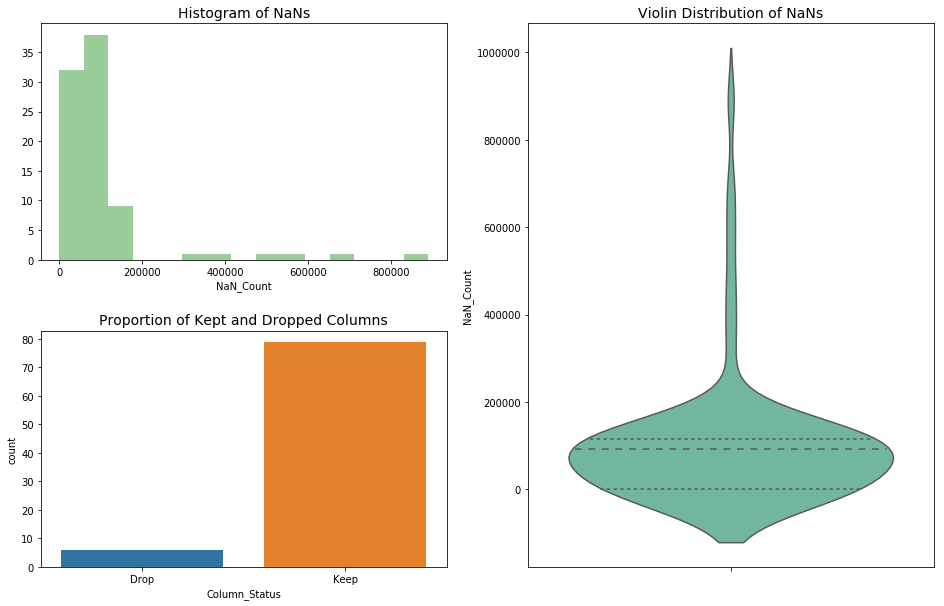

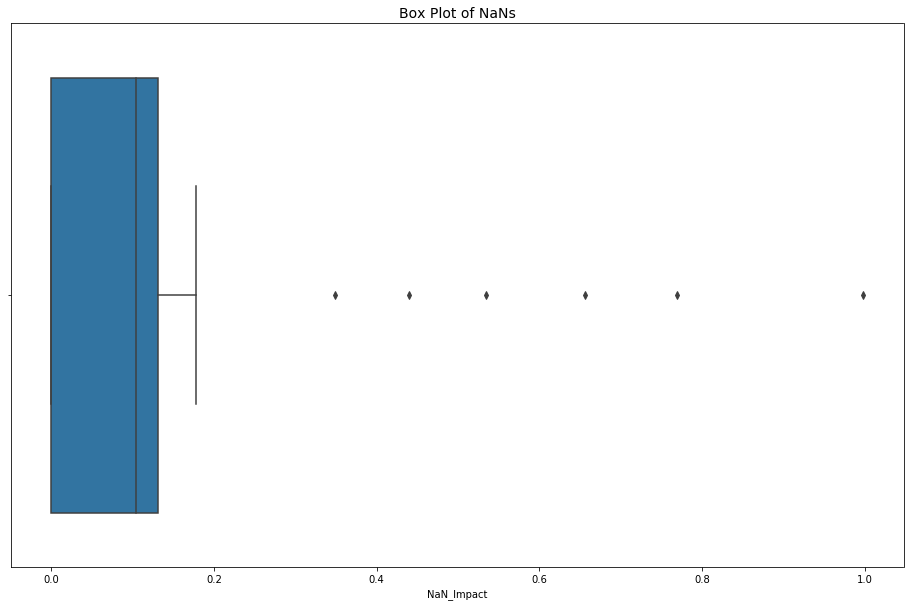

Results from Reduction:
	Outliers with less than -46,670.0 or more than 232,966.0 null count were removed.
	Outliers with less than -5.24% or more than 26.14% impact were removed.
	There is a total of 891,221 rows and 85 columns.
	6 column was/were removed.



,Dropped List
0,AGER_TYP
1,GEBURTSJAHR
2,TITEL_KZ
3,ALTER_HH
4,KK_KUNDENTYP
5,KBA05_BAUMAX


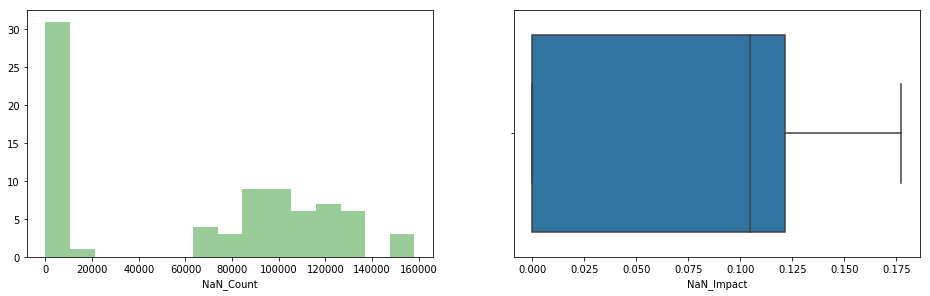

------------------------------------------------------------------------------------------------------------------------------------------------------


In [32]:
# removing outliers
frame_ager_type_subset = azdias[['ALTERSKATEGORIE_GROB', 'AGER_TYP']]
azdias = remove_outliers(azdias)

In [33]:
consistent_removal = [x for x in azdias_columns if x not in azdias.columns]

In [34]:
pd.options.display.max_rows = 100
data_dict_coldesc = pd.merge(dict_colnames, dict_coldesc, on='key', how='left')

# columns kept
data_dict_coldesc['Kept'] = data_dict_coldesc.ColumnName.apply(lambda x: x in azdias.columns)

# adding data types
data_dict_coldesc = data_dict_coldesc.merge(feat_info.loc[:, ['attribute', 'type']], 
                                            left_on='ColumnName', 
                                            right_on='attribute', 
                                            how='left')\
                                     .drop('attribute', axis=1)

# adding column type for columns kept
display_html('Columns Kept for Analysis with Description')
data_dict_coldesc.loc[data_dict_coldesc.Kept == True, :]
        

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
1,1.2,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,True,ordinal
2,1.3,ANREDE_KZ,KZ,Gender,True,categorical
3,1.4,CJT_GESAMTTYP,GESAMTTYP,Customer-Journey-Typology: preferred informati...,True,categorical
4,1.5,FINANZ_MINIMALIST,MINIMALIST,Financial typology,True,ordinal
5,1.5,FINANZ_SPARER,SPARER,Financial typology,True,ordinal
6,1.5,FINANZ_VORSORGER,VORSORGER,Financial typology,True,ordinal
7,1.5,FINANZ_ANLEGER,ANLEGER,Financial typology,True,ordinal
8,1.5,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,True,ordinal
9,1.5,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,True,ordinal
10,1.6,FINANZTYP,FINANZTYP,Most descriptive financial type for individual,True,categorical


In [35]:
# showing columns removed
display_html('Columns Removed from Analysis with Description')
df_removed_cols = data_dict_coldesc.loc[~data_dict_coldesc.Kept == True, ['key', 'ColumnName', 'ColNameDescription']]
df_removed_cols

,key,ColumnName,ColNameDescription
0,1.1,AGER_TYP,Best-ager typology
11,1.7,GEBURTSJAHR,Year of birth
40,1.23,TITEL_KZ,Academic title flag
43,2.1,ALTER_HH,Birthdate of head of household
47,2.5,KK_KUNDENTYP,Consumer pattern over past 12 months
64,5.5,KBA05_BAUMAX,Most common building type within the microcell


In [36]:
# removed data in context
data_dict_view.loc[data_dict_view.key.isin(df_removed_cols.key), :]

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
0,1.1,-1,unknown,AGER_TYP,TYP,Best-ager typology,NaN
1,1.1,0,no classification possible,AGER_TYP,TYP,Best-ager typology,NaN
2,1.1,1,passive elderly,AGER_TYP,TYP,Best-ager typology,NaN
3,1.1,2,cultural elderly,AGER_TYP,TYP,Best-ager typology,NaN
4,1.1,3,experience-driven elderly,AGER_TYP,TYP,Best-ager typology,NaN
332,1.23,-1,unknown,TITEL_KZ,KZ,Academic title flag,NaN
333,1.23,0,unknown,TITEL_KZ,KZ,Academic title flag,NaN
334,1.23,1,Dr.,TITEL_KZ,KZ,Academic title flag,NaN
335,1.23,2,Dr. Dr.,TITEL_KZ,KZ,Academic title flag,NaN
336,1.23,3,Prof.,TITEL_KZ,KZ,Academic title flag,NaN


In [37]:
def remap_keys_to_data_dictionary(dataframe, col_subset):
    """
    Maps the feature numbers (keys) with the respective key in the parsed data dictionary.
    It allows to see in a dataframe the respective key descriptions of the features.
    For example,
        LP_LEBENSPHASE_FEIN value 9 equals single independent person
        1.11	9	single independent persons	LP_LEBENSPHASE_FEIN
        
    Parameters
    ----------
    dataframe : the dataframe with the key values to map to the data dictionary
    col_subset : the subset to map and return as a sliced dataframe
        
    Returns
    -------
    maped and sliced dataframe with words instead of keys for quick interpretation
    """
    
    # remaping keys to valuemaps
    data_dict_subset = ['value_key', 'ValueMaps']  
    
    if len(col_subset) >=15:
        print('Sample Mode')
        dataframe = dataframe.sample(n=30, random_state=42)
        
    # create container
    dataframe_return = pd.DataFrame()
    
    # for each colum passed
    for i, column in enumerate(col_subset):
        
        # provide value_key and ValueMaps of the column
        dataframe_dict_original = data_dict_view.loc[data_dict_view\
                                                        .ColumnName \
                                                        == column, 
                                                        data_dict_subset]
        
        # convert value_key to float to match passed dataframe
        dataframe_dict = dataframe_dict_original\
                                .apply(pd.to_numeric, 
                                       errors='ignore', 
                                       downcast='float')  
        
        try: # merging on floats
            # merge the passed columns from value to text, just keep text
            dataframe_merge = pd.merge(dataframe.loc[:, [column]],
                                   dataframe_dict,
                                   left_on=column,
                                   right_on='value_key',
                                   how='left'
                             ).drop(['value_key', column], axis=1)\
                              .rename(columns={'ValueMaps': column})
            
            # if merge does not bring values, keep original value key
            if dataframe_merge[column].count() == 0:
                dataframe_merge = dataframe[column].reset_index(drop=True)            
                
        except: # merging on ints
            dataframe_merge = pd.merge(dataframe.loc[:, [column]],
                                   dataframe_dict_original,
                                   left_on=column,
                                   right_on='value_key',
                                   how='left'
                             ).drop(['value_key', column], axis=1)\
                              .rename(columns={'ValueMaps': column})
        
        # if more than two col_subset is passed, concat them into one dataframe
        dataframe_return = pd.concat([dataframe_return, dataframe_merge], axis=1)        
        
        # if dataframe_return returns nothing 
        if (dataframe_return[column].count() == 0):
            display(dataframe[[column]].reset_index(drop=True))

    return dataframe_return  

In [38]:
display_html('Exploring AGER_TYP using ALTERSKATEGORIE_GROB')
col_subset = ['ALTERSKATEGORIE_GROB', 'AGER_TYP']
ager_typ = remap_keys_to_data_dictionary(frame_ager_type_subset, col_subset)
ager_typ.loc[~ager_typ.AGER_TYP.isna(), col_subset].groupby(col_subset).size()

ALTERSKATEGORIE_GROB  AGER_TYP                 
30 - 45 years old     cultural elderly               110
                      experience-driven elderly     5641
                      passive elderly                178
46 - 60 years old     cultural elderly             24198
                      experience-driven elderly    15921
                      passive elderly              27743
< 30 years old        cultural elderly               823
                      experience-driven elderly     4906
                      passive elderly               1058
> 60 years old        cultural elderly             73189
                      experience-driven elderly      339
                      passive elderly              50728
dtype: int64

## 3. Ptterns in Missing Values

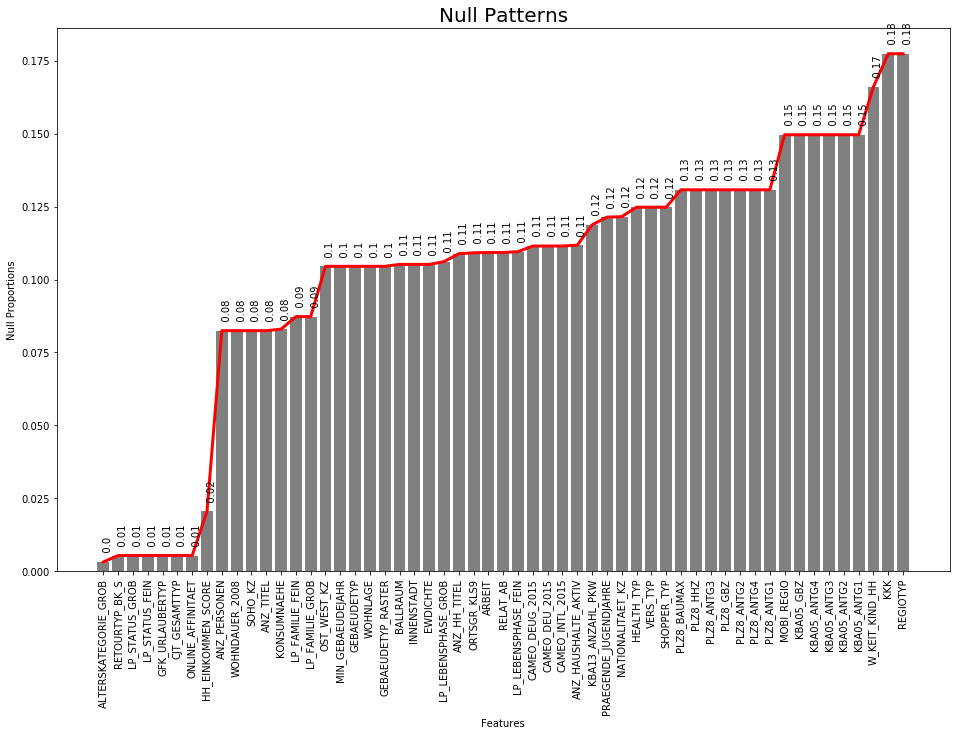

In [39]:
null_patterns\
    = pd.DataFrame(azdias.isna().sum() / azdias.shape[0], 
             columns=['Nulls']).query("Nulls > 0")\
    .sort_values("Nulls")
#null_patterns.plot(kind='bar', figsize=(16, 10))

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
plt.bar(null_patterns.index, null_patterns.Nulls, color='grey')
plt.plot(null_patterns.index, null_patterns.Nulls, color='r', linewidth=3)
plt.title('Null Patterns', size=20)
plt.ylabel('Null Proportions')
plt.xlabel('Features')
plt.xticks(rotation=90)

for i, j in zip(null_patterns.index, null_patterns.Nulls):
    ax.annotate('   '+str(round(j, 2)), xy=(i, j), rotation=90, va='bottom')

plt.show()

In [40]:
null_patterns['Group'] = null_patterns.rank(method='dense').astype(int)
null_patterns\
    .merge(data_dict_coldesc[['ColumnName', 'ColNameDescription', 'type', 'key']], 
           left_index=True, right_on='ColumnName', how='left')

,Nulls,Group,ColumnName,ColNameDescription,type,key
1,0.0032,1,ALTERSKATEGORIE_GROB,Estimated age based on given name analysis,ordinal,1.2
23,0.0054,2,RETOURTYP_BK_S,Return type,ordinal,1.19
20,0.0054,2,LP_STATUS_GROB,Social status,categorical,1.16
19,0.0054,2,LP_STATUS_FEIN,Social status,categorical,1.15
12,0.0054,2,GFK_URLAUBERTYP,Vacation habits,categorical,1.8
3,0.0054,2,CJT_GESAMTTYP,Customer-Journey-Typology: preferred informati...,categorical,1.4
72,0.0054,2,ONLINE_AFFINITAET,Online affinity,ordinal,7.4
46,0.0206,3,HH_EINKOMMEN_SCORE,Estimated household net income,ordinal,2.4
44,0.0825,4,ANZ_PERSONEN,Number of adults in household,numeric,2.2
49,0.0825,4,WOHNDAUER_2008,Length of residence,ordinal,2.7


In [41]:
dict_value_keys.query("key == ['8.7', '8.6']")

,key,value_key,ValueMaps
434,8.6,-1,unknown
435,8.6,0,unknown
436,8.6,1,mainly 1-2 family homes
437,8.6,2,mainly 3-5 family homes
438,8.6,3,mainly 6-10 family homes
439,8.6,4,mainly 10+ family homes
440,8.6,5,mainly business buildings
441,8.7,-1,unknown
442,8.7,1,less than 130 households
443,8.7,2,131-299 households


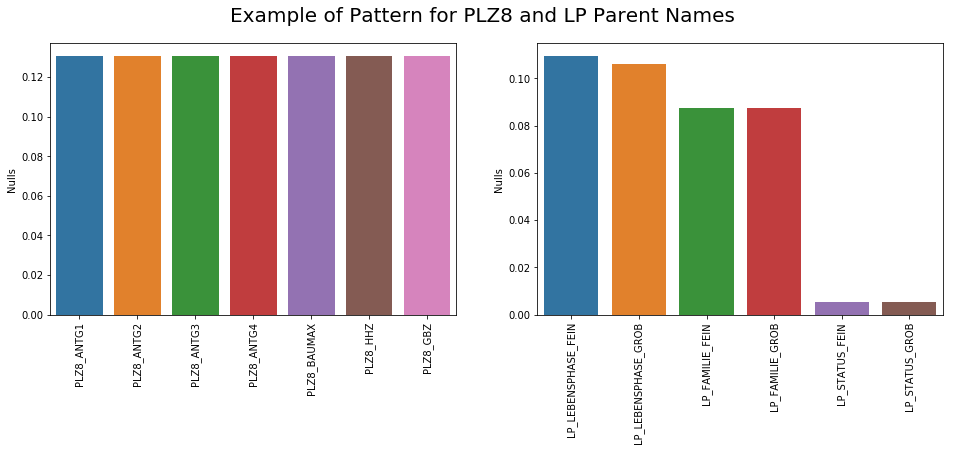

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 5))
ax0, ax1 = ax[0], ax[1]

PLZ8 = pd.DataFrame(azdias.loc[azdias.PLZ8_BAUMAX.isna(), :]\
                     .filter(regex='^'+'PL', axis=1).isna().sum(), 
                 columns=['Nulls'])
LP = pd.DataFrame(azdias.loc[azdias.LP_LEBENSPHASE_FEIN.isna(), :]\
                     .filter(regex='^'+'LP', axis=1).isna().sum(), 
                 columns=['Nulls'])

plt.suptitle('Example of Pattern for PLZ8 and LP Parent Names', size=20)
ax0.tick_params(labelrotation=90, axis='x')
sns.barplot(PLZ8.index, PLZ8.Nulls/azdias.shape[0], ax=ax0)
ax1.tick_params(labelrotation=90, axis='x')
sns.barplot(LP.index, LP.Nulls/azdias.shape[0], ax=ax1)
plt.show()

In [43]:
LP.Nulls/azdias.shape[0]

LP_LEBENSPHASE_FEIN   0.1095
LP_LEBENSPHASE_GROB   0.1061
LP_FAMILIE_FEIN       0.0873
LP_FAMILIE_GROB       0.0873
LP_STATUS_FEIN        0.0054
LP_STATUS_GROB        0.0054
Name: Nulls, dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

>Missing data on a column basis after combining what was already NaN from the raw csv data and the mappings in the information data csv was up to 99.76% and at least 0.32%. Mostly NaN values came from mapping missing or unknwon values to the feat info dataset, which shows the numerical maps of missing or unknown values.

>Most of the missing data relates to academic titles, birthdates, building types and a colum appearing to describe some elderly personal character typology. The data AGER_TYP in the  column seems to not describe what was intended since people younger than 30 are labeled as elderly. They might have stopped getting this data at some point.

> The columns droped were 
['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']
 
 > The retained columns have patterns in the number of missing values. For example, all PLZ8s have 13% values missing. These are representing building type, quantity, and number people in household.  The LP parent name follows a same pattern for 2 of its features. It seems that LP_LEBENSPHASE_FEIN is the feautre with the most Null values for parent name LP. And all other features under the same parent name share the same index for nulls with their own proportions. 

In [44]:
try: 
    nan_descript.Unk_Missing = nan_descript.Unk_Missing.map('{:0,.2f}'.format)
    nan_descript.Original_Nan = nan_descript.Original_Nan.map('{:0,.2f}'.format)
    nan_descript.Nan_All = nan_descript.Nan_All.map('{:0,.2f}'.format)
except:pass

nan_descript

,Nan_All,Inpact_Percent_All,Original_Nan,Inpact_Percent_Ori,Unk_Missing,Inpact_Percent_Parsed
count,61.00,61.0000,61.00,61.0000,61.00,61.0000
mean,"137,277.52",0.1540,"80,276.03",0.0901,"57,001.49",0.0640
std,"157,099.50",0.1763,"82,088.45",0.0921,"150,405.21",0.1688
min,"2,881.00",0.0032,0.00,0.0000,0.00,0.0000
25%,"93,148.00",0.1045,"4,854.00",0.0054,0.00,0.0000
50%,"99,352.00",0.1115,"93,148.00",0.1045,0.00,0.0000
75%,"116,515.00",0.1307,"116,515.00",0.1307,"36,868.00",0.0414
max,"889,061.00",0.9976,"584,612.00",0.6560,"815,562.00",0.9151


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [45]:
def get_good_bad_targets(dataframe):
 
    count_null = pd.concat([dataframe.isna().sum(), dataframe.count()], 
                     axis=1).rename(columns={0:'Null', 1:'Count'})
    
    df_count = count_null.query("Count/Null > .1")    
    sty_count = df_count.style\
        .set_table_attributes("style='display:inline'")\
        .set_caption("Table with Values")

    df_null = count_null.query("Count/Null <= .1")    
    sty_null = df_null.style\
        .set_table_attributes("style='display:inline'")\
        .set_caption("Table with No or Few Values")
    
    displayh(sty_count._repr_html_() + sty_null._repr_html_() , raw=True)
    column_sample = random.sample(list(df_count.index), 8)
    
    return column_sample

In [46]:
def plot_good_bad(good_data, bad_data, target):
    
    fig = plt.figure(figsize=(16, 30))
    subplots = [good_data.loc[:, target], bad_data.loc[:, target]]
    plot_id = 1

    display_html('Good Set Vs. Bad Set Data Distributions', 20)
    for i, column in enumerate(target, 1):    
        for j, subplot in enumerate(subplots):        
            fig.add_subplot(8, 2, plot_id)
            sns.countplot(x = column, data=subplot)        
            plot_id += 1

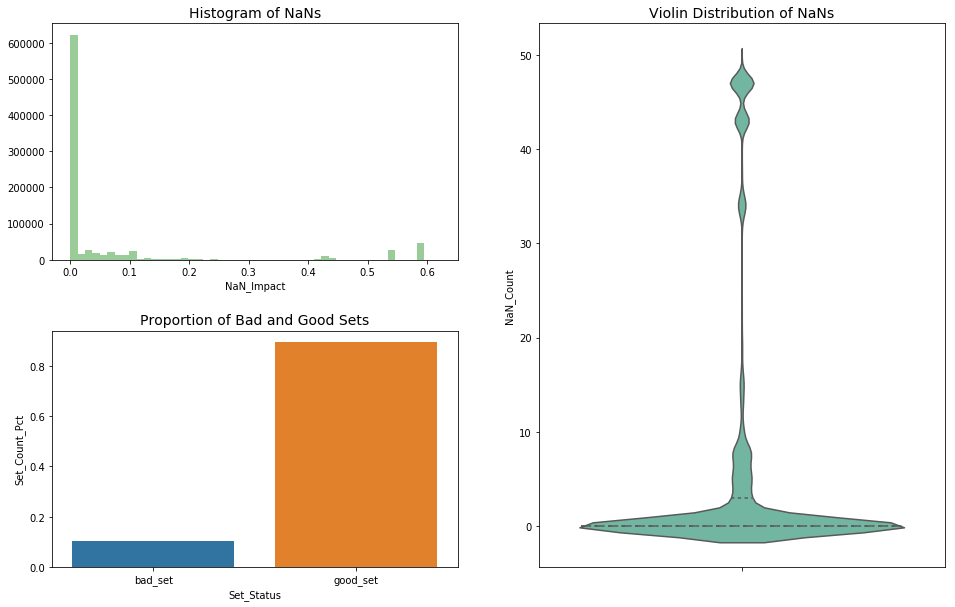

,NaN_Count,NaN_Impact
count,891221.0000,891221.0000
mean,5.6499,0.0715
std,13.2347,0.1675
min,0.0000,0.0000
25%,0.0000,0.0000
50%,0.0000,0.0000
75%,3.0000,0.0380
max,49.0000,0.6203


Skewness:


NaN_Count   2.4493
dtype: float64

,Set_Status,Set_Count,Set_Count_Pct
0,bad_set,93151,0.1045
1,good_set,798070,0.8955


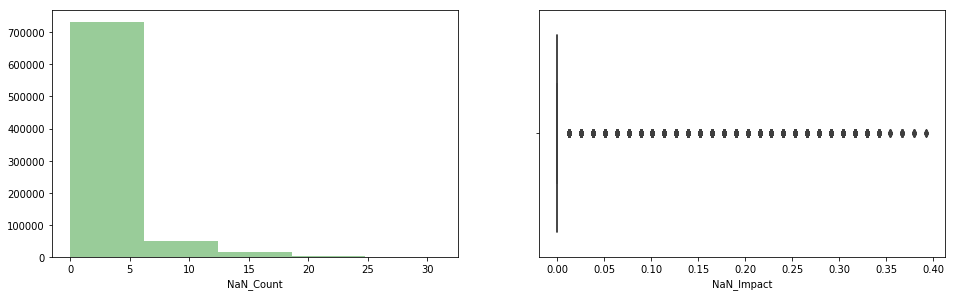

------------------------------------------------------------------------------------------------------------------------------------------------------


In [47]:
azdias_good, azdias_bad = separate_row_sets(azdias, col_treshold=.40)

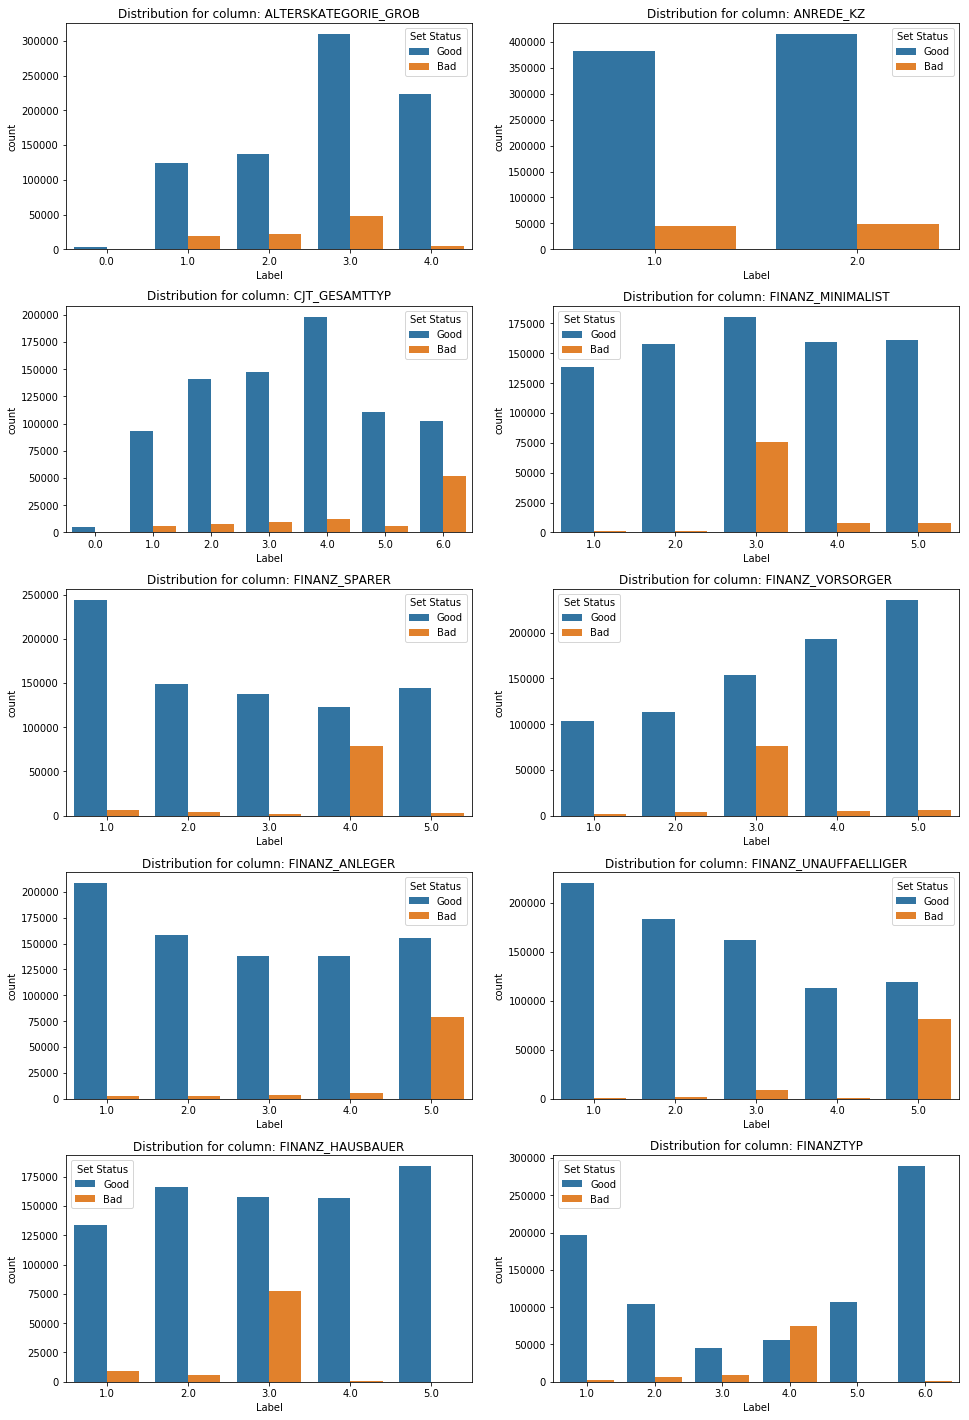

In [48]:
azdias_bad_melt = azdias_bad.iloc[:, :10].melt(var_name='Feature', value_name='Label')
azdias_bad_melt['Set Status'] = 'Bad'
azdias_good_melt = azdias_good.iloc[:, :10].melt(var_name='Feature', value_name='Label')
azdias_good_melt['Set Status'] = 'Good'
xx = pd.concat([azdias_good_melt, azdias_bad_melt]).fillna(0)
plt.figure(figsize=(16, 25))
for i, col in enumerate(xx.Feature.unique()[:10]):    
    plt.subplot(5, 2, i+1)
    sns.countplot(x='Label', hue='Set Status', data=xx.loc[xx.Feature==col, :])
    plt.title(f'Distribution for column: {col}')
    plt.subplots_adjust(hspace=.25)

In [49]:
# arbitrary target columns
target_columns = ['ANREDE_KZ', 'PLZ8_BAUMAX', 'GFK_URLAUBERTYP', 'WOHNLAGE',
       'KBA05_ANTG2', 'RETOURTYP_BK_S', 'FINANZ_ANLEGER',
       'PRAEGENDE_JUGENDJAHRE']

,Null,Count
ALTERSKATEGORIE_GROB,78,93073
ANREDE_KZ,0,93151
CJT_GESAMTTYP,103,93048
FINANZ_MINIMALIST,0,93151
FINANZ_SPARER,0,93151
FINANZ_VORSORGER,0,93151
FINANZ_ANLEGER,0,93151
FINANZ_UNAUFFAELLIGER,0,93151
FINANZ_HAUSBAUER,0,93151
FINANZTYP,0,93151


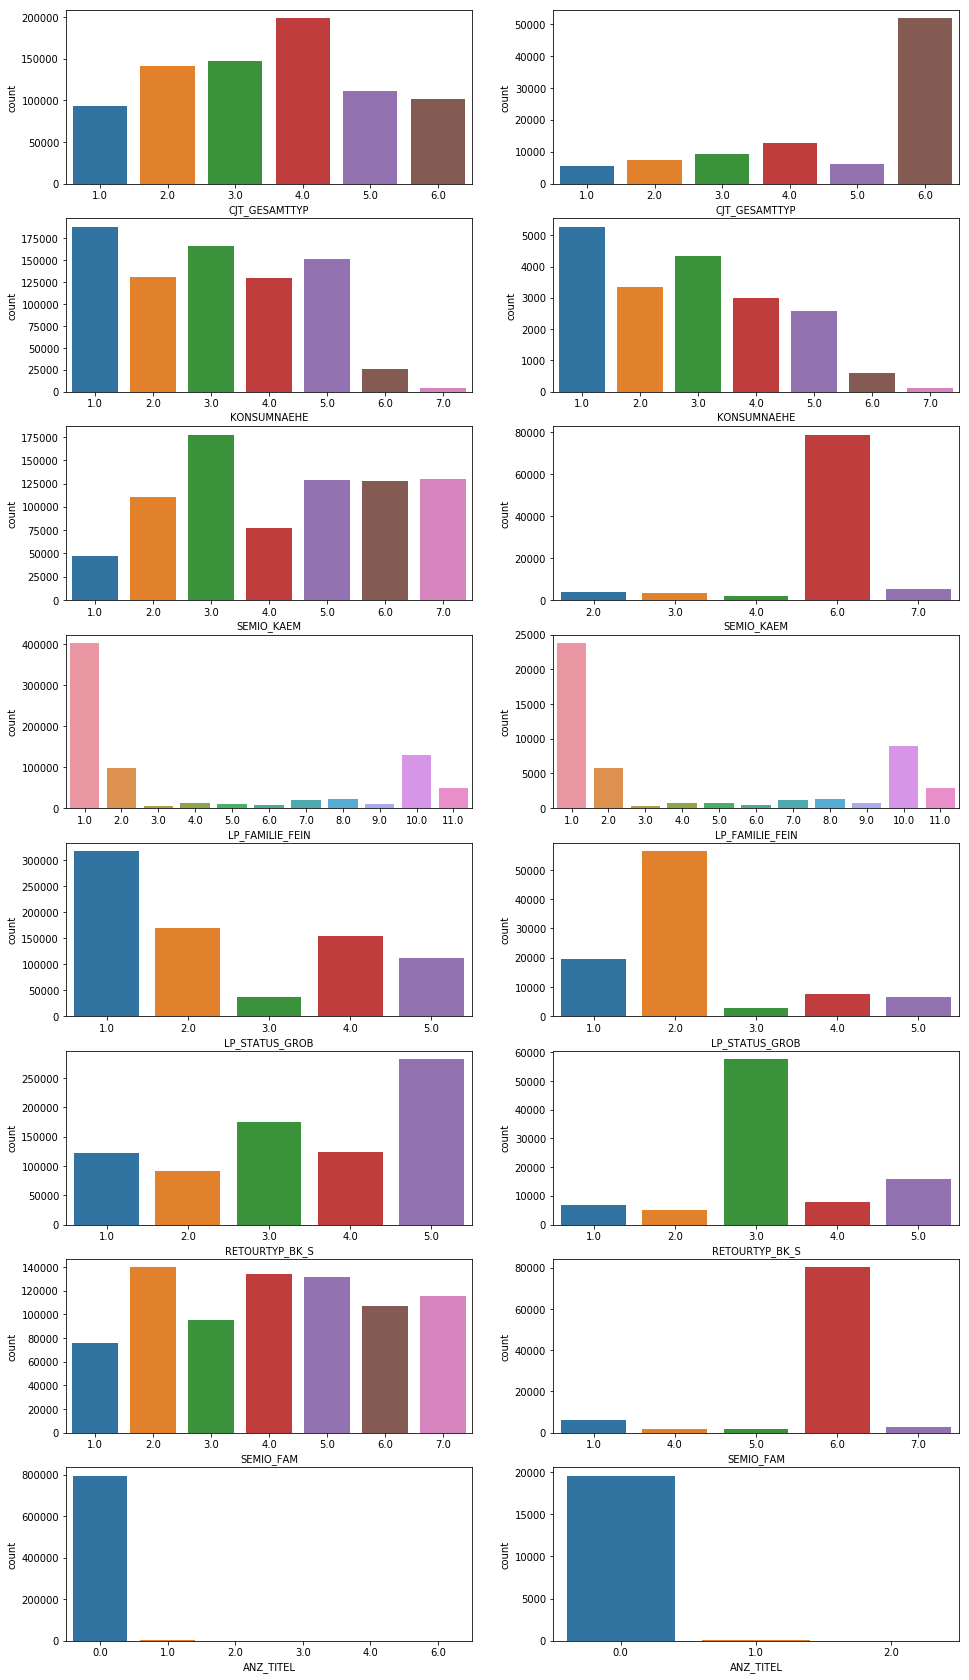

In [50]:
target_columns = get_good_bad_targets(azdias_bad)
plot_good_bad(azdias_good, azdias_bad, target_columns)

In [51]:
data_dict_view.query("ColumnName=='KBA05_ANTG2'")

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
475,5.2,-1,unknown,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
476,5.2,0,no 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
477,5.2,1,lower share of 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
478,5.2,2,average share of 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
479,5.2,3,high share of 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
480,5.2,4,very high share of 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN


In [52]:
#display_code()

#### Discussion 1.1.3: Assess Missing Data in Each Row

> Rows where removed at a 40% treshold. The reduced rows where separated from the good dataset. The distributions between the good set and the bad set is not significantly different for some columns, but for other columns, it was drastically different as shown in the graphs above. For this reason, I decided to add the bad set to the cluster proportions at the end.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [53]:
# How many features are there of each data type?
display_html('Features per Datatype')
pd.DataFrame(feat_info.groupby('type').size()).reset_index().rename(columns={0:'col_count'})

,type,col_count
0,categorical,21
1,interval,1
2,mixed,7
3,numeric,7
4,ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

### 1. Validating Sets
---

In [54]:
print(
    'Original Data:', azdias_original_shape,
    '\nReduced Column Data:', azdias.shape,
    '\nReduced Rows Data:', azdias_good.shape,
    '\nBad Row Data:', azdias_bad.shape,
    '\nGood + Bad Row Data:', azdias_good.shape[0] + azdias_bad.shape[0])

Original Data: (891221, 85) 
Reduced Column Data: (891221, 79) 
Reduced Rows Data: (798070, 79) 
Bad Row Data: (93151, 79) 
Good + Bad Row Data: 891221


### 2. Assessing Categorical Data to Encode
---

In [55]:
display_html('Categorical Columns to Encode')
categorical_columns = data_dict_coldesc.query("type == 'categorical' and Kept == True")
display(categorical_columns)

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
2,1.3,ANREDE_KZ,KZ,Gender,True,categorical
3,1.4,CJT_GESAMTTYP,GESAMTTYP,Customer-Journey-Typology: preferred informati...,True,categorical
10,1.6,FINANZTYP,FINANZTYP,Most descriptive financial type for individual,True,categorical
12,1.8,GFK_URLAUBERTYP,URLAUBERTYP,Vacation habits,True,categorical
13,1.9,GREEN_AVANTGARDE,AVANTGARDE,Membership in environmental sustainability as ...,True,categorical
17,1.13,LP_FAMILIE_FEIN,FAMILIE_FEIN,Family type,True,categorical
18,1.14,LP_FAMILIE_GROB,FAMILIE_GROB,Family type,True,categorical
19,1.15,LP_STATUS_FEIN,STATUS_FEIN,Social status,True,categorical
20,1.16,LP_STATUS_GROB,STATUS_GROB,Social status,True,categorical
21,1.17,NATIONALITAET_KZ,KZ,Nationality based on given name analysis,True,categorical


### 3. Get Categorical and Encode
---

In [56]:
azdias_unencoded, azdias_toencode, dropped_columns = get_categorical(azdias_good, show=True)

,data_type,unique_count
ANREDE_KZ,float64,2
OST_WEST_KZ,object,2
VERS_TYP,float64,2
SOHO_KZ,float64,2
GREEN_AVANTGARDE,float64,2
NATIONALITAET_KZ,float64,3
SHOPPER_TYP,float64,4
LP_STATUS_GROB,float64,5
LP_FAMILIE_GROB,float64,5
FINANZTYP,float64,6


,data_type,unique_count
OST_WEST_KZ,object,2
NATIONALITAET_KZ,float64,3
SHOPPER_TYP,float64,4
LP_STATUS_GROB,float64,5
LP_FAMILIE_GROB,float64,5
FINANZTYP,float64,6
ZABEOTYP,float64,6
CJT_GESAMTTYP,float64,6
GEBAEUDETYP,float64,7
CAMEO_DEUG_2015,object,9


There are 18 categorical variables. 
There are 14 categories with greater than 2 unique or non-numeric values.
14 columns will be encoded.
The dataframe passed had 79 columns in total.
There will be 65 unencoded columns.


In [57]:
azdias_encoded, encoder = set_encoding(azdias_toencode, show=True)
display_html('Data Encoded:')
azdias_encoded.head(30)

Endoding: OST_WEST_KZ
Endoding: NATIONALITAET_KZ
Endoding: SHOPPER_TYP
Endoding: LP_STATUS_GROB
Endoding: LP_FAMILIE_GROB
Endoding: FINANZTYP
Endoding: ZABEOTYP
Endoding: CJT_GESAMTTYP
Endoding: GEBAEUDETYP
Endoding: CAMEO_DEUG_2015
Endoding: LP_STATUS_FEIN
Endoding: LP_FAMILIE_FEIN
Endoding: GFK_URLAUBERTYP
Endoding: CAMEO_DEU_2015


,ColumnName,Nulls,Type,encoding,NullLabel
0,OST_WEST_KZ,0,object,"[O, W]",OST_WEST_KZ_0
1,NATIONALITAET_KZ,33926,float64,"[0, 1, 2, 3]",NATIONALITAET_KZ_0
2,SHOPPER_TYP,36729,float64,"[0, 1, 2, 3]",SHOPPER_TYP_0
3,LP_STATUS_GROB,4751,float64,"[0, 1, 2, 3, 4, 5]",LP_STATUS_GROB_0
4,LP_FAMILIE_GROB,31477,float64,"[0, 1, 2, 3, 4, 5]",LP_FAMILIE_GROB_0
5,FINANZTYP,0,float64,"[1, 2, 3, 4, 5, 6]",FINANZTYP_0
6,ZABEOTYP,0,float64,"[1, 2, 3, 4, 5, 6]",ZABEOTYP_0
7,CJT_GESAMTTYP,4751,float64,"[0, 1, 2, 3, 4, 5, 6]",CJT_GESAMTTYP_0
8,GEBAEUDETYP,0,float64,"[1, 2, 3, 4, 5, 6, 8]",GEBAEUDETYP_0
9,CAMEO_DEUG_2015,6202,object,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",CAMEO_DEUG_2015_0


,OST_WEST_KZ_0,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,LP_STATUS_GROB_0,...,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44
0,1,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### 4. Validating Encodied Nulls Re-set to 0
---

In [58]:
display_html('Validation on NATIONALITAET_KZ Where NATIONALITAET_KZ is Null')
null_valid = azdias_encoded[['NATIONALITAET_KZ_0', 
                             'NATIONALITAET_KZ_1', 
                             'NATIONALITAET_KZ_2', 
                             'NATIONALITAET_KZ_3']]\
                .merge(azdias_good[['NATIONALITAET_KZ']]\
                .reset_index(drop=True), left_index=True, right_index=True)\
                .query("NATIONALITAET_KZ != NATIONALITAET_KZ")
display(null_valid.head())
print('Non-null values in the frame: \n%s' % null_valid.sum())

,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,NATIONALITAET_KZ
28,0,0,0,0,nan
49,0,0,0,0,nan
71,0,0,0,0,nan
109,0,0,0,0,nan
125,0,0,0,0,nan


Non-null values in the frame: 
NATIONALITAET_KZ_0   0.0000
NATIONALITAET_KZ_1   0.0000
NATIONALITAET_KZ_2   0.0000
NATIONALITAET_KZ_3   0.0000
NATIONALITAET_KZ     0.0000
dtype: float64


### 5. Combining Unencoded with Encoded Columns
---

In [59]:
azdias_toencode.index

RangeIndex(start=0, stop=798070, step=1)

In [60]:
azdias_encoded.index

RangeIndex(start=0, stop=798070, step=1)

In [61]:
azdias_unencoded.index

RangeIndex(start=0, stop=798070, step=1)

In [62]:
print(f'Azdias has {len(azdias_original_columns)} columns.'+\
      f'\nEncoding created {len(azdias_encoded.columns)} columns.'+\
      f'Azdias was reduced to {len(azdias_good.columns)} columns')

# combining dataframes
azdias = pd.concat([azdias_unencoded, azdias_encoded], axis=1)

print(f'Azdias total columns are {len(azdias.columns)}'+\
      f'\n\nAzdias encoding is completed. {len(dropped_columns)}'+\
       ' repeated columns were dropped due to encoding.'+\
       '\nAzdias total columns before drop of repeated columns '+\
      f'after feature engeniering {str(azdias.shape[1] + len(dropped_columns))}')


Azdias has 85 columns.
Encoding created 138 columns.Azdias was reduced to 79 columns
Azdias total columns are 203

Azdias encoding is completed. 14 repeated columns were dropped due to encoding.
Azdias total columns before drop of repeated columns after feature engeniering 217


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

> After finding all categorical and mixed variables, I found several of them meeting unique value counts of 2, which does not require encoding. OST_WEST_KZ had 2 categories; however, it was an object. Thus, I flag it to be encoded. The following list needed to be encoded: ['OST_WEST_KZ', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB',
       'LP_FAMILIE_GROB', 'FINANZTYP', 'ZABEOTYP', 'CJT_GESAMTTYP',
       'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN',
       'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']
       
>I used the LabelBinarizer to encode since it does Label Encoding and Hot Encoding at the same time. But then I encounter errors due to Null values. Since there were not 0 labels left as they where all converted to numpy nan, I filled null values with 0 to be able to run the encoder. Two categorical/mixed colums did not have any nulls: FINANZTYP and ZABEOTYP.

> After encoding the categorical values. I re-encoded the 0 labels for Null values that where encoded as 1 back to 0 using indexes of the original data. Null values where validated by comparing the sum of null values on the original data vs the encoded data and compared again at a row level using the original data as well.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [63]:
def investigate_two(feature01, feature02):    
    display(data_dict_coldesc.query("ColumnName == '{}' \
                         or ColumnName == '{}'".format(feature01, feature02)))
    display(pd.DataFrame(feature_eng.groupby([feature01, feature02]).size()).rename(columns={0:'count'}))
    
def join_two_features(dataframe, feature01, feature02, new_feature_name='rename'):
    """
    it uses the remap_keys_to_data_dictionary to map the numbers to the respective 
    description in the data dictionary provided
    
    Parameters
    ----------
    dataframe :  the dataframe with the key values to map to the data dictionary
    feature01 : the name of the first feature to join
    feature02 : the name of the second feature to join
    new_feature_name : the name of the new feature
    
    Returns
    -------
    """

    feature_eng = remap_keys_to_data_dictionary(dataframe, [feature01, feature02])
    
    # example of original numerical label
    display_html('Input Dataframe')        
    display(dataframe[[feature01, feature02]].head())
        
    # example of mapped numerical labels to 
    # respective description in data dictionary 
    display_html('Mapped Dataframe')
    display(feature_eng.head())
    
    # it joins the two features with descriptions instead of numbers for quick analysis
    new_feature = feature_eng.apply(lambda x: str(x[feature01]) + ' - ' + str(x[feature02]), axis=1)
    
    return pd.DataFrame(new_feature).rename(columns={0:new_feature_name})

### 1. Validating Data Progression
---

In [64]:
print(f'Original Azdias Shape: {azdias_original_shape}'+
      f'\nEncoded Frame Shape: {azdias_encoded.shape}'+
      f'\nGood set Shape: {azdias_good.shape}'+
      f'\nTo-encode Categorial Shape: {azdias_toencode.shape}'+
      f'\nUencoded Shape: {azdias_unencoded.shape}'+
      f'\nUencoded + Encoded Shape: {azdias.shape}')

Original Azdias Shape: (891221, 85)
Encoded Frame Shape: (798070, 138)
Good set Shape: (798070, 79)
To-encode Categorial Shape: (798070, 14)
Uencoded Shape: (798070, 65)
Uencoded + Encoded Shape: (798070, 203)


### 2. Assessing Mixed-Type Features
---

In [65]:
display_html('Mixed Type Features')
data_dict_coldesc.query("type == 'mixed'")

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
15,1.11,LP_LEBENSPHASE_FEIN,LEBENSPHASE_FEIN,Life stage,True,mixed
16,1.12,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,True,mixed
22,1.18,PRAEGENDE_JUGENDJAHRE,JUGENDJAHRE,Dominating movement of person's youth (avantga...,True,mixed
56,3.7,WOHNLAGE,WOHNLAGE,Neighborhood quality (or rural flag),True,mixed
59,4.3,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,True,mixed
64,5.5,KBA05_BAUMAX,BAUMAX,Most common building type within the microcell,False,mixed
79,8.6,PLZ8_BAUMAX,BAUMAX,Most common building type within the PLZ8 region,True,mixed


### 3. Remaping Value Keys to Data Dictionary and Investigating/Engineering New Features
---

In [66]:
#pd.options.display.max_rows = 20
col_subset = ['PRAEGENDE_JUGENDJAHRE', 'RELAT_AB']
column_names = list(data_dict_coldesc.query("type == 'mixed' and Kept == True").ColumnName)
colum_additions = list(data_dict_coldesc.query("type != 'mixed' and ColNameDescription == 'Financial typology'").ColumnName)
feature_eng = remap_keys_to_data_dictionary(azdias, column_names + colum_additions)

In [67]:
feature_eng.head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER
0,single parent low-income earners,single parents,90s - digital media kids (Mainstream,poor neighborhood,Poorer Households - Pre-Family Couples & Singles,mainly 1-2 family homes,very high,very low,high,very low,low,very low
1,single average earners of younger age,single low-income and average earners of young...,90s - ecological awareness (Avantgarde,good neighborhood,Prosperous Households - Older Families & Matur...,mainly 1-2 family homes,very high,low,very high,high,average,very low
2,NaN,NaN,70s - family orientation (Mainstream,rural neighborhood,Wealthy Households - Young Couples With Children,mainly 1-2 family homes,low,high,very low,high,very high,high
3,average earners of higher age from multiperson...,low-income and average earners of higher age f...,70s - family orientation (Mainstream,average neighborhood,Less Affluent Households - Families With Schoo...,mainly 3-5 family homes,low,average,low,very high,average,high
4,single average earners at retirement age,single low-income and average earners of highe...,50s - economic miracle (Mainstream,rural neighborhood,Poorer Households - Older Families & Mature Co...,mainly 1-2 family homes,average,very high,very low,high,high,very low


#### 3.1 Ivestigating New Feature 01 

> Life Style of Neiborhood and type of Spending

In [68]:
display_html('Financial Typology Descriptions')
data_dict_coldesc.query("type != 'mixed' and ColNameDescription == 'Financial typology'")\
        .merge(dict_extra[['ColumnShortName', 'ColumnMeta']], on='ColumnShortName', how='left')

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type,ColumnMeta
0,1.5,FINANZ_MINIMALIST,MINIMALIST,Financial typology,True,ordinal,low financial interest
1,1.5,FINANZ_SPARER,SPARER,Financial typology,True,ordinal,money-saver
2,1.5,FINANZ_VORSORGER,VORSORGER,Financial typology,True,ordinal,be prepared
3,1.5,FINANZ_ANLEGER,ANLEGER,Financial typology,True,ordinal,investor
4,1.5,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,True,ordinal,inconspicuous
5,1.5,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,True,ordinal,home ownership


In [69]:
# reversing saving to spending
feature_eng['FINAZ_AUSGEBEN'] = feature_eng.FINANZ_SPARER.map({'very high':'very low', 
                                                               'high': 'low', 
                                                               'average':'average', 
                                                               'low':'high', 
                                                               'very low': 
                                                               'very high'})

# adding description to the SPARER data values
feature_eng.FINAZ_AUSGEBEN = feature_eng.FINAZ_AUSGEBEN.map(lambda x: x + ' money-spender')

In [70]:
display_html('Null Count of Mixed Type Data')
pd.DataFrame(feature_eng.isna().sum()).rename(columns={0:'Null Count'})\
    .sort_values('Null Count', ascending=False)

,Null Count
LP_LEBENSPHASE_FEIN,50242
LP_LEBENSPHASE_GROB,47349
PRAEGENDE_JUGENDJAHRE,28761
PLZ8_BAUMAX,23364
CAMEO_INTL_2015,6202
WOHNLAGE,0
FINANZ_MINIMALIST,0
FINANZ_SPARER,0
FINANZ_VORSORGER,0
FINANZ_ANLEGER,0


In [71]:
display_html('Investigating New Feature in Grouping')
pd.DataFrame(feature_eng.groupby(['LP_LEBENSPHASE_FEIN', 'WOHNLAGE', 'FINAZ_AUSGEBEN'])\
             .size()).rename(columns={0:'count'}).sort_values('LP_LEBENSPHASE_FEIN')

count
LP_LEBENSPHASE_FEIN                      WOHNLAGE                           FINAZ_AUSGEBEN                
average earner couples of higher age     average neighborhood               average money-spender      300
                                         poor neighborhood                  very low money-spender    1106
                                         rural neighborhood                 average money-spender      535
                                                                            high money-spender          50
                                                                            low money-spender          735
                                                                            very high money-spender     11
                                                                            very low money-spender    2681
                                         very good neighborhood             high money-spender           5
                                                                            low money-spender          223
                                                                            very high money-spender      3
                                                                            very low money-spender     806
                                         very poor neighborhood             average money-spender       77
                                                                            high money-spender           3
                                                                            low money-spender          120
                                                                            very high money-spender      2
                                                                            very low money-spender     462
                                         poor neighborhood                  very high money-spender      6
                                                                            low money-spender          318
                                         very good neighborhood             average money-spender       72
                                         poor neighborhood                  average money-spender      152
                                                                            high money-spender           6
                                         average neighborhood               high money-spender          18
                                                                            low money-spender          736
                                                                            very high money-spender     10
                                                                            very low money-spender    3016
                                         good neighborhood                  average money-spender      120
                                                                            low money-spender          375
                                                                            very high money-spender      5
                                                                            high money-spender           6
                                         new building in rural neighborhood average money-spender       14
                                                                            high money-spender           2
                                                                            low money-spender           27
                                                                            very low money-spender     102
                                         no score calculated                average money-spender        1
                                                                            low money-spender           12
                                                                            very low money-spender      64
                                   

In [72]:
new_feature01 = pd.DataFrame(feature_eng.apply(lambda x: str(x['LP_LEBENSPHASE_FEIN'])\
                                  .replace('nan', 'Unknwon Life Stage') +\
                                  ' in ' +str(x['WOHNLAGE']) +\
                                  ' who are '+str(x['FINAZ_AUSGEBEN']), axis=1))\
                                  .rename(columns={0:'LifeStageQualitySpender'})
new_feature01.head()

,LifeStageQualitySpender
0,single parent low-income earners in poor neigh...
1,single average earners of younger age in good ...
2,Unknwon Life Stage in rural neighborhood who a...
3,average earners of higher age from multiperson...
4,single average earners at retirement age in ru...


In [73]:
def new_feature_hist(new_feature, bins=10):
    data = pd.DataFrame(new_feature.groupby(list(new_feature.columns)).size())\
                                 .reset_index().rename(columns={0:'count'})
    
    display_html('Counts Less Than 50')
    display(data.sort_values('count').query("count < 50").head(30))
    print('Encoder will create {:,} new features.\n'.format(data.shape[0]))
    
    plt.figure(figsize=(16, 10))
    warnings.simplefilter('ignore', category=FutureWarning)
    data['count'].hist(bins=bins)
    plt.title('{} Distribution'.format(list(new_feature.columns)[0]), size=20)
    plt.ylabel('frequency')
    plt.xlabel('category count')
    plt.show()

,LifeStageQualitySpender,count
355,homeowners of younger age from multiperson hou...,1
859,single average earners of younger age in very ...,1
849,single average earners of younger age in poor ...,1
845,single average earners of younger age in no sc...,1
842,single average earners of younger age in new b...,1
808,single average earners of middle age in no sco...,1
1307,top earner couples of higher age in very good ...,1
54,average earner couples of higher age in no sco...,1
765,single average earners of advanced age in new ...,1
749,single average earners at retirement age in ve...,1


Encoder will create 1,538 new features.



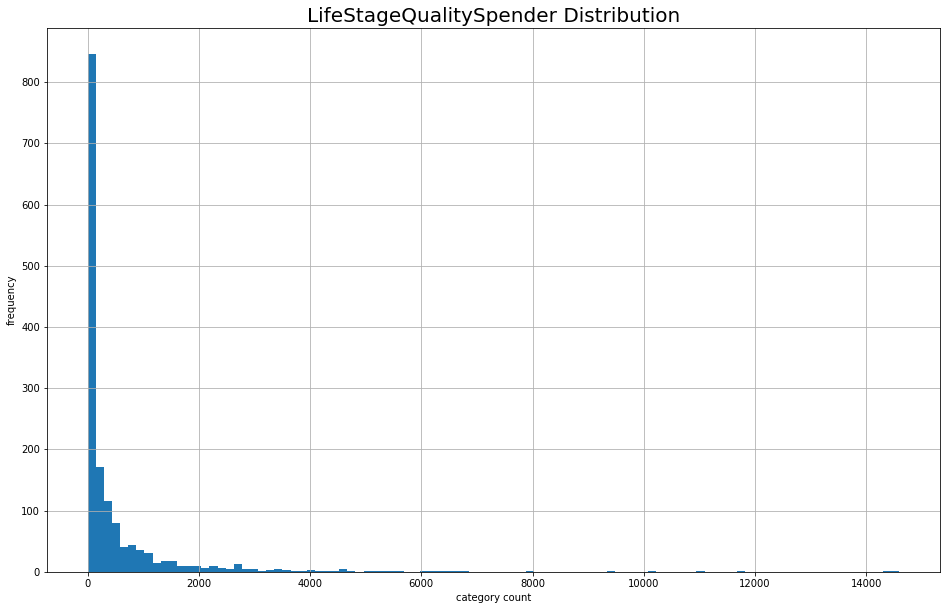

In [74]:
new_feature_hist(new_feature01, bins=100)

#### New Feature 01 Conclusion:
> Too much dimensionality and very skew to the right, which means highly sparse categories
---

#### 3.2 Investigating New Feature 02

In [75]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
investigate_two('CAMEO_INTL_2015', 'PLZ8_BAUMAX')

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
59,4.3,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,True,mixed
79,8.6,PLZ8_BAUMAX,BAUMAX,Most common building type within the PLZ8 region,True,mixed


count
CAMEO_INTL_2015                                    PLZ8_BAUMAX                     
Comfortable Households - Elders In Retirement      mainly 1-2 family homes     6558
                                                   mainly 10+ family homes      865
                                                   mainly 3-5 family homes      901
                                                   mainly 6-10 family homes     694
                                                   mainly business buildings   1137
Comfortable Households - Families With School A... mainly 1-2 family homes     8157
                                                   mainly 10+ family homes      404
                                                   mainly 3-5 family homes      428
                                                   mainly 6-10 family homes     297
                                                   mainly business buildings    260
Comfortable Households - Older Families & Matur... mainly 1-2 family homes     8379
                                                   mainly 10+ family homes      593
                                                   mainly 3-5 family homes     2783
                                                   mainly 6-10 family homes     732
                                                   mainly business buildings   5564
Comfortable Households - Pre-Family Couples & S... mainly 1-2 family homes    11165
                                                   mainly 10+ family homes     1626
                                                   mainly 3-5 family homes     1396
                                                   mainly 6-10 family homes     938
                                                   mainly business buildings   2704
Comfortable Households - Young Couples With Chi... mainly 1-2 family homes     8796
                                                   mainly 10+ family homes      295
                                                   mainly 3-5 family homes      425
                                                   mainly 6-10 family homes     303
                                                   mainly business buildings    305
Less Affluent Households - Elders In Retirement    mainly 1-2 family homes    12323
                                                   mainly 10+ family homes     3639
                                                   mainly 3-5 family homes     2947
                                                   mainly 6-10 family homes    3359
                                                   mainly business buildings   3401
Less Affluent Households - Families With School... mainly 1-2 family homes    43214
                                                   mainly 10+ family homes      952
                                                   mainly 3-5 family homes     7670
                                                   mainly 6-10 family homes    1697
                                                   mainly business buildings   1833
Less Affluent Households - Older Families & Mat... mainly 1-2 family homes     9738
                                                   mainly 10+ family homes      511
                                                   mainly 3-5 family homes     2248
                                                   mainly 6-10 family homes     782
                                                   mainly business buildings   1197
Less Affluent Households - Pre-Family Couples &... mainly 1-2 family homes    42879
                                                   mainly 10+ family homes     6858
                                                   mainly 3-5 family homes    10005
                                                   mainly 6-10 family homes    5547
                                                   mainly business buildings  24725
Poorer Households - Elders In Retirement           mainly 1-2 family homes     7554
                                              

In [76]:
new_feature02 = join_two_features(azdias, 'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'CAMEO_INTL_2015_GROBE')

,CAMEO_INTL_2015,PLZ8_BAUMAX
0,51,1.0000
1,24,1.0000
2,12,1.0000
3,43,2.0000
4,54,1.0000


,CAMEO_INTL_2015,PLZ8_BAUMAX
0,Poorer Households - Pre-Family Couples & Singles,mainly 1-2 family homes
1,Prosperous Households - Older Families & Matur...,mainly 1-2 family homes
2,Wealthy Households - Young Couples With Children,mainly 1-2 family homes
3,Less Affluent Households - Families With Schoo...,mainly 3-5 family homes
4,Poorer Households - Older Families & Mature Co...,mainly 1-2 family homes


,CAMEO_INTL_2015_GROBE,count
124,Wealthy Households - Young Couples With Childr...,22
123,Wealthy Households - Young Couples With Childr...,29
121,Wealthy Households - Young Couples With Childr...,39


Encoder will create 132 new features.



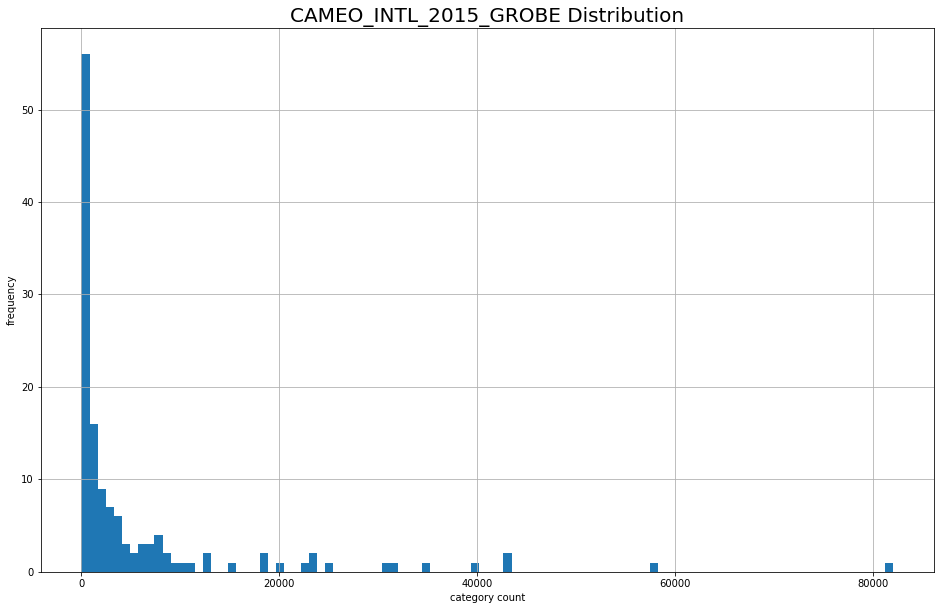

In [77]:
new_feature_hist(new_feature02, bins=100)

#### New Feature 02 Conclusion:
> There is less dicmensionality with this feature, and the distribution is more robust. Still there are some sparsity problems with it that need to be fixed where the frequency counts of some categories are less than 50.
---

#### 3.3 Investigating New Feature 03

In [78]:
investigate_two('PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_GROB')

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
16,1.12,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,True,mixed
22,1.18,PRAEGENDE_JUGENDJAHRE,JUGENDJAHRE,Dominating movement of person's youth (avantga...,True,mixed


count
PRAEGENDE_JUGENDJAHRE                          LP_LEBENSPHASE_GROB                                      
40s - reconstruction years (Avantgarde         high-income earner families                             6
                                               high-income earners of higher age from multiper...   1675
                                               high-income earners of younger age from multipe...      4
                                               low-income and average earners of higher age fr...    186
                                               single high-income earner couples                    1065
                                               single high-income earners                           2889
                                               single low-income and average earners of higher...    690
                                               single low-income and average earners of younge...      2
                                               single low-income and average-earner couples          200
                                               single parents                                         11
40s - war years (Mainstream                    average earners of younger age from multiperson...      1
                                               high-income earner families                            12
                                               high-income earners of higher age from multiper...   1376
                                               high-income earners of younger age from multipe...      5
                                               low-income and average earners of higher age fr...   1411
                                               single high-income earner couples                     742
                                               single high-income earners                           3466
                                               single low-income and average earner families           8
                                               single low-income and average earners of higher...   9374
                                               single low-income and average earners of younge...     17
                                               single low-income and average-earner couples         1744
                                               single parents                                         42
50s - economic miracle (Mainstream             average earners of younger age from multiperson...      8
                                               high-income earner families                            72
                                               high-income earners of higher age from multiper...   4585
                                               high-income earners of younger age from multipe...      1
                                               low-income and average earners of higher age fr...   4999
                                               single high-income earner couples                    4394
                                               single high-income earners                           7704
                                               single low-income and average earner families          60
                                               single low-income and average earners of higher...  21970
                                               single low-income and average earners of younge...     20
                                               single low-income and average-earner couples         7105
                                               single parents                                         96
50s - milk bar / Individualisation (Avantgarde average earners of younger age from multiperson...      1
                                               high-income earner families                            54
                                               high-income earners of higher age from multiper...   5495
    

In [79]:
new_feature03 = join_two_features(azdias, 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_GROB', 'MovementWealth')

,PRAEGENDE_JUGENDJAHRE,LP_LEBENSPHASE_GROB
0,14.0000,6.0000
1,15.0000,1.0000
2,8.0000,nan
3,8.0000,10.0000
4,3.0000,2.0000


,PRAEGENDE_JUGENDJAHRE,LP_LEBENSPHASE_GROB
0,90s - digital media kids (Mainstream,single parents
1,90s - ecological awareness (Avantgarde,single low-income and average earners of young...
2,70s - family orientation (Mainstream,NaN
3,70s - family orientation (Mainstream,low-income and average earners of higher age f...
4,50s - economic miracle (Mainstream,single low-income and average earners of highe...


,MovementWealth,count
11,40s - war years (Mainstream - average earners ...,1
37,50s - milk bar / Individualisation (Avantgarde...,1
27,50s - economic miracle (Mainstream - high-inco...,1
8,40s - reconstruction years (Avantgarde - singl...,2
191,nan - high-income earners of younger age from ...,3
107,70s - peace movement (Avantgarde - single low-...,3
97,70s - peace movement (Avantgarde - average ear...,3
80,60s - opponents to the building of the Wall (A...,3
71,60s - generation 68 / student protestors (Avan...,3
2,40s - reconstruction years (Avantgarde - high-...,4


Encoder will create 201 new features.



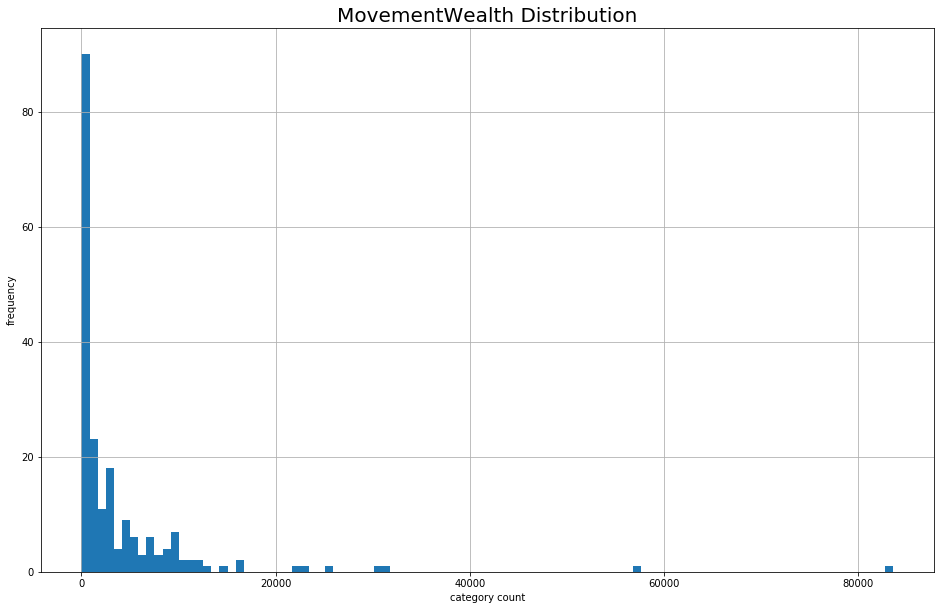

In [80]:
new_feature_hist(new_feature03, bins=100)

#### New Feature 03 Conclusion:
> There is more dimensionality with this one than the previous one. But not as much as the first one. The skewness is similar as the other one. But it has more sparsity where the categorie count is less than 50 than the previous one.
---

#### 3.4 Investigating New Feature 04

> FINAZ_AUSGEBEN was engineer to represent how susceptible is a instance to spend money.

In [81]:
investigate_two('PRAEGENDE_JUGENDJAHRE', 'FINAZ_AUSGEBEN')

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
22,1.18,PRAEGENDE_JUGENDJAHRE,JUGENDJAHRE,Dominating movement of person's youth (avantga...,True,mixed


count
PRAEGENDE_JUGENDJAHRE                              FINAZ_AUSGEBEN                 
40s - reconstruction years (Avantgarde             low money-spender           148
                                                   very low money-spender     7331
40s - war years (Mainstream                        low money-spender          1822
                                                   very low money-spender    18856
50s - economic miracle (Mainstream                 low money-spender          5117
                                                   very low money-spender    48728
50s - milk bar / Individualisation (Avantgarde     low money-spender           470
                                                   very low money-spender    19981
60s - economic miracle (Mainstream                 low money-spender          9322
                                                   very low money-spender    75370
60s - generation 68 / student protestors (Avant... low money-spender           762
                                                   very low money-spender    24890
60s - opponents to the building of the Wall (Av... low money-spender           134
                                                   very low money-spender     3876
70s - family orientation (Mainstream               average money-spender     56340
                                                   high money-spender         3128
                                                   low money-spender         54820
                                                   very high money-spender     770
                                                   very low money-spender    26572
70s - peace movement (Avantgarde                   average money-spender      4360
                                                   high money-spender          207
                                                   low money-spender         19743
                                                   very high money-spender      32
                                                   very low money-spender     9228
80s - FDJ / communist party youth organisation ... average money-spender      9448
                                                   high money-spender         5394
                                                   low money-spender          6320
                                                   very high money-spender    3213
                                                   very low money-spender       71
80s - Generation Golf (Mainstream                  average money-spender     33534
                                                   high money-spender        15728
                                                   low money-spender         25783
                                                   very high money-spender   10644
                                                   very low money-spender      119
80s - Swords into ploughshares (Avantgarde         average money-spender      1779
                                                   high money-spender          993
                                                   low money-spender          2713
                                                   very high money-spender     268
                                                   very low money-spender       11
80s - ecological awareness (Avantgarde             average money-spender      9861
                                                   high money-spender         4418
                                                   low money-spender         20371
                                                   very high money-spender    1054
                                                   very low money-spender       48
90s - digital media kids (Mainstream               average money-spender     12969
                                                   high money-spender        69685
                                                   low money-spender           291
          

In [82]:
new_feature04 = join_two_features(azdias, 'PRAEGENDE_JUGENDJAHRE', 'FINANZ_SPARER', 'PRAEGENDE_JUGENDJAHRE_SPARER')

,PRAEGENDE_JUGENDJAHRE,FINANZ_SPARER
0,14.0000,5.0000
1,15.0000,4.0000
2,8.0000,2.0000
3,8.0000,3.0000
4,3.0000,1.0000


,PRAEGENDE_JUGENDJAHRE,FINANZ_SPARER
0,90s - digital media kids (Mainstream,very low
1,90s - ecological awareness (Avantgarde,low
2,70s - family orientation (Mainstream,high
3,70s - family orientation (Mainstream,average
4,50s - economic miracle (Mainstream,very high


,PRAEGENDE_JUGENDJAHRE_SPARER,count
52,90s - ecological awareness (Avantgarde - very ...,6
37,80s - Swords into ploughshares (Avantgarde - v...,11
47,90s - digital media kids (Mainstream - very high,17
23,70s - peace movement (Avantgarde - very low,32
42,80s - ecological awareness (Avantgarde - very ...,48


Encoder will create 59 new features.



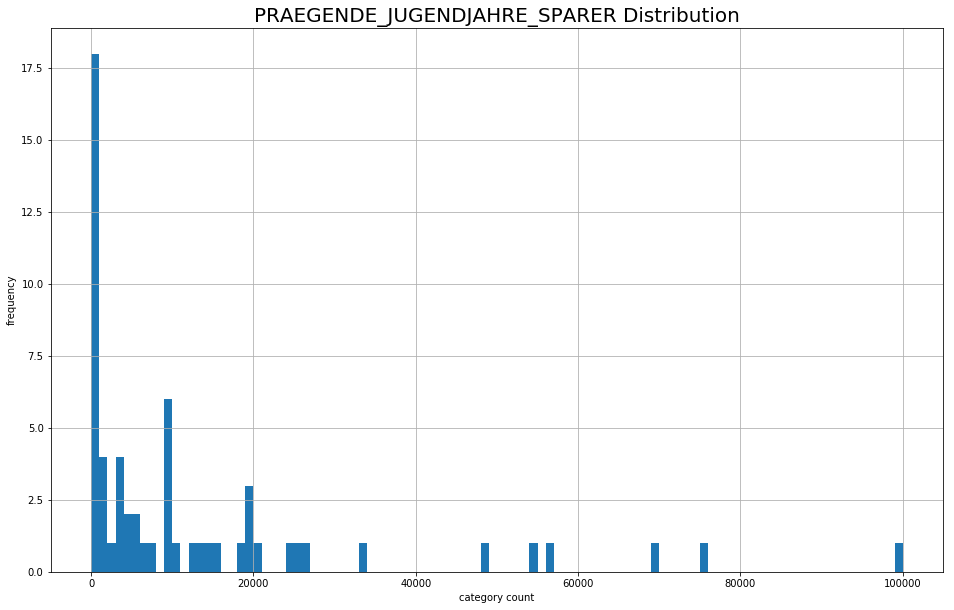

In [83]:
new_feature_hist(new_feature04, bins=100)

### New Feature 04 Conclusion
> This is the one that creates less dimensionality. At the same time it is the most robust of all new features where the category counts are less than 50. It seems that I can categorize the ones below to 50 under one category by combining all Avantgrade and Mainstream and create buckets for this one. I will add this one to the analysis as is. If needed, I will reduce the sparsity of the data.
---

#### 3.5 Investigating New Feature 05

> FINAZ_AUSGEBEN was engineer to represent how susceptible is a instance to spend money.

In [84]:
data_dict_coldesc.merge(dict_extra, on='ColumnShortName')

,key_x,ColumnName,ColumnShortName,ColNameDescription,Kept,type,key_y,ColumnMeta
0,1.5,FINANZ_MINIMALIST,MINIMALIST,Financial typology,True,ordinal,1.5,low financial interest
1,1.5,FINANZ_SPARER,SPARER,Financial typology,True,ordinal,1.5,money-saver
2,1.5,FINANZ_VORSORGER,VORSORGER,Financial typology,True,ordinal,1.5,be prepared
3,1.5,FINANZ_ANLEGER,ANLEGER,Financial typology,True,ordinal,1.5,investor
4,1.5,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,True,ordinal,1.5,inconspicuous
5,1.5,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,True,ordinal,1.5,home ownership
6,1.20,SEMIO_SOZ,SOZ,Personality typology,True,ordinal,1.20,socially-minded
7,1.20,SEMIO_FAM,FAM,Personality typology,True,ordinal,1.20,family-minded
8,1.20,SEMIO_REL,REL,Personality typology,True,ordinal,1.20,religious
9,1.20,SEMIO_MAT,MAT,Personality typology,True,ordinal,1.20,materialistic


In [85]:
data_dict_coldesc.query("ColumnName == ('FINANZ_VORSORGER', 'SEMIO_FAM', 'FINANZ_HAUSBAUER')")

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
6,1.5,FINANZ_VORSORGER,VORSORGER,Financial typology,True,ordinal
9,1.5,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,True,ordinal
25,1.20,SEMIO_FAM,FAM,Personality typology,True,ordinal


In [86]:
data_dict_view.query("ColumnName == 'CAMEO_INTL_2015'")

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
443,4.3,-1,unknown,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN
444,4.3,11,Wealthy Households - Pre-Family Couples & Singles,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN
445,4.3,12,Wealthy Households - Young Couples With Children,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN
446,4.3,13,Wealthy Households - Families With School Age ...,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN
447,4.3,14,Wealthy Households - Older Families & Mature ...,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN
448,4.3,15,Wealthy Households - Elders In Retirement,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN
449,4.3,21,Prosperous Households - Pre-Family Couples & S...,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN
450,4.3,22,Prosperous Households - Young Couples With Chi...,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN
451,4.3,23,Prosperous Households - Families With School A...,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN
452,4.3,24,Prosperous Households - Older Families & Matur...,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,NaN


In [87]:
investigate_two('CAMEO_INTL_2015', 'FINANZ_HAUSBAUER')

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
9,1.5,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,True,ordinal
59,4.3,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,True,mixed


count
CAMEO_INTL_2015                                    FINANZ_HAUSBAUER       
Comfortable Households - Elders In Retirement      average            1953
                                                   high               2190
                                                   low                2013
                                                   very high          1597
                                                   very low           2603
Comfortable Households - Families With School A... average            1937
                                                   high               2535
                                                   low                1557
                                                   very high          2666
                                                   very low           1240
Comfortable Households - Older Families & Matur... average            4000
                                                   high               3511
                                                   low                4043
                                                   very high          2026
                                                   very low           4944
Comfortable Households - Pre-Family Couples & S... average            3737
                                                   high               4271
                                                   low                4041
                                                   very high          2990
                                                   very low           3985
Comfortable Households - Young Couples With Chi... average            1999
                                                   high               2748
                                                   low                1524
                                                   very high          2738
                                                   very low           1345
Less Affluent Households - Elders In Retirement    average            4310
                                                   high               3877
                                                   low                6104
                                                   very high          1733
                                                   very low          10108
Less Affluent Households - Families With School... average           12256
                                                   high              12893
                                                   low               11122
                                                   very high          8507
                                                   very low          11894
Less Affluent Households - Older Families & Mat... average            3090
                                                   high               2922
                                                   low                3097
                                                   very high          1866
                                                   very low           3845
Less Affluent Households - Pre-Family Couples &... average           19793
                                                   high              15567
                                                   low               22753
                                                   very high          7615
                                                   very low          26608
Poorer Households - Elders In Retirement           average            2790
                                                   high               1650
                                                   low                5087
                                                   very high           528
                                                   very low          13900
...                                                                    ...
Poorer Households - Pre-Family Couples & Singles   average           28847
                   

In [88]:
new_feature05 = join_two_features(azdias, 'CAMEO_INTL_2015', 'FINANZ_HAUSBAUER', 'CAMEO_INTL_2015_FINANZ_HAUSBAUER')

,CAMEO_INTL_2015,FINANZ_HAUSBAUER
0,51,5.0000
1,24,5.0000
2,12,2.0000
3,43,2.0000
4,54,5.0000


,CAMEO_INTL_2015,FINANZ_HAUSBAUER
0,Poorer Households - Pre-Family Couples & Singles,very low
1,Prosperous Households - Older Families & Matur...,very low
2,Wealthy Households - Young Couples With Children,high
3,Less Affluent Households - Families With Schoo...,high
4,Poorer Households - Older Families & Mature Co...,very low


In [89]:
# investigating groups with less than 50 rows
new_feature05.groupby('CAMEO_INTL_2015_FINANZ_HAUSBAUER')\
    .size().reset_index().rename(columns={0:'Rows'})\
    .query("Rows <= 50")

,CAMEO_INTL_2015_FINANZ_HAUSBAUER,Rows


,CAMEO_INTL_2015_FINANZ_HAUSBAUER,count


Encoder will create 110 new features.



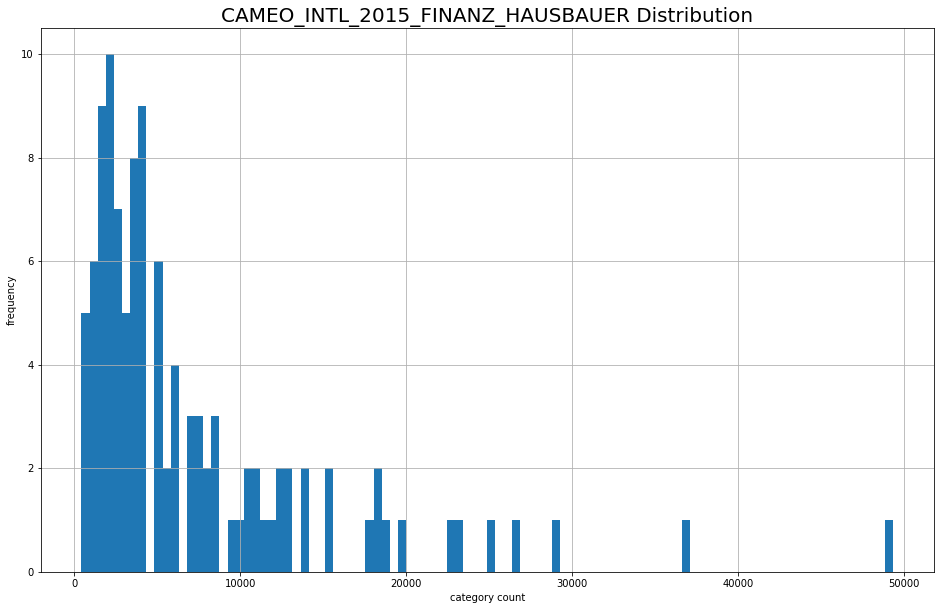

In [90]:
new_feature_hist(new_feature05, bins=100)

### New Feature 05 Conclusion
> This one also seem to be acceptable. There are no grouped labels with less than 50, so its sparsity is good. 
---

#### Discussion 1.2.2: Engineer Mixed-Type Features

>While creating 4 new features, I found interesting relationships in the data. The first relationship combined life stage, the quality of a household, and the likelyhood of spending. The second relationship combined the wealth/life stage with the most common housholde building type in the region. The third relationship combined the dominating movement with the life stage. And the last relationship combined the dominating movement with the likelyhood of spending. 

>To check for the quality of the new features, I check the sparsity of the categories. Those categories with less than 50 counts are problematic and give no meaning. Thus, the more of this are created without the posibility of merging some categories, the more problematic they are. Therefore, new features following this pattern will be discarted. The last two feature (new_feature04 and new_feature05) will be used in the analysis due to its low content of sparcity and dimensionality.

>The process I used to do feature engineering:
 1. Investigated two features and their meaning to see if they are somewhat related.
 2. Mapped the numbers back to their descriptions in the data dictionary programmatically.
 3. Analyzed the groups that they will form and assessed if their grouping was sound.
 4. Check for dimenssionality and sparsity of the groups and decided to keep them or not.
 5. Left the new feature as descriptions instead of numbers since the encoder will convert it to dummies.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### 1. Create New Feature, Encode, and Include in Data
---

In [91]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [92]:
print(f'Validating Azdias Shape: {azdias.shape}')

Validating Azdias Shape: (798070, 203)


In [93]:
# encode new feature
new_feature04_enc = pd.DataFrame(sweet_encode(new_feature04, encoder)[0])
new_feature05_enc = pd.DataFrame(sweet_encode(new_feature05, encoder)[0])

Endoding: PRAEGENDE_JUGENDJAHRE_SPARER


Endoding: CAMEO_INTL_2015_FINANZ_HAUSBAUER


In [94]:
print(f'Original Azdias Shape: {azdias_original_shape}'+
      f'\nEncoded Frame Shape: {azdias_encoded.shape}'+
      f'\nGood set Shape: {azdias_good.shape}'+
      f'\nTo-encode Categorial Shape: {azdias_toencode.shape}'+
      f'\nUencoded Shape: {azdias_unencoded.shape}'+
      f'\nUencoded + Encoded Shape: {azdias.shape}'+
      f'\nNew Feature Shape: {new_feature04_enc.shape}'+
      '\nUencoded + Encoded + NewFeature Shapes: '
      f'{azdias.shape + new_feature04_enc.shape + new_feature05_enc.shape}')

Original Azdias Shape: (891221, 85)
Encoded Frame Shape: (798070, 138)
Good set Shape: (798070, 79)
To-encode Categorial Shape: (798070, 14)
Uencoded Shape: (798070, 65)
Uencoded + Encoded Shape: (798070, 203)
New Feature Shape: (798070, 59)
Uencoded + Encoded + NewFeature Shapes: (798070, 203, 798070, 59, 798070, 110)


In [95]:
# finalizing dataset
azdias = pd.concat([azdias, new_feature04_enc, new_feature05_enc], axis=1)

In [96]:
print(f'Azdias Complete Shape: {azdias.shape}')

Azdias Complete Shape: (798070, 372)


In [97]:
# removing redundant features FINANZ_HAUSBAUER
azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'FINANZ_SPARER', 'FINANZ_HAUSBAUER'], axis=1, inplace=True)

In [98]:
print(f'Azdias Final Shape: {azdias.shape}')

Azdias Final Shape: (798070, 368)


In [99]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print(f'Number of NaNs that need removal: {azdias.isna().sum().sum():,}')

Number of NaNs that need removal: 814,480


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [100]:
def clean_data(df, col_treshold=.05):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_parsed, nan_parsed = nan_parse(df, feat_info)
    
    # remove selected columns and rows, ...
    df_reduced_col = remove_outliers(df_parsed) # columns
    df_split_set = separate_row_sets(df_reduced_col, col_treshold) # rows
    df_reduced_row = df_split_set[0].copy()
    
    # plotting the split sets
    azdias_bad_melt = df_split_set[1].iloc[:, :10].melt(var_name='Feature', value_name='Label')
    azdias_bad_melt['Set Status'] = 'Bad'
    azdias_good_melt = df_split_set[0].iloc[:, :10].melt(var_name='Feature', value_name='Label')
    azdias_good_melt['Set Status'] = 'Good'
    xx = pd.concat([azdias_good_melt, azdias_bad_melt]).fillna(0)
    plt.figure(figsize=(16, 25))
    '''for i, col in enumerate(xx.Feature.unique()[:10]):    
        plt.subplot(5, 2, i+1)
        sns.countplot(x='Label', hue='Set Status', data=xx.loc[xx.Feature==col, :])
        plt.title(f'Distribution for column: {col}')
        plt.subplots_adjust(hspace=.25)        
    plt.show()'''
        
    # WORKING ON ENCODING <----
    # select, re-encode, and engineer column values.
    reduced_column_list = list(df_reduced_row.columns)   
    df_unencoded, df_toencode, dropped_columns = get_categorical(df_reduced_row, 
                                                    reduced_column_list, 
                                                    show=True)    

    # encoding the dataset
    df_encoded, encoder = set_encoding(df_toencode)    
    
    # WORKING ON ENCODING CONSISTENCY CHECK
    # azdias    
    def get_encode_check(encoded_train, toencode_train, 
                         encoded_test, toencode_test):
        encoded_train = encoded_train.iloc[[0], :].T\
            .reset_index()\
            .rename(columns={'index':'Gen_Encoded'})\
            .drop(0, axis=1)
        encoded_train['Feature'] =  encoded_train\
            .Gen_Encoded.apply(lambda x: x[:x.rfind('_')])
        encoded_train = encoded_train.groupby('Feature').count()\
            .merge(pd.DataFrame(toencode_train.nunique(), columns=['Gen_Levels']), 
                   left_index=True, right_index=True, how='left')\
            .sort_values('Gen_Levels')
        
        encoded_test = encoded_test.iloc[[0], :].T\
            .reset_index()\
            .rename(columns={'index':'Encoded'})\
            .drop(0, axis=1)
        encoded_test['Feature'] =  encoded_test.Encoded.apply(lambda x: x[:x.rfind('_')])
        encoded_test = encoded_test.groupby('Feature').count()\
            .merge(pd.DataFrame(toencode_test.nunique(), columns=['Levels']), 
                   left_index=True, right_index=True, how='left')\
            .sort_values('Levels')
        
        display_html('Encoding Consistency Check')
        display(encoded_test.merge(encoded_train, 
                               left_index=True, 
                               right_index=True, 
                               how='left')\
                       .eval("Enc_Delta = Encoded-Gen_Encoded")\
                       .eval("Lev_Delta = Levels-Gen_Levels"))
        
        print(f"Train Encoded Shape{encoded_train.shape}\n",
              f"Test Encoded Shape{encoded_test.shape}")
       
    # feature encoding consistency call
    get_encode_check(azdias_encoded, azdias_toencode,
                     df_encoded, df_toencode)
     
    # print encoding status
    print('\nStatus: \nUencoded columns: {}\trows: {:,}'\
          .format(df_unencoded.shape[1], df_toencode.shape[0]) +\
          '\nToEncode columns: {}\trows: {:,}'\
          .format(df_toencode.shape[1], df_toencode.shape[0]) +\
          '\nEncoded columns: {}\trows: {:,}'\
          .format(df_encoded.shape[1], df_encoded.shape[0]))   
     
    # WORKING ON NEW FEATURES <----
    # create and add new features 
    new_feature01 = join_two_features(df_reduced_row, 
                             feature01='PRAEGENDE_JUGENDJAHRE', 
                             feature02='FINANZ_SPARER', 
                             new_feature_name='PRAEGENDE_JUGENDJAHRE_SPARER')
    new_feature_enc01 = pd.DataFrame(sweet_encode(new_feature01, encoder)[0])
    
    get_encode_check(new_feature04_enc, new_feature04,
                     new_feature_enc01, new_feature01)   
    
    new_feature02 = join_two_features(df_reduced_row,
                                    feature01='CAMEO_INTL_2015',
                                    feature02='FINANZ_HAUSBAUER',
                                   new_feature_name='CAMEO_INTL_2015_FINANZ_HAUSBAUER')
    new_feature_enc02 = pd.DataFrame(sweet_encode(new_feature02, encoder)[0])
    
    get_encode_check(new_feature05_enc, new_feature05,
                     new_feature_enc02, new_feature02)
    
    new_feature_enc = pd.concat([new_feature_enc01, new_feature_enc02], axis=1)
    
    # user stats
    total_unique_counts = new_feature01.nunique().item() + new_feature02.nunique().item()
    print('Status:'+\
          '\n\tNew feature unique count: %s' % total_unique_counts+\
          '\n\tEncoding column count: %s' % new_feature_enc.shape[1]+\
          '\n\tEncoded rows: {:,}'.format(new_feature_enc.shape[0]))
    
    print('\nThe final column count: {}'\
          .format(df_unencoded.shape[1] + df_encoded.shape[1] + new_feature_enc.shape[1]))
    
    # concat datasets
    print(df_unencoded.shape, df_encoded.shape, new_feature_enc.shape)
    df_completed = pd.concat([df_unencoded, df_encoded, new_feature_enc], axis=1)
    drop_list = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'FINANZ_SPARER', 'FINANZ_HAUSBAUER']
    df_completed.drop(drop_list, axis=1, inplace=True) 
    
    clean_msg = '*'*5 + 'Clean Data Achieved' + '*'*5
    display_html(clean_msg, center=True)
    
    # Return the cleaned dataframe.
    return df_completed.astype(float), df_split_set

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

### 1. Assess NaN Removals by Percentage Impact
---

In [101]:
pd.options.display.float_format = '{:2.2%}'.format
frame_nulls_left \
    = pd.DataFrame(azdias.isna().sum(), columns=['Null_Counts'])\
        .query("Null_Counts > 0")\
        .sort_values('Null_Counts')
frame_nulls_left['Null_Pct'] = frame_nulls_left.Null_Counts / azdias.shape[0]
display(frame_nulls_left\
            .merge(feat_info[['attribute', 'type']]\
                   .set_index('attribute'),
                          left_index=True, right_index=True, how='left')\
            .sort_values('Null_Pct', ascending=False))

,Null_Counts,Null_Pct,type
KKK,64913,8.13%,ordinal
REGIOTYP,64913,8.13%,ordinal
W_KEIT_KIND_HH,59307,7.43%,ordinal
LP_LEBENSPHASE_FEIN,50242,6.30%,mixed
LP_LEBENSPHASE_GROB,47349,5.93%,mixed
KBA05_ANTG1,40173,5.03%,ordinal
KBA05_ANTG2,40173,5.03%,ordinal
KBA05_ANTG3,40173,5.03%,ordinal
KBA05_ANTG4,40173,5.03%,ordinal
KBA05_GBZ,40173,5.03%,ordinal


In [102]:
pd.options.display.float_format = '{:2.4f}'.format
frame_nulls_left.sum()

Null_Counts   814480.0000
Null_Pct           1.0206
dtype: float64

>**Remove all conclussion**: Removing all rows with nulls will result in at most 20% of dataset removal, which is quite significant. It dependes on which null values are shared null values row by row.

In [103]:
frame_keep_nulls\
    = frame_nulls_left[['Null_Pct']]\
        .sort_values('Null_Pct', ascending=False)\
        .cumsum()\
        .pct_change()\
        .query("Null_Pct > 0.01 or Null_Pct != Null_Pct")\
                .merge(feat_info[['attribute', 'type']]\
                       .set_index('attribute'),
                              left_index=True, right_index=True, how='left')
frame_keep_nulls

,Null_Pct,type
KKK,nan,ordinal
REGIOTYP,1.0000,ordinal
W_KEIT_KIND_HH,0.4568,ordinal
LP_LEBENSPHASE_FEIN,0.2656,mixed
LP_LEBENSPHASE_GROB,0.1978,mixed
KBA05_ANTG1,0.1401,ordinal
KBA05_ANTG2,0.1229,ordinal
KBA05_ANTG3,0.1094,ordinal
KBA05_ANTG4,0.0986,ordinal
KBA05_GBZ,0.0898,ordinal


>Note: The percentage change is significat for the above features.

In [104]:
remove_nan = frame_nulls_left[['Null_Pct']]\
    .sort_values('Null_Pct', ascending=False)\
    .cumsum()\
    .pct_change()\
    .query("Null_Pct < 0.01").index
print(f'Removing Row with NaNs for the following features: {list(remove_nan)}')
frame_nulls_left.query(f"index == {list(remove_nan)}").sum()

Removing Row with NaNs for the following features: ['ANZ_HAUSHALTE_AKTIV', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S', 'ARBEIT', 'RELAT_AB', 'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'ALTERSKATEGORIE_GROB', 'EWDICHTE', 'BALLRAUM', 'INNENSTADT', 'KONSUMNAEHE', 'GEBAEUDETYP_RASTER']


Null_Counts   37063.0000
Null_Pct          0.0464
dtype: float64

>**Remove low percentage impact conclussion**: Removing rows with NaNs out of these ones makes sense since the removal is insignificant.

In [105]:
frame_nulls_left.query(f"index != {list(remove_nan)}").sum()

Null_Counts   777417.0000
Null_Pct           0.9741
dtype: float64

>**Keep high percentage impact conclussion**: Assess imputation of features with high percentage impact.

### 2. Assessing the Ideal Imputing Method
---

In [106]:
head = 5 # change number to see more data value descriptions
display_html('Value Keys for Features with More than 5% NaNs')
data_dict_view\
    .query(f"ColumnName == {list(frame_keep_nulls.index)}")\
    .merge(feat_info[['attribute', 'type']]\
           .rename(columns={'attribute':'ColumnName'}), on='ColumnName', how='left')\
    .head(head)

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta,type
0,1.10,-1,unknown,HEALTH_TYP,TYP,Health typology,NaN,ordinal
1,1.10,0,classification not possible,HEALTH_TYP,TYP,Health typology,NaN,ordinal
2,1.10,1,critical reserved,HEALTH_TYP,TYP,Health typology,NaN,ordinal
3,1.10,2,sanitary affine,HEALTH_TYP,TYP,Health typology,NaN,ordinal
4,1.10,3,jaunty hedonists,HEALTH_TYP,TYP,Health typology,NaN,ordinal


#### 2.1 Numerical Assessment
---
---

In [107]:
data_dict_coldesc.query(f"type == 'numeric' and Kept == True and ColumnName == {list(frame_keep_nulls.index)}")

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
74,8.1,KBA13_ANZAHL_PKW,ANZAHL_PKW,Number of cars in the PLZ8 region,True,numeric


In [108]:
pd.options.display.float_format = '{:2.2f}'.format
azdias[['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ANZ_HH_TITEL']].describe()

,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,ANZ_HH_TITEL
count,791607.00,785421.00,794210.00
mean,8.35,619.70,0.04
std,15.67,340.03,0.32
min,1.00,0.00,0.00
25%,2.00,384.00,0.00
50%,4.00,549.00,0.00
75%,10.00,778.00,0.00
max,595.00,2300.00,23.00


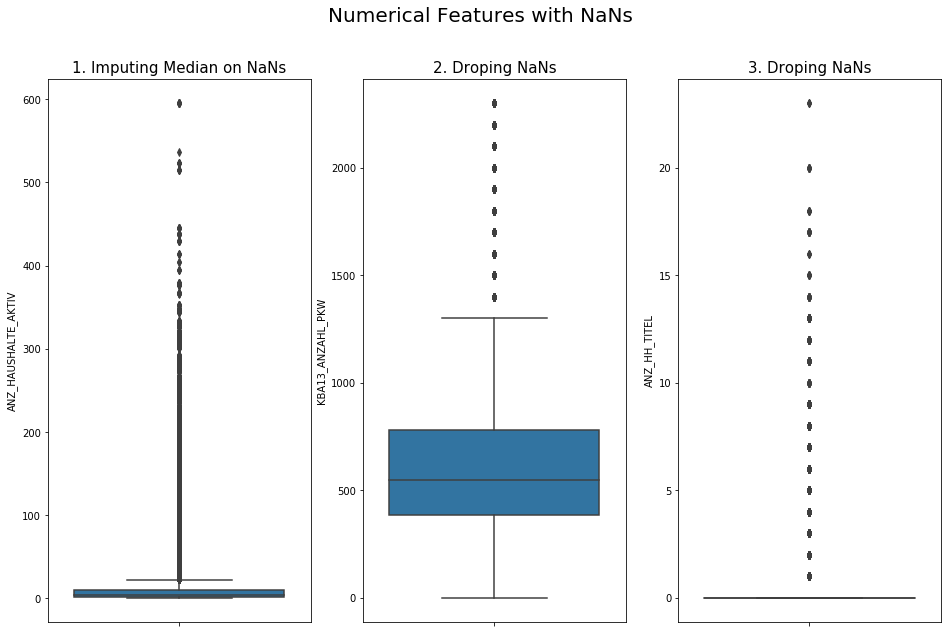

In [109]:
plt.figure(figsize=(16, 10))
plt.suptitle('Numerical Features with NaNs', size=20)
plt.subplot(131)
plt.title('1. Imputing Median on NaNs', size=15)
sns.boxplot(y='ANZ_HAUSHALTE_AKTIV', data=azdias)
plt.subplot(132)
plt.title('2. Droping NaNs', size=15)
sns.boxplot(y='KBA13_ANZAHL_PKW', data=azdias)
plt.subplot(133)
plt.title('3. Droping NaNs', size=15)
sns.boxplot(y='ANZ_HH_TITEL', data=azdias)
plt.show()

> **Numerical Imputing Conclussion**: 
> - I am imputing the median for numerical feature number 1. This feaature has a significant NaN percentage impact, thus the rows will be kept.
> - On the contrary, feature number 2 and 3 have very low NaN percentage impact. Therefore, imputation will be ignored and rows with NaNs will be removed.
---

#### 2.2 Ordinal, Mixed, and Categorical Assessment
---
---

In [110]:
def show_cat_plots():
    fig1, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    ax11, ax12, ax21, ax22 = ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]

    plt.suptitle('Count Plots of Top 4 Non-Numerical Features', size=20)
    
    if azdias.isna().sum().sum() > 0: i = 0
    else: i = 1

    # draw plots
    sns.countplot(x=azdias.KKK.fillna(0), ax=ax11)
    ax11.vlines(x=azdias.KKK.median()-i, ymin=0, ymax=azdias.groupby('KKK').size().max())
    sns.countplot(x=azdias.REGIOTYP.fillna(0), ax=ax12)
    ax12.vlines(x=azdias.REGIOTYP.median()-i, ymin=0, ymax=azdias.groupby('REGIOTYP').size().max())
    sns.countplot(x=azdias.W_KEIT_KIND_HH.fillna(0), ax=ax21)
    ax21.vlines(x=azdias.W_KEIT_KIND_HH.median()-i, ymin=0, ymax=azdias.groupby('W_KEIT_KIND_HH').size().max())
    sns.countplot(x=azdias.HEALTH_TYP.fillna(0), ax=ax22)
    ax22.vlines(x=azdias.HEALTH_TYP.median()-i, ymin=0, ymax=azdias.groupby('HEALTH_TYP').size().max())

    plt.show()

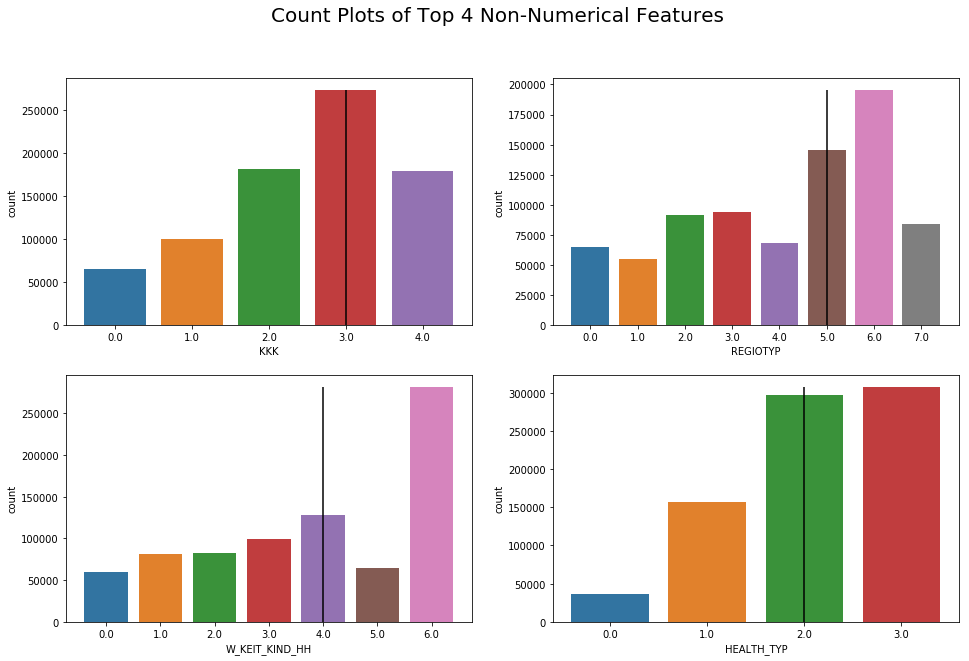

In [111]:
show_cat_plots()

> **Non-numercal feature conclussion**: At first, I contemplated the idea of using the mode to fill the null values. But after seeing the distribution of counts, I notice that the method will just create more peak specially in REGIOTYP. For that reason, I decided to use the median to redistribute. There is always a chance that a method might be the wrong one since we are predicting on the population. But the mean method feels right in this case. The rest of the features have less NaN percentage impact. Therefore, they are not going to be significant in the imputation method selection.

### 3. Imputate or/and Remove NaN values as Assessed
---

#### 3.1 Remove NaNs
---
---

In [112]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
subset = list(remove_nan)

In [113]:
current_rows = azdias.shape[0]
azdias.dropna(axis=0, how='any', subset=subset, inplace=True)
reduced_rows =  azdias.shape[0]
drop_rows = current_rows-reduced_rows
print(f'Azdias was reduced by {drop_rows:,}, which is a {drop_rows/current_rows:2.2%} reduction.')

Azdias was reduced by 18,773, which is a 2.35% reduction.


#### 3.2 Impute Rounded Medians
---
---

In [114]:
from sklearn.impute import SimpleImputer

In [115]:
subset = list(frame_nulls_left.query(f"index != {list(remove_nan)}").index)

In [116]:
azdias.loc[:, subset].dtypes

KBA13_ANZAHL_PKW       float64
PLZ8_BAUMAX            float64
PLZ8_ANTG4             float64
PLZ8_ANTG3             float64
PLZ8_ANTG2             float64
PLZ8_ANTG1             float64
PLZ8_GBZ               float64
PLZ8_HHZ               float64
VERS_TYP               float64
HEALTH_TYP             float64
MOBI_REGIO             float64
KBA05_GBZ              float64
KBA05_ANTG4            float64
KBA05_ANTG3            float64
KBA05_ANTG2            float64
KBA05_ANTG1            float64
LP_LEBENSPHASE_GROB    float64
LP_LEBENSPHASE_FEIN    float64
W_KEIT_KIND_HH         float64
REGIOTYP               float64
KKK                    float64
dtype: object

> Note: Since there is not demcial places in the numeric feature ANZ_HAUSHALTE_AKTIV, we can use a round median to impute.

In [117]:
azdias.loc[:, subset].shape

(779297, 21)

In [118]:
pd.DataFrame(azdias.isna().sum(), columns=['NaNs']).query("NaNs > 0")

,NaNs
HEALTH_TYP,33316
LP_LEBENSPHASE_FEIN,40784
LP_LEBENSPHASE_GROB,38029
VERS_TYP,33316
W_KEIT_KIND_HH,53900
KBA05_ANTG1,38948
KBA05_ANTG2,38948
KBA05_ANTG3,38948
KBA05_ANTG4,38948
KBA05_GBZ,38948


In [119]:
def do_imputer(dataframe, strategy='median'):
    
    # start the model
    imp_median = SimpleImputer(missing_values=np.nan, strategy=strategy)
    
    # fit_transform
    output = pd.DataFrame(imp_median.fit_transform(dataframe), columns=dataframe.columns)
    
    # show statistic results
    pd.options.display.max_rows = 300
    display(pd.DataFrame([imp_median.statistics_, azdias.columns]).T\
        .rename(columns={0:'Imputated Median', 1:'Feature'})\
        .query(f"Feature == {subset}"))   
    
    return imp_median, output

def redo_imputer(imputer, dataframe, subset):
    output = pd.DataFrame(imputer.fit_transform(dataframe), columns=dataframe.columns)
    pd.options.display.max_rows = 300
    display(pd.DataFrame([imputer.statistics_, azdias.columns]).T\
        .rename(columns={0:'Imputated Median', 1:'Feature'})\
        .query(f"Feature == {subset}")) 
    
    return output

In [120]:
azdias_imputer, azdias = do_imputer(azdias)

,Imputated Median,Feature
7,2.00,HEALTH_TYP
8,13.00,LP_LEBENSPHASE_FEIN
9,3.00,LP_LEBENSPHASE_GROB
26,2.00,VERS_TYP
30,4.00,W_KEIT_KIND_HH
37,1.00,KBA05_ANTG1
38,1.00,KBA05_ANTG2
39,0.00,KBA05_ANTG3
40,0.00,KBA05_ANTG4
41,3.00,KBA05_GBZ


> Note: There was no need to round the medians since each imputation matches perfectly with the data dictionary.

In [121]:
print(f'Validating Azdias Shape Again: {azdias.shape}')

Validating Azdias Shape Again: (779297, 368)


In [122]:
print(f'Validating NaNs: {azdias.isna().sum().sum()}'+
      f"\n{'Data is ready to scale, pca, kemans' if azdias.isna().sum().sum() == 0 else ''}")

Validating NaNs: 0
Data is ready to scale, pca, kemans


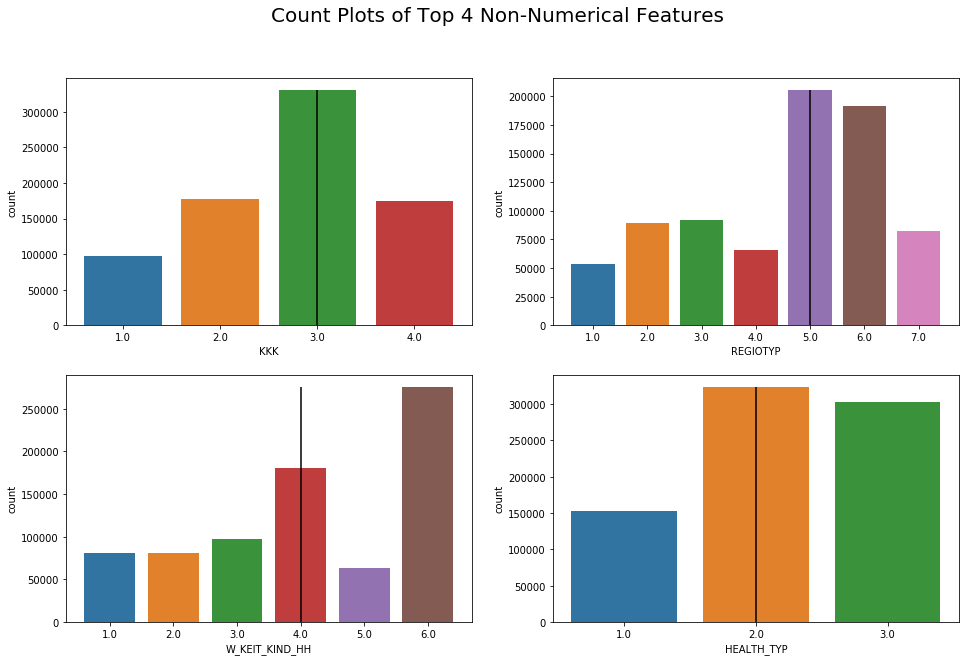

In [123]:
show_cat_plots()

### 4. Scale the Data
---

In [124]:
def do_standarscaler(dataframe):
    start = TickTock()
    scaler = StandardScaler()
    X = scaler.fit_transform(dataframe)
    print(f'Time to process: {start.stop_clock()}')
    return scaler, X

def redo_standarscaler(reused_scaler, dataframe):
    """
    Returns scaled data only
    """
    return reused_scaler.transform(dataframe)

In [125]:
# Apply feature scaling to the general population demographics data.
azdias_scaler, X = do_standarscaler(azdias)

Time to process: 0:00:12.539163


### Discussion 2.1: Apply Feature Scaling

> - At first I check the impact of removing all the NaNs. I came to realize that removing all rows with NaNs would take at most ~20% of the data. Therefore, instead I calculated the percentage change of the cumulative percentage to provide a percentage impact. Anything with less than .01% impact was determined to be removed. 
>- From the features left from which I was going to keep rows and do imputations, there was a numerical feature. 
ANZ_HAUSHALTE_AKTIV was heavily skewed to the right. Therefore, the mean imputation strategy did not seem the right approach. I decided a median imputation for the numerical feature. 
>- The rest of the features, the categorical, mixed, and ordinal, had some high peaks, especially in REGIOTYP. Thus, imputing on mode would have increased the peaks. That did not seem right. So I decided to imputate the median as well for these features.
The reduction of data only reduced 0.24% of the rows. And the median imputations needed no rounding to match the data dictionary.




### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [126]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
        #ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Cumulative Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component', size=20)

In [127]:
def do_pca(n_components, X_scaled, show_time=True):
    start = TickTock()
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X_scaled)
    print(f'Time to process: {start.stop_clock()}')
    return pca, X_pca

def redo_pca(reused_pca, X_scaled):
    """
    Returns
    -------
    - reused pca model
    - pca data
    """
    return reused_pca, reused_pca.transform(X_scaled)

In [128]:
# Apply PCA to the data.
def find_n_component(scaled_data, full_dataset, start= 3, steps=2):
    X = scaled_data
    for comp in range(start, X.shape[1], steps):
        pca, X_pca = do_pca(comp, X, show_time=False)
        comp_check = pca_results(full_dataset, pca)
        print('{} components will explain {:2.2%} of the variance.'\
              .format(comp, comp_check['Explained Variance'].sum()))
        if comp_check['Explained Variance'].sum() > .85:
            return comp
            break   

In [129]:
n_component = find_n_component(X, azdias, start=208)

Time to process: 0:01:27.360564
208 components will explain 85.53% of the variance.


In [130]:
# Re-apply PCA to the data while selecting for number of components to retain.
azdias_pca, X_pca = do_pca(208, X) # < -- Re-applying happens here 

Time to process: 0:01:20.531840


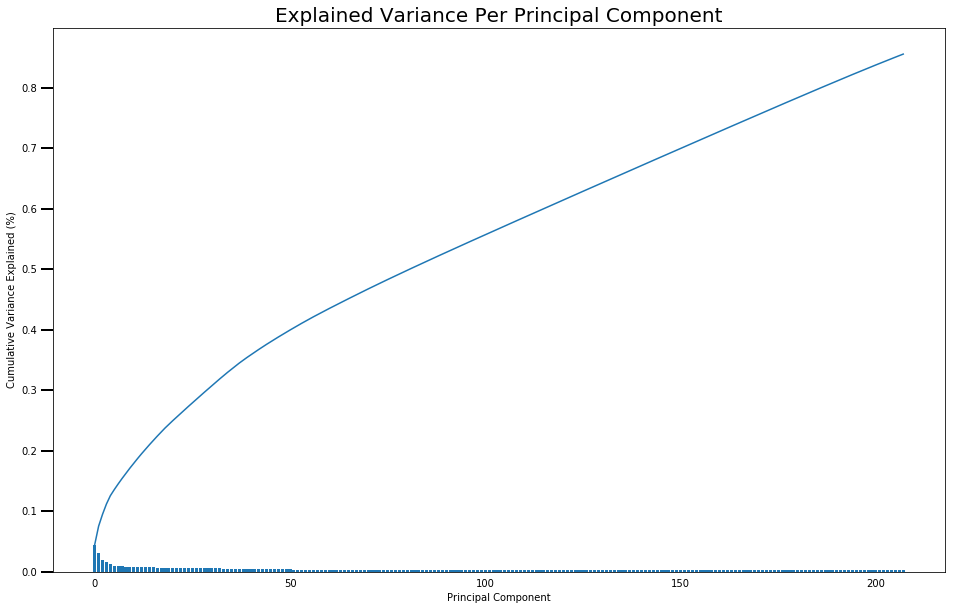

In [131]:
# Investigate the variance accounted for by each principal component.
scree_plot(azdias_pca)

In [132]:
print(f'The number of columns PCA is explaining: {azdias.shape[1]}')

The number of columns PCA is explaining: 368


In [133]:
print(f'The number of features per component: {azdias_pca.components_.shape[1]}')

The number of features per component: 368


In [134]:
print(f'The number fo components to use: {azdias_pca.components_.shape[0]}')

The number fo components to use: 208


### Discussion 2.2: Perform Dimensionality Reduction

> After performing a series of principal component analyses with n components, the best results occured at 208 componenets as it can explain > 85% of the variance in the original data. 
> As shown in the plot above, each component accounts for the explenation in variance of the original data. For example, x components will account for 100% of the variance in the original data because it would represent the original data in whole. Instead, what PCA does is to minimize the number of features by replacing it with a set of correlation for each feature in each component. 
> Thus 208 componenets where passed trough the do_pca function to continue the kmean modeling. At this point the rest of the components add almoust insignificant percentage to the variance explanation in the model.

In [135]:
print(f'The first component (# 1) was explaining {azdias_pca.explained_variance_ratio_[0]:2.2%}')
print(f'The last component (# 208) was explaining {azdias_pca.explained_variance_ratio_[207]:2.2%}')

The first component (# 1) was explaining 4.50%
The last component (# 208) was explaining 0.25%


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [136]:
def frame_principal_components(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension_{}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained_Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [137]:
def get_principal_component(dataframe_components, component_namenum, show=False):
    # extract specific principal component
    principal_component01 = dataframe_components.loc[[component_namenum], :].iloc[:, 1:]

    # very rare and important weights 
    q3 = principal_component01.T.quantile(.75).item()
    q1 = principal_component01.T.quantile(.25).item()
    dim01_top = q3 + (q3-q1)*1.5 
    dim01_low = q1 - (q3-q1)*1.5 

    # plot the weights
       
    principal_results = principal_component01.T.query("{comp} > {top} or {comp} < {bottom}"\
                                  .format(comp=component_namenum, top=dim01_top, bottom=dim01_low))\
                           .sort_values(component_namenum, ascending=False)    
    principal_results['Rank'] = principal_results[[component_namenum]].rank().astype(int)
    
    if show:
        display_html('Descriptive Stats')
        display(principal_component01.T.describe())
        fig, ax = plt.subplots(figsize = (16, 15))
        principal_results[[component_namenum]].T.plot(ax=ax, kind='bar')
        plt.title('Principal Component Valuable Weights', size=20)
        plt.xticks(rotation=.45, size=15)
        plt.yticks(size=15)
        plt.show()
    
    return principal_results

### 1. Analyze the First 3 Principal Components
---

In [138]:
azdias_components = frame_principal_components(azdias, azdias_pca)

In [139]:
print(f'Row and column size of the pca: {azdias_components.shape}')

Row and column size of the pca: (208, 369)


#### 1.1 First Princial Component
---
---

,Dimension_1
count,368.00
mean,-0.00
std,0.05
min,-0.20
25%,-0.02
50%,-0.00
75%,0.01
max,0.19


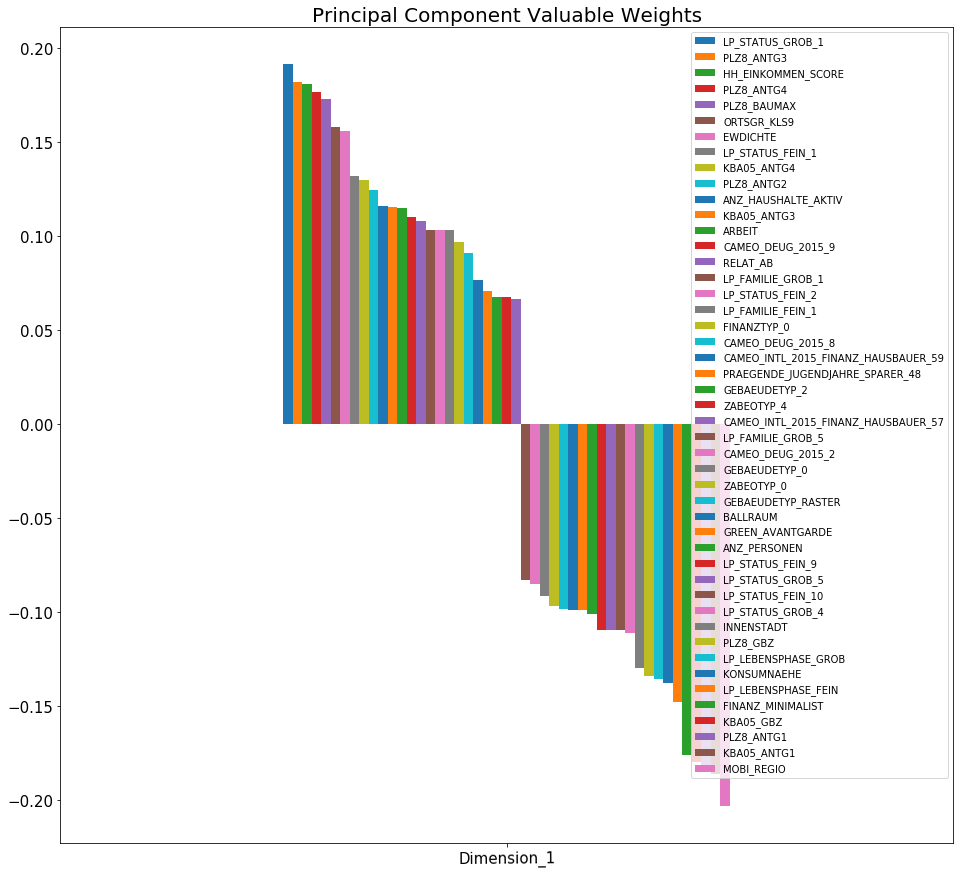

,Dimension_1,Rank
LP_STATUS_GROB_1,0.19,47
PLZ8_ANTG3,0.18,46
HH_EINKOMMEN_SCORE,0.18,45
PLZ8_ANTG4,0.18,44
PLZ8_BAUMAX,0.17,43
ORTSGR_KLS9,0.16,42
EWDICHTE,0.16,41
LP_STATUS_FEIN_1,0.13,40
KBA05_ANTG4,0.13,39
PLZ8_ANTG2,0.12,38


In [140]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
get_principal_component(azdias_components, 'Dimension_1', show=True)

> **First principal component conclussion**: 
- We have LP_STATUS_GROB encoding 0 in the upper side, which represents social status of low-income earners; and MOBI_REGIO in the lower side, which represents movement patters . 
- It is followed by the PLZ8_ANTG3 in the upper side, wich represents the quantity of 6-10 family houses in the PLZ8 region; and KBA05_ANTG1 in the lower side, which represents the number of houses in the microcell.

In [141]:
x = encoder['LP_STATUS_GROB']
x.classes_

array([0, 1, 2, 3, 4, 5], dtype=int8)

In [142]:
data_dict_view\
    .query("ColumnName == ('LP_STATUS_GROB', 'MOBI_REGIO', 'PLZ8_ANTG3', 'KBA05_ANTG1')")\
    .sort_values(['key', 'value_key'])

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
165,1.16,1,low-income earners (maps to 1-2 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
166,1.16,2,average earners (maps to 3-5 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
167,1.16,3,independents (maps to 6-7 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
168,1.16,4,houseowners (maps to 8-9 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
169,1.16,5,top earners (maps to 10 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
470,5.1,0,no 1-2 family homes,KBA05_ANTG1,ANTG1,Number of 1-2 family houses in the microcell,NaN
471,5.1,1,lower share of 1-2 family homes,KBA05_ANTG1,ANTG1,Number of 1-2 family houses in the microcell,NaN
472,5.1,2,average share of 1-2 family homes,KBA05_ANTG1,ANTG1,Number of 1-2 family houses in the microcell,NaN
473,5.1,3,high share of 1-2 family homes,KBA05_ANTG1,ANTG1,Number of 1-2 family houses in the microcell,NaN
474,5.1,4,very high share of 1-2 family homes,KBA05_ANTG1,ANTG1,Number of 1-2 family houses in the microcell,NaN


#### 1.2 Second Princial Component
---
---

,Dimension_2
count,368.00
mean,-0.00
std,0.05
min,-0.23
25%,-0.01
50%,-0.00
75%,0.01
max,0.25


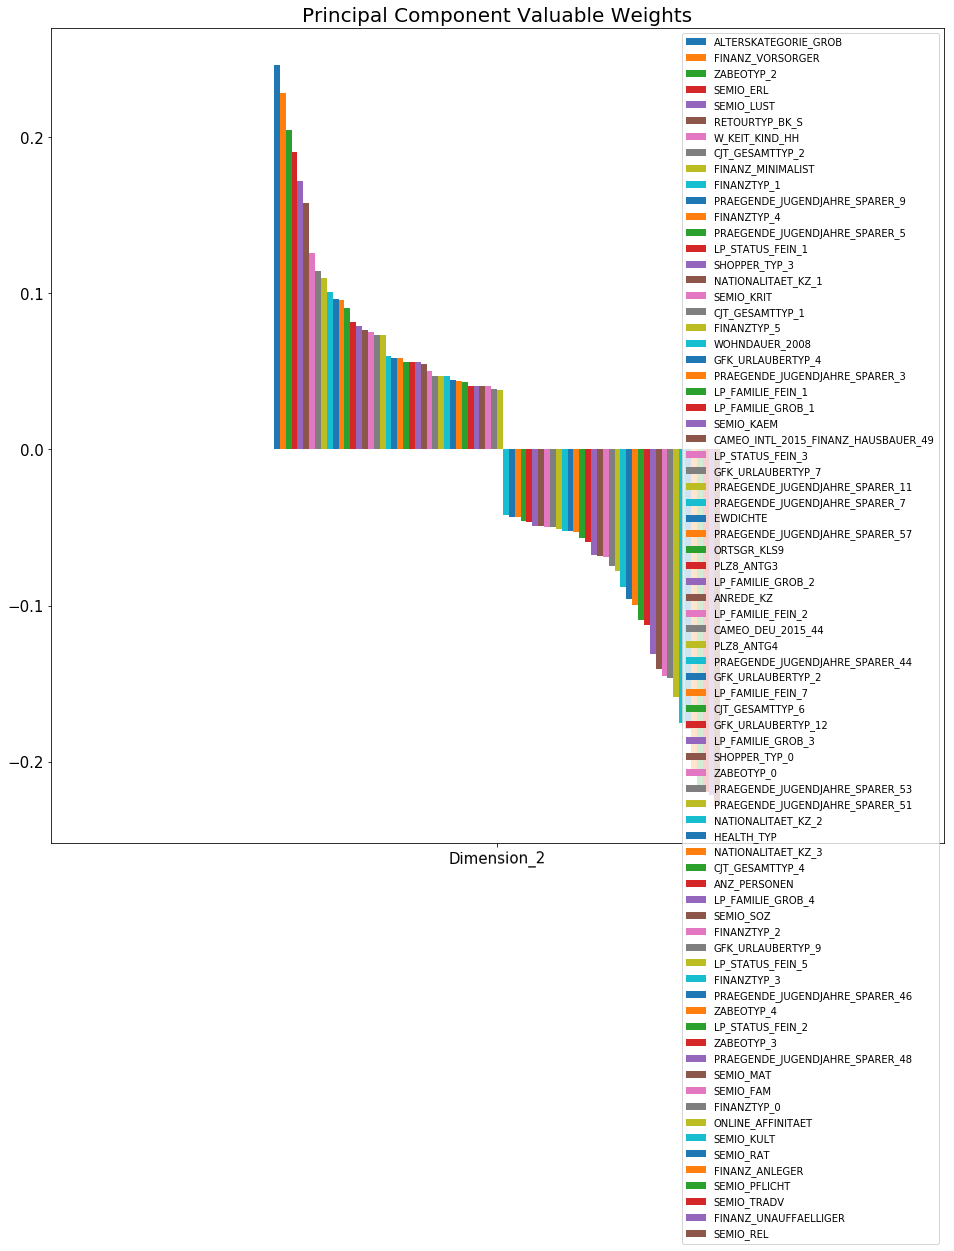

,Dimension_2,Rank
ALTERSKATEGORIE_GROB,0.25,76
FINANZ_VORSORGER,0.23,75
ZABEOTYP_2,0.20,74
SEMIO_ERL,0.19,73
SEMIO_LUST,0.17,72
RETOURTYP_BK_S,0.16,71
W_KEIT_KIND_HH,0.13,70
CJT_GESAMTTYP_2,0.11,69
FINANZ_MINIMALIST,0.11,68
FINANZTYP_1,0.10,67


In [143]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_principal_component(azdias_components, 'Dimension_2', show=True)

> **First principal component conclussion**:
- We have ALTERSKATEGORIE_GROB in the upper side, which represents the estimated age; and SEMIO_REL in the lower side, which represent the money-saver financial typology. 
- It is followed by the FINANZ_VORSORGER in the upper side, which represents the be-prepared financial typology; and FINANZ_UNAUFFAELLIGER in the lower side, which represent the inconspicuous personality typology.

In [144]:
data_dict_view\
    .query("ColumnName == ('ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'SEMIO_REL', 'FINANZ_UNAUFFAELLIGER')")\
    .sort_values(['key', 'ColumnName', 'value_key'])

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
6,1.2,0,unknown (cannot be determined),ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
7,1.2,1,< 30 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
8,1.2,2,30 - 45 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
9,1.2,3,46 - 60 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
10,1.2,4,> 60 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
11,1.2,9,uniformly distributed,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
5,1.2,-1,unknown (missing),ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
214,1.20,1,highest affinity,SEMIO_REL,REL,Personality typology,religious
228,1.20,2,very high affinity,SEMIO_REL,REL,Personality typology,religious
242,1.20,3,high affinity,SEMIO_REL,REL,Personality typology,religious


#### 1.3 Third Princial Component
---
---

,Dimension_3
count,368.00
mean,0.00
std,0.05
min,-0.33
25%,-0.01
50%,-0.00
75%,0.01
max,0.31


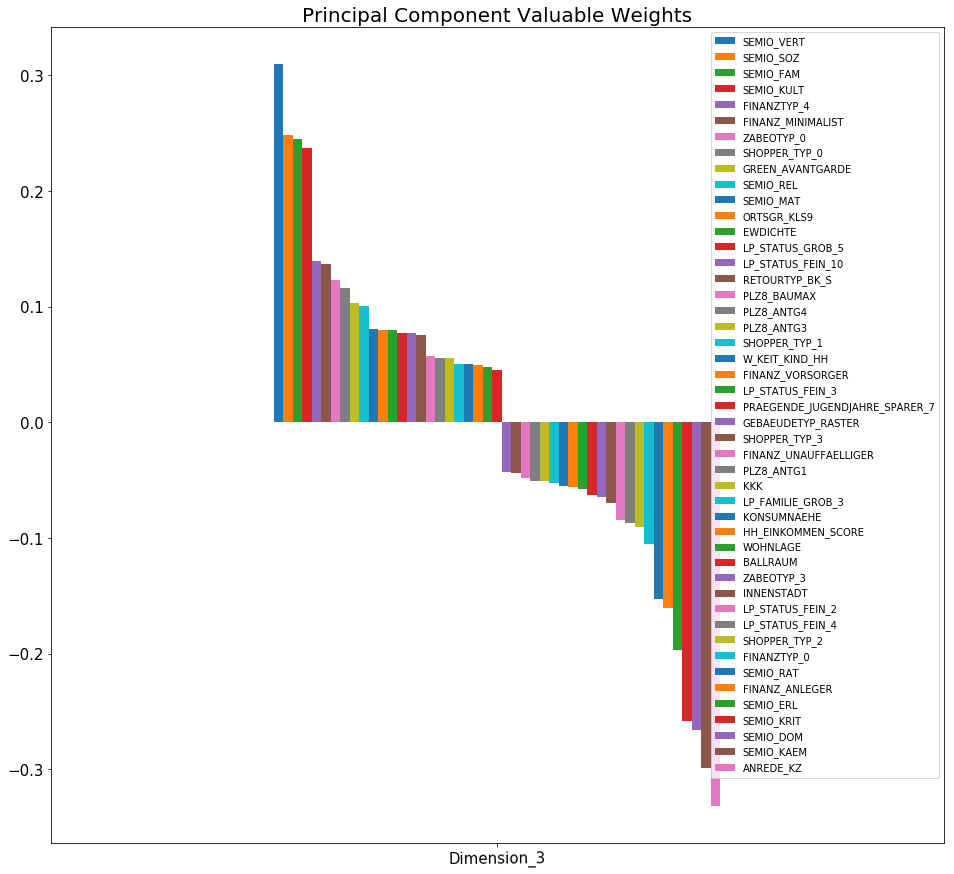

,Dimension_3,Rank
SEMIO_VERT,0.31,47
SEMIO_SOZ,0.25,46
SEMIO_FAM,0.24,45
SEMIO_KULT,0.24,44
FINANZTYP_4,0.14,43
FINANZ_MINIMALIST,0.14,42
ZABEOTYP_0,0.12,41
SHOPPER_TYP_0,0.12,40
GREEN_AVANTGARDE,0.10,39
SEMIO_REL,0.10,38


In [145]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_principal_component(azdias_components, 'Dimension_3', show=True)

> **First principal component conclussion**:
- We have SEMIO_VERT in the upper side, which represent the dreamful personality typology and ANREDE_KZ in the lower side, which represent the combative attitude personality typology. 
- It is followed by the SEMIO_SOZ in the upper side, which represent the socially-minded personality typology; and SEMIO_KAEM in the lower side, which represent the gender.

In [146]:
data_dict_view\
    .query("ColumnName == ('SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_KAEM', 'ANREDE_KZ')")\
    .sort_values(['key', 'ColumnName', 'value_key'])

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
223,1.20,1,highest affinity,SEMIO_KAEM,KAEM,Personality typology,combative attitude
237,1.20,2,very high affinity,SEMIO_KAEM,KAEM,Personality typology,combative attitude
251,1.20,3,high affinity,SEMIO_KAEM,KAEM,Personality typology,combative attitude
265,1.20,4,average affinity,SEMIO_KAEM,KAEM,Personality typology,combative attitude
279,1.20,5,low affinity,SEMIO_KAEM,KAEM,Personality typology,combative attitude
293,1.20,6,very low affinity,SEMIO_KAEM,KAEM,Personality typology,combative attitude
307,1.20,7,lowest affinity,SEMIO_KAEM,KAEM,Personality typology,combative attitude
321,1.20,9,unknown,SEMIO_KAEM,KAEM,Personality typology,combative attitude
209,1.20,-1,unknown,SEMIO_KAEM,KAEM,Personality typology,combative attitude
212,1.20,1,highest affinity,SEMIO_SOZ,SOZ,Personality typology,socially-minded


---

In [147]:
azdias_components.iloc[[0], 1:].T.eval("Dm1 = abs(Dimension_1)").sort_values("Dm1", ascending=False)[:2]

,Dimension_1,Dm1
MOBI_REGIO,-0.20,0.20
LP_STATUS_GROB_1,0.19,0.19


In [148]:
azdias_components.iloc[[1], 1:].T.eval("Dm2 = abs(Dimension_2)").sort_values("Dm2", ascending=False)[:2]

,Dimension_2,Dm2
ALTERSKATEGORIE_GROB,0.25,0.25
SEMIO_REL,-0.23,0.23


In [149]:
azdias_components.iloc[[2], 1:].T.eval("Dm3 = abs(Dimension_3)").sort_values("Dm3", ascending=False)[:2]

,Dimension_3,Dm3
ANREDE_KZ,-0.33,0.33
SEMIO_VERT,0.31,0.31


### Discussion 2.3: Interpret Principal Components

> In general we can interpret positive and negative values in a meaningful way. 

> The 1st Principal Component is positively correlated by LP_STATUS_GROB at encoding label 0. This represents the low-income earners. It is also negatively correlated by MOBI_REGIO. This represents movement patterns. Thus, in general this component is represented by low-income earners and people movement patterns almost at the same extent, with .19 and .20 coefficient of correlation respectively.

> The 2nd Principal Component is positively correlated by ALTERSKATEGORIE_GROB. This represents estimated age. It is also negatively correlated by SEMIO_REL. This represents the religious-minded. Thus, in general this component is represented by people’s age buckets and their religion status at the same extent, .25 and .23 coefficient of correlation respectively. 

> The 3rd Principal Component is positively correlated by SEMIO_VERT. This represents the dreamful status. It is also negatively correlated by ANREDE_KZ. This represents the gender. Thus, in general this component is represented by people’s affinity to be dreamful and their gender almost to the same extent, with .31 and .33 coefficient of correlation respectively. 



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [150]:
def get_kmeans_score(data, center):
    
    # instantiate kemans
    kmeans = KMeans(n_clusters=center)
    
    # fit the model
    model = kmeans.fit(data)
    
    # obtain score
    score = np.abs(model.score(data))
    
    return score
    

In [151]:
def find_clusters(data_pca, start=1):
    scores = []
    centers = []
    centers_testrange = list(range(start, 30, 1))

    # Over a number of different cluster counts...
    start = TickTock()
    for center in centers_testrange:
        center_start = TickTock()
        # run k-means clustering on the data and...
        # compute the average within-cluster distances.
        score = get_kmeans_score(data_pca, center)

        # storing scores
        try: percent_change = (scores[-1]-score)/scores[-1]
        except: percent_change = 0.00
            
        
        center_time = center_start.stop_clock()
        print(f"Testing {center} cluster(s):\tScore: {score:0,.2f}"+\
              f"\t% Change: {percent_change:0.2%}\t Time:{center_time}")

        scores.append(score)
        centers.append(center)

        if percent_change < .001 and center != 1: 
            return center, centers, scores
            print('Time to find cluster: {}'.format(start.stop_clock()))
            break 
        
    

In [152]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def plot_clusters(centers, scores):
    plt.figure(figsize=(16, 10))
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');

Testing 1 cluster(s):	Score: 236,041,987.93	% Change: 0.00%	 Time:0:00:29.234714
Testing 2 cluster(s):	Score: 226,507,745.41	% Change: 4.04%	 Time:0:01:24.378827
Testing 3 cluster(s):	Score: 222,200,985.30	% Change: 1.90%	 Time:0:02:03.317953
Testing 4 cluster(s):	Score: 219,307,292.87	% Change: 1.30%	 Time:0:03:53.004147
Testing 5 cluster(s):	Score: 216,732,058.61	% Change: 1.17%	 Time:0:04:51.853215
Testing 6 cluster(s):	Score: 215,191,340.72	% Change: 0.71%	 Time:0:03:52.138521
Testing 7 cluster(s):	Score: 213,582,388.95	% Change: 0.75%	 Time:0:06:36.963983
Testing 8 cluster(s):	Score: 212,380,544.26	% Change: 0.56%	 Time:0:06:59.908289
Testing 9 cluster(s):	Score: 211,449,332.88	% Change: 0.44%	 Time:0:06:05.782561
Testing 10 cluster(s):	Score: 210,398,370.68	% Change: 0.50%	 Time:0:08:04.078796
Testing 11 cluster(s):	Score: 208,934,778.55	% Change: 0.70%	 Time:0:09:01.823781
Testing 12 cluster(s):	Score: 207,542,177.44	% Change: 0.67%	 Time:0:08:17.453226
Testing 13 cluster(s):	Sc

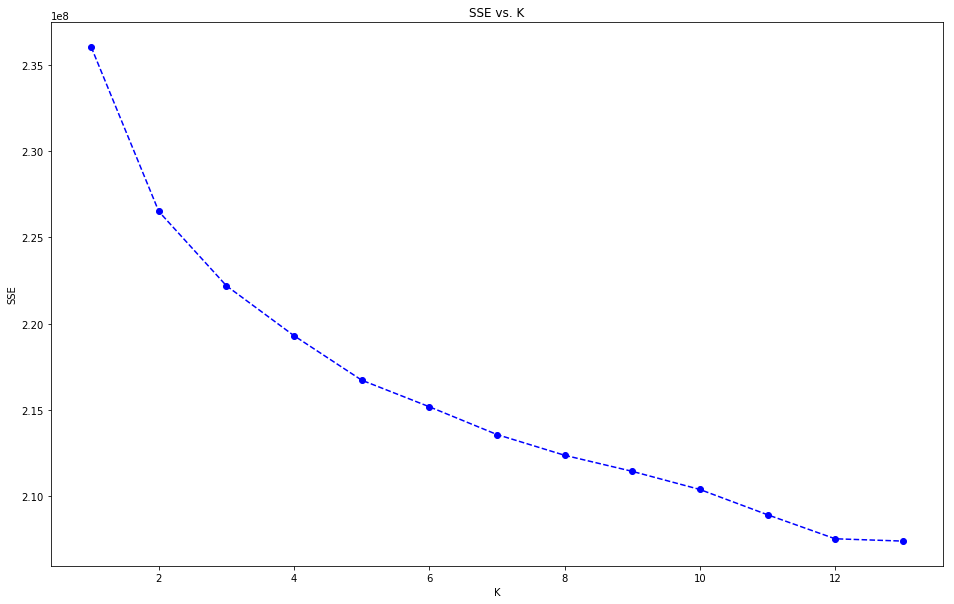

In [153]:
n_clusters, centers, scores = find_clusters(X_pca)
plot_clusters(centers, scores)

In [154]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data
def do_kmean(data_pca, n_clusters):
    
    start = TickTock()
    kmeans = KMeans(n_clusters=n_clusters)

    fit = kmeans.fit(data_pca)
    
    labels = kmeans.predict(data_pca)

    centroids = kmeans.cluster_centers_
    
    print('Time to find cluster: {}'.format(start.stop_clock()))
    
    return kmeans, labels, centroids

def redo_kmean(reused_kmean, data_pca):
    return reused_kmean.predict(data_pca)   

In [155]:
azdias_kmeans, azdias_labels, azdias_centroids = do_kmean(X_pca, 18)

Time to find cluster: 0:11:36.484704


### Discussion 3.1: Apply Clustering to General Population

> - I decided to cluster the general population in 18 segments. The decision was based on the percentage changes of average difference from each point to its assigned cluster's center. So, the reate of change of the scores. 
- At 18 clusters, the scores where changing at a less than .10% change. Thus, the changes here where not as significant as at the beginning. We could say that it is robust. Running any further would just take too much time for a very small percentage reduction in sum of squared errors. 
- The reduced data will be added for another cluster, making 19 clusters. This is due to the retained and reduced distributions being significantly different.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

## 1. Extracting Data
---

In [156]:
# Load in the customer demographics data.
customers = data_extract('Udacity_CUSTOMERS_Subset.csv')

The dataset Udacity_CUSTOMERS_Subset has 85 columns and 191,652 rows.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.00,5,1,5,1,2,2,...,3.00,3.00,1.00,0.00,1.00,5.00,5.00,1.00,2.00,1.00
1,-1,4,1,nan,5,1,5,1,3,2,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,-1,4,2,2.00,5,1,5,1,4,4,...,2.00,3.00,3.00,1.00,3.00,3.00,2.00,3.00,5.00,3.00
3,1,4,1,2.00,5,1,5,2,1,2,...,3.00,2.00,1.00,0.00,1.00,3.00,4.00,1.00,3.00,1.00
4,-1,3,1,6.00,3,1,4,4,5,2,...,2.00,4.00,2.00,1.00,2.00,3.00,3.00,3.00,5.00,1.00


In [157]:
customers.drop(consistent_removal, axis=1, inplace=True)

## 2. Cleaning
---

,NaN_Count,NaN_Impact
count,79.00,79.00
mean,30931.61,0.16
std,25241.61,0.13
min,0.00,0.00
25%,0.00,0.00
50%,48990.00,0.26
75%,50997.00,0.27
max,60064.00,0.31


Skewness:


NaN_Count   -0.37
dtype: float64

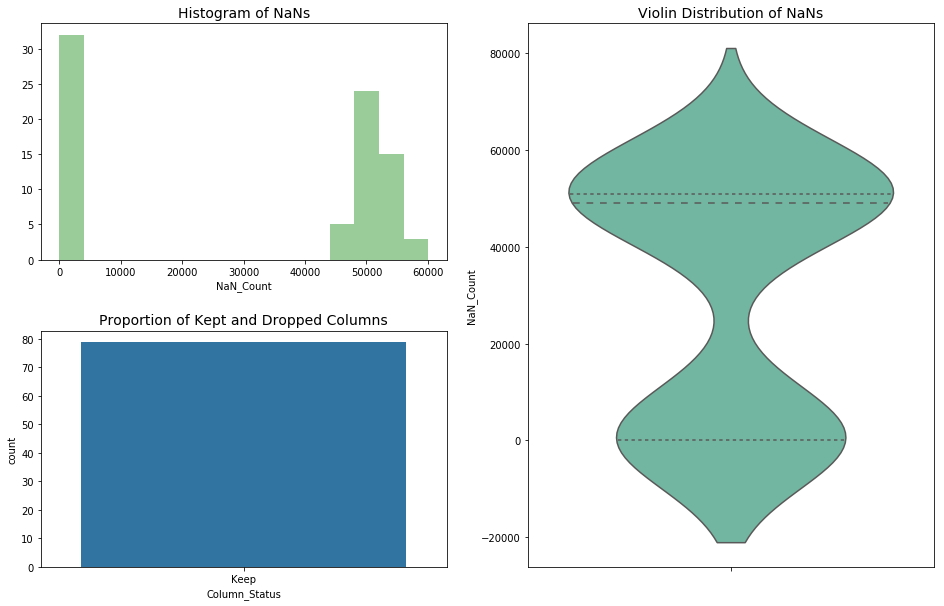

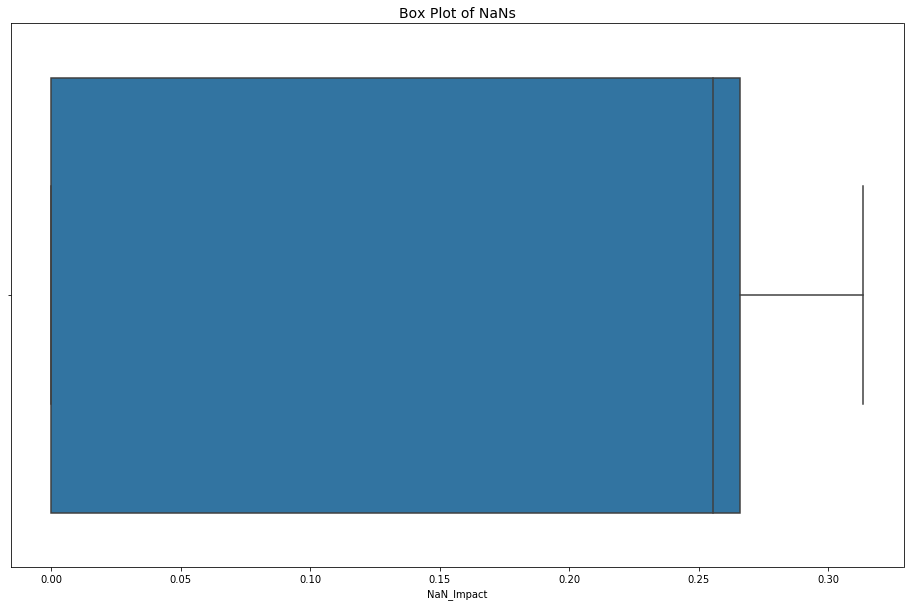

Results from Reduction:
	Outliers with less than -12,206.399999999994 or more than 110,186.4 null count were removed.
	Outliers with less than -6.37% or more than 57.49% impact were removed.
	There is a total of 191,652 rows and 79 columns.
	0 column was/were removed.



,Dropped List


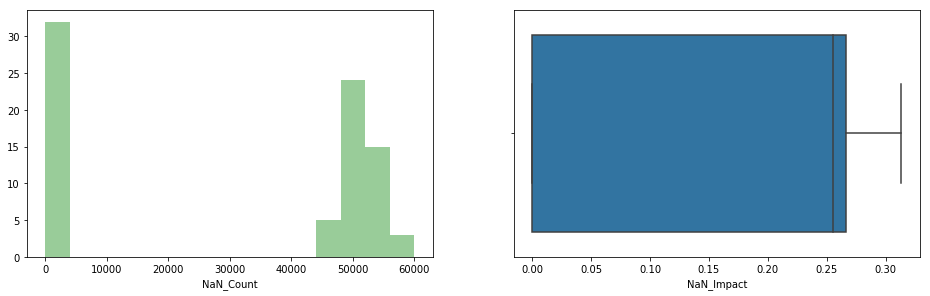

------------------------------------------------------------------------------------------------------------------------------------------------------


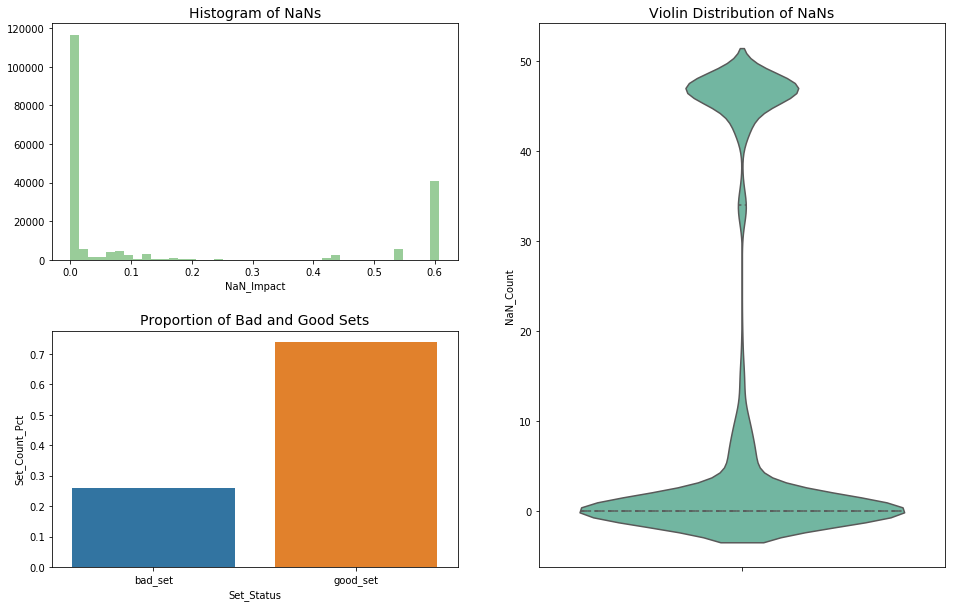

,NaN_Count,NaN_Impact
count,191652.00,191652.00
mean,12.75,0.16
std,19.80,0.25
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,34.00,0.43
max,48.00,0.61


Skewness:


NaN_Count   1.06
dtype: float64

,Set_Status,Set_Count,Set_Count_Pct
0,bad_set,49927,0.26
1,good_set,141725,0.74


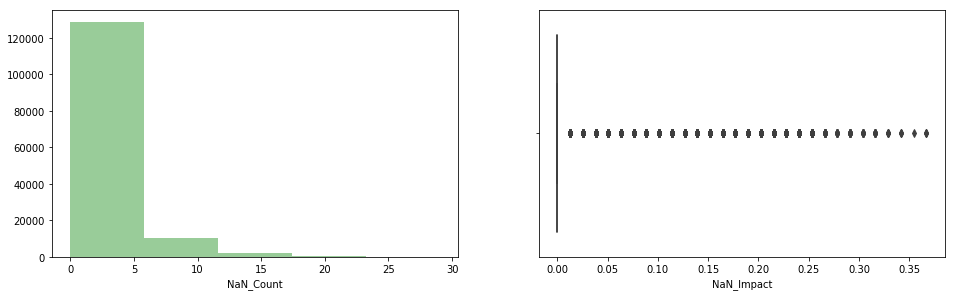

------------------------------------------------------------------------------------------------------------------------------------------------------


,data_type,unique_count
ANREDE_KZ,float64,2
OST_WEST_KZ,object,2
VERS_TYP,float64,2
SOHO_KZ,float64,2
GREEN_AVANTGARDE,float64,2
NATIONALITAET_KZ,float64,3
SHOPPER_TYP,float64,4
LP_STATUS_GROB,float64,5
LP_FAMILIE_GROB,float64,5
FINANZTYP,float64,6


,data_type,unique_count
OST_WEST_KZ,object,2
NATIONALITAET_KZ,float64,3
SHOPPER_TYP,float64,4
LP_STATUS_GROB,float64,5
LP_FAMILIE_GROB,float64,5
FINANZTYP,float64,6
ZABEOTYP,float64,6
GEBAEUDETYP,float64,6
CJT_GESAMTTYP,float64,6
CAMEO_DEUG_2015,object,9


There are 18 categorical variables. 
There are 14 categories with greater than 2 unique or non-numeric values.
14 columns will be encoded.
The dataframe passed had 79 columns in total.
There will be 65 unencoded columns.


Endoding: OST_WEST_KZ
Endoding: NATIONALITAET_KZ
Endoding: SHOPPER_TYP
Endoding: LP_STATUS_GROB
Endoding: LP_FAMILIE_GROB
Endoding: FINANZTYP
Endoding: ZABEOTYP
Endoding: GEBAEUDETYP
Endoding: CJT_GESAMTTYP
Endoding: CAMEO_DEUG_2015
Endoding: LP_STATUS_FEIN
Endoding: LP_FAMILIE_FEIN
Endoding: GFK_URLAUBERTYP
Endoding: CAMEO_DEU_2015


,Encoded,Levels,Gen_Encoded,Gen_Levels,Enc_Delta,Lev_Delta
Feature,,,,,,
OST_WEST_KZ,1,2,1,2,0,0
NATIONALITAET_KZ,4,3,4,3,0,0
SHOPPER_TYP,4,4,4,4,0,0
LP_FAMILIE_GROB,6,5,6,5,0,0
LP_STATUS_GROB,6,5,6,5,0,0
CJT_GESAMTTYP,7,6,7,6,0,0
FINANZTYP,6,6,6,6,0,0
GEBAEUDETYP,6,6,7,7,-1,-1
ZABEOTYP,6,6,6,6,0,0


Train Encoded Shape(14, 2)
 Test Encoded Shape(14, 2)

Status: 
Uencoded columns: 65	rows: 141,725
ToEncode columns: 14	rows: 141,725
Encoded columns: 137	rows: 141,725


,PRAEGENDE_JUGENDJAHRE,FINANZ_SPARER
0,4.00,1.00
2,4.00,1.00
3,1.00,1.00
4,8.00,1.00
5,4.00,1.00


,PRAEGENDE_JUGENDJAHRE,FINANZ_SPARER
0,50s - milk bar / Individualisation (Avantgarde,very high
1,50s - milk bar / Individualisation (Avantgarde,very high
2,40s - war years (Mainstream,very high
3,70s - family orientation (Mainstream,very high
4,50s - milk bar / Individualisation (Avantgarde,very high


Endoding: PRAEGENDE_JUGENDJAHRE_SPARER


,Encoded,Levels,Gen_Encoded,Gen_Levels,Enc_Delta,Lev_Delta
Feature,,,,,,
PRAEGENDE_JUGENDJAHRE_SPARER,59,59,59,59,0,0


Train Encoded Shape(1, 2)
 Test Encoded Shape(1, 2)


,CAMEO_INTL_2015,FINANZ_HAUSBAUER
0,13,2.00
2,34,4.00
3,24,2.00
4,41,2.00
5,34,3.00


,CAMEO_INTL_2015,FINANZ_HAUSBAUER
0,Wealthy Households - Families With School Age ...,high
1,Comfortable Households - Older Families & Matu...,low
2,Prosperous Households - Older Families & Matur...,high
3,Less Affluent Households - Pre-Family Couples ...,high
4,Comfortable Households - Older Families & Matu...,average


Endoding: CAMEO_INTL_2015_FINANZ_HAUSBAUER


,Encoded,Levels,Gen_Encoded,Gen_Levels,Enc_Delta,Lev_Delta
Feature,,,,,,
CAMEO_INTL_2015_FINANZ_HAUSBAUER,110,110,110,110,0,0


Train Encoded Shape(1, 2)
 Test Encoded Shape(1, 2)
Status:
	New feature unique count: 169
	Encoding column count: 169
	Encoded rows: 141,725

The final column count: 371
(141725, 65) (141725, 137) (141725, 169)


<Figure size 1152x1800 with 0 Axes>

In [158]:
customer_clean, customer_split = clean_data(customers, col_treshold=.40)

In [159]:
azdias.shape

(779297, 368)

In [160]:
customer_clean.shape

(141725, 367)

In [161]:
azdias.filter(regex='^GEBA').columns

Index(['GEBAEUDETYP_RASTER', 'GEBAEUDETYP_0', 'GEBAEUDETYP_1', 'GEBAEUDETYP_2',
       'GEBAEUDETYP_3', 'GEBAEUDETYP_4', 'GEBAEUDETYP_5', 'GEBAEUDETYP_6'],
      dtype='object')

In [162]:
customer_clean.filter(regex='^GEBA').columns

Index(['GEBAEUDETYP_RASTER', 'GEBAEUDETYP_0', 'GEBAEUDETYP_1', 'GEBAEUDETYP_2',
       'GEBAEUDETYP_3', 'GEBAEUDETYP_4', 'GEBAEUDETYP_5'],
      dtype='object')

In [163]:
customer_clean['GEBAEUDETYP_6'] = 0

In [164]:
customer_clean.shape

(141725, 368)

In [165]:
print(f'Number of null values in customer_clean: {customer_clean.isna().sum().sum()}')

Number of null values in customer_clean: 122906


,Null,Count
ALTERSKATEGORIE_GROB,7,49920
ANREDE_KZ,0,49927
CJT_GESAMTTYP,89,49838
FINANZ_MINIMALIST,0,49927
FINANZ_SPARER,0,49927
FINANZ_VORSORGER,0,49927
FINANZ_ANLEGER,0,49927
FINANZ_UNAUFFAELLIGER,0,49927
FINANZ_HAUSBAUER,0,49927
FINANZTYP,0,49927


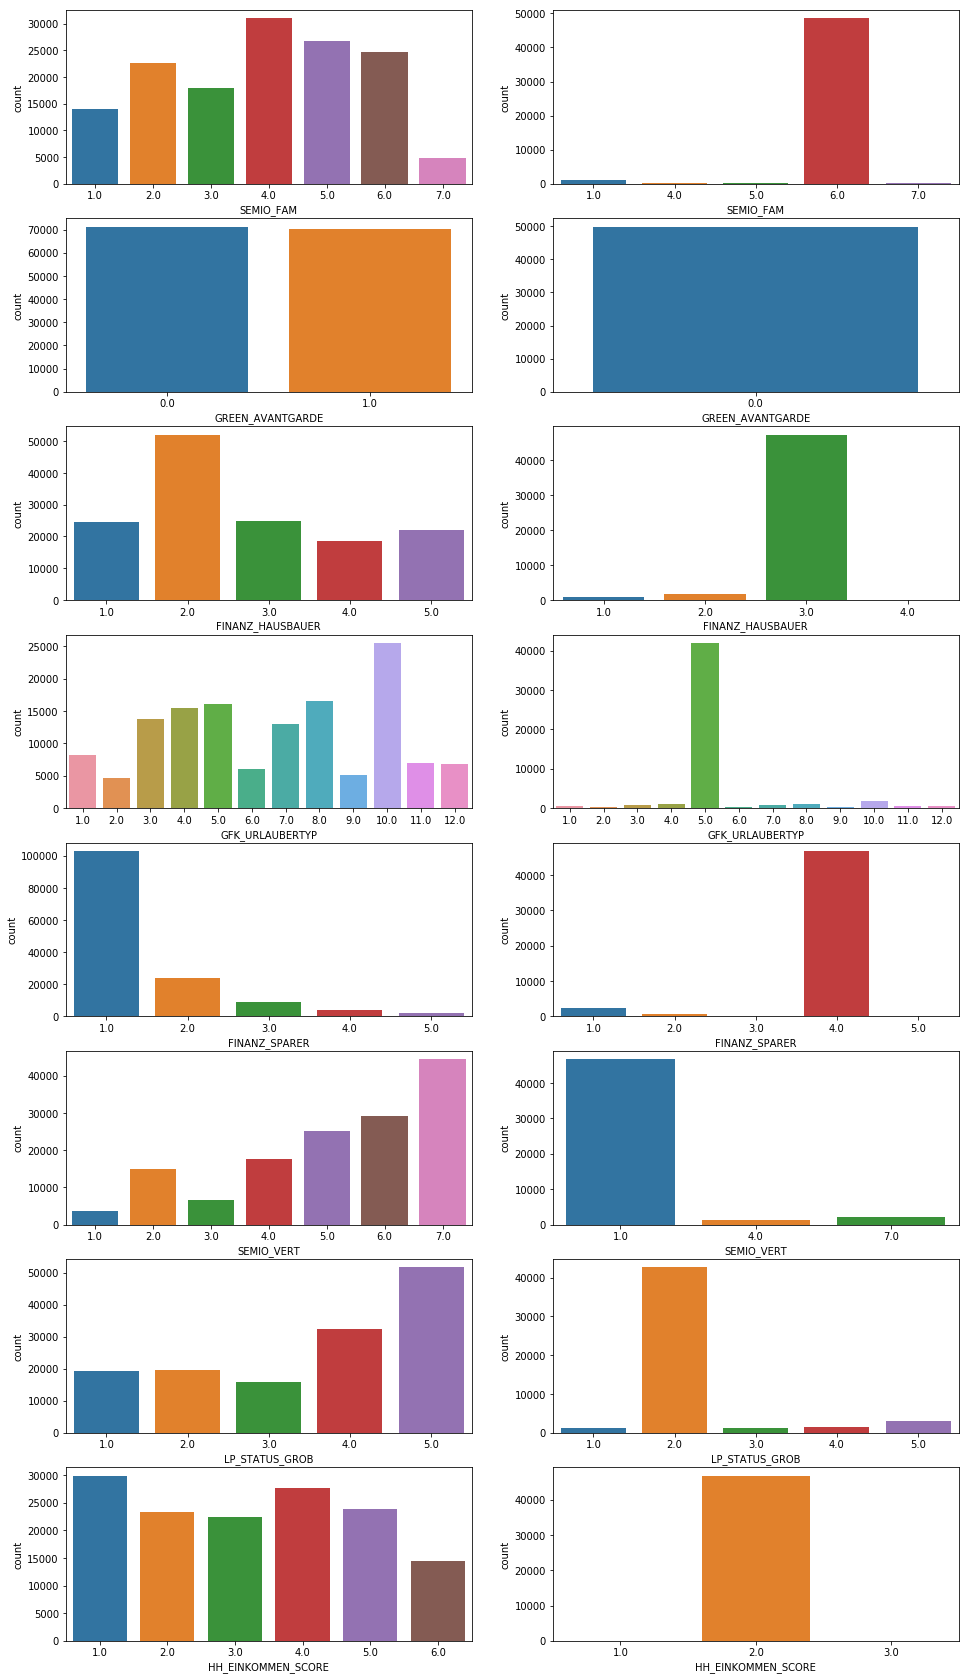

In [166]:
target_columns = get_good_bad_targets(customer_split[1])
plot_good_bad(customer_split[0], customer_split[1], target=target_columns)

## 3. Uencoded Data Imputing and Cleaning

### 1. Assess NaN Removals by Percentage Impact
---

In [167]:
pd.options.display.float_format = '{:2.2%}'.format
frame_nulls_left \
    = pd.DataFrame(customer_clean.isna().sum(), columns=['Null_Counts'])\
        .query("Null_Counts > 0")\
        .sort_values('Null_Counts')
frame_nulls_left['Null_Impact'] = frame_nulls_left.Null_Counts / customer_clean.shape[0]
display_html('All Columns and Null Impact')
display(frame_nulls_left\
            .merge(feat_info[['attribute', 'type']]\
                   .set_index('attribute'),
                          left_index=True, right_index=True, how='left')\
            .sort_values('Null_Impact', ascending=False))

,Null_Counts,Null_Impact,type
KKK,10137,7.15%,ordinal
REGIOTYP,10137,7.15%,ordinal
LP_LEBENSPHASE_FEIN,9840,6.94%,mixed
LP_LEBENSPHASE_GROB,9733,6.87%,mixed
W_KEIT_KIND_HH,7939,5.60%,ordinal
KBA05_GBZ,6055,4.27%,ordinal
KBA05_ANTG2,6053,4.27%,ordinal
KBA05_ANTG4,6053,4.27%,ordinal
KBA05_ANTG1,6053,4.27%,ordinal
MOBI_REGIO,6053,4.27%,ordinal


In [168]:
pd.options.display.float_format = '{:2.4f}'.format
frame_nulls_left.sum()

Null_Counts   122906.0000
Null_Impact        0.8672
dtype: float64

In [169]:
drop_customer_cleanrows = customer_clean.shape[0] - customer_clean.dropna(axis=0, how='any').shape[0]
print(f'Droping all will reduce {drop_customer_cleanrows/customer_clean.shape[0]:2.2%} of the dataset.')

Droping all will reduce 18.06% of the dataset.


>**Remove all conclussion**: Removing all rows with nulls will result at most 100% of dataset removal, which is quite significant. It dependes on which null values are shared null values row by row, which I don't think is possible. In fact, only 77.47% will be reduced. That is almost all the data.

In [170]:
frame_keep_nulls\
    = frame_nulls_left[['Null_Impact']]\
        .sort_values('Null_Impact', ascending=False)\
        .cumsum()\
        .pct_change()\
        .query("Null_Impact > 0.02 or Null_Impact != Null_Impact")\
                .merge(feat_info[['attribute', 'type']]\
                       .set_index('attribute'),
                              left_index=True, right_index=True, how='left')
display_html('Rows to keep per These Columns and Null Impact % Change')
display(frame_keep_nulls.rename(columns={'Null_Impact': 'Null_ImpactCh'}))

,Null_ImpactCh,type
KKK,nan,ordinal
REGIOTYP,1.0000,ordinal
LP_LEBENSPHASE_FEIN,0.4854,mixed
LP_LEBENSPHASE_GROB,0.3232,mixed
W_KEIT_KIND_HH,0.1992,ordinal
KBA05_GBZ,0.1267,ordinal
KBA05_ANTG2,0.1124,ordinal
KBA05_ANTG4,0.1011,ordinal
KBA05_ANTG1,0.0918,ordinal
MOBI_REGIO,0.0841,ordinal


>Note: The percentage change is significat for the above features.

In [171]:
remove_nan = frame_nulls_left[['Null_Impact']]\
    .sort_values('Null_Impact', ascending=False)\
    .cumsum()\
    .pct_change()\
    .query("Null_Impact < 0.02").index
print(f'Removing Row with NaNs for the following features: {list(remove_nan)}')
frame_nulls_left.query(f"index == {list(remove_nan)}").sum()

Removing Row with NaNs for the following features: ['ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW', 'ARBEIT', 'RELAT_AB', 'ORTSGR_KLS9', 'ALTERSKATEGORIE_GROB', 'EWDICHTE', 'BALLRAUM', 'INNENSTADT', 'KONSUMNAEHE']


Null_Counts   5565.0000
Null_Impact      0.0393
dtype: float64

In [172]:
subset = list(remove_nan)
remove_shape = customer_clean.dropna(axis=0, how='any', subset=subset).shape[0]
remove_pct = 1-remove_shape/customer_clean.shape[0]
print(f'Removing all rows from subset will end up reducing the dataset by {remove_pct:2.2%}')

Removing all rows from subset will end up reducing the dataset by 3.03%


>**Remove low percentage impact conclussion**: Removing rows with NaNs out of these ones makes sense since the removal is insignificant.

In [173]:
frame_nulls_left.query(f"index != {list(remove_nan)}").sum()

Null_Counts   117341.0000
Null_Impact        0.8279
dtype: float64

>**Keep high percentage impact conclussion**: Assess imputation of features with high percentage impact.

### 2. Assessing the Ideal Imputing Method
---

In [174]:
head = 5 # change number to see more data value descriptions
display_html('Value Keys for Features with More than 5% NaNs')
data_dict_view\
    .query(f"ColumnName == {list(frame_keep_nulls.index)}")\
    .merge(feat_info[['attribute', 'type']]\
           .rename(columns={'attribute':'ColumnName'}), on='ColumnName', how='left')\
    .head(head)

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta,type
0,1.10,-1,unknown,HEALTH_TYP,TYP,Health typology,NaN,ordinal
1,1.10,0,classification not possible,HEALTH_TYP,TYP,Health typology,NaN,ordinal
2,1.10,1,critical reserved,HEALTH_TYP,TYP,Health typology,NaN,ordinal
3,1.10,2,sanitary affine,HEALTH_TYP,TYP,Health typology,NaN,ordinal
4,1.10,3,jaunty hedonists,HEALTH_TYP,TYP,Health typology,NaN,ordinal


#### 2.1 Numerical Assessment
---
---

In [175]:
data_dict_coldesc.query(f"type == 'numeric' and Kept == True and ColumnName == {list(frame_keep_nulls.index)}")

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
50,3.1,ANZ_HAUSHALTE_AKTIV,HAUSHALTE_AKTIV,Number of households in the building,True,numeric


In [176]:
pd.options.display.float_format = '{:2.2f}'.format
azdias[['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ANZ_HH_TITEL']].describe()

,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,ANZ_HH_TITEL
count,779297.00,779297.00,779297.00
mean,8.36,618.52,0.04
std,15.66,337.34,0.32
min,1.00,0.00,0.00
25%,2.00,386.00,0.00
50%,4.00,549.00,0.00
75%,10.00,773.00,0.00
max,595.00,2300.00,23.00


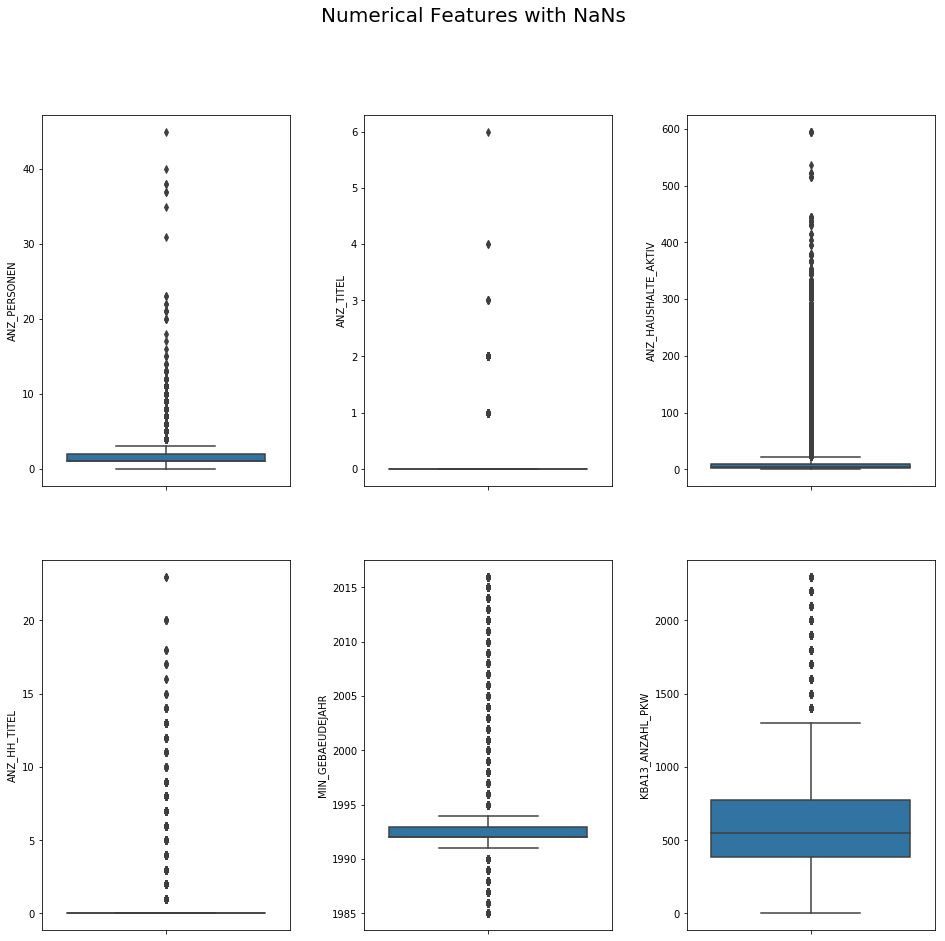

In [177]:
fig1, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 15))

ax_list = []

for x in range(2):
    for j in range(3):
        ax_list.append(ax[x, j])
        
ax00, ax01, ax02, ax10, ax11, ax12 = ax_list


plt.subplots_adjust(wspace=.3)
plt.suptitle('Numerical Features with NaNs', size=20)

sns.boxplot(y='ANZ_PERSONEN', data=azdias, ax=ax00)
sns.boxplot(y='ANZ_TITEL', data=azdias, ax=ax01)
sns.boxplot(y='ANZ_HAUSHALTE_AKTIV', data=azdias, ax=ax02)
sns.boxplot(y='ANZ_HH_TITEL', data=azdias, ax=ax10)
sns.boxplot(y='MIN_GEBAEUDEJAHR', data=azdias, ax=ax11)
sns.boxplot(y='KBA13_ANZAHL_PKW', data=azdias, ax=ax12)
plt.show()

> **Numerical Imputing Conclussion**: 
> - I am imputing the median for numerical feature number 1. This feaatures have significant NaN percentage impact, thus the rows will be kept.
> - I will use the median to inputate values for all numerical features because they are all highly skewed, except for KBA13_ANZAHL_PKW, which is only a bit skewed due to outliers.
---

#### 2.2 Ordinal, Mixed, and Categorical Assessment
---
---

In [178]:
frame_nulls_left

,Null_Counts,Null_Impact
KONSUMNAEHE,6,0.00
EWDICHTE,32,0.00
INNENSTADT,32,0.00
BALLRAUM,32,0.00
ALTERSKATEGORIE_GROB,233,0.00
ORTSGR_KLS9,549,0.00
RELAT_AB,572,0.00
ARBEIT,572,0.00
KBA13_ANZAHL_PKW,1354,0.01
ANZ_HH_TITEL,2183,0.02


In [179]:
def show_cat_plots():
    fig1, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    ax11, ax12, ax21, ax22 = ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]

    plt.suptitle('Count Plots of Top 4 Non-Numerical Features', size=20)
    
    if azdias.isna().sum().sum() > 0: i = 0
    else: i = 1

    # draw plots
    sns.countplot(x=customer_clean.KBA05_ANTG1.fillna(0), ax=ax11)
    ax11.vlines(x=customer_clean.KBA05_ANTG1.median()-i, ymin=0, ymax=customer_clean.groupby('KBA05_ANTG1').size().max())
    sns.countplot(x=customer_clean.ANREDE_KZ.fillna(0), ax=ax12)
    ax12.vlines(x=customer_clean.ANREDE_KZ.median()-i, ymin=0, ymax=customer_clean.groupby('ANREDE_KZ').size().max())
    sns.countplot(x=customer_clean.ANZ_HH_TITEL.fillna(0), ax=ax21)
    ax21.vlines(x=customer_clean.ANZ_HH_TITEL.median()-i, ymin=0, ymax=customer_clean.groupby('ANZ_HH_TITEL').size().max())
    sns.countplot(x=customer_clean.REGIOTYP.fillna(0), ax=ax22)
    ax22.vlines(x=customer_clean.REGIOTYP.median()-i, ymin=0, ymax=customer_clean.groupby('REGIOTYP').size().max())

    plt.show()

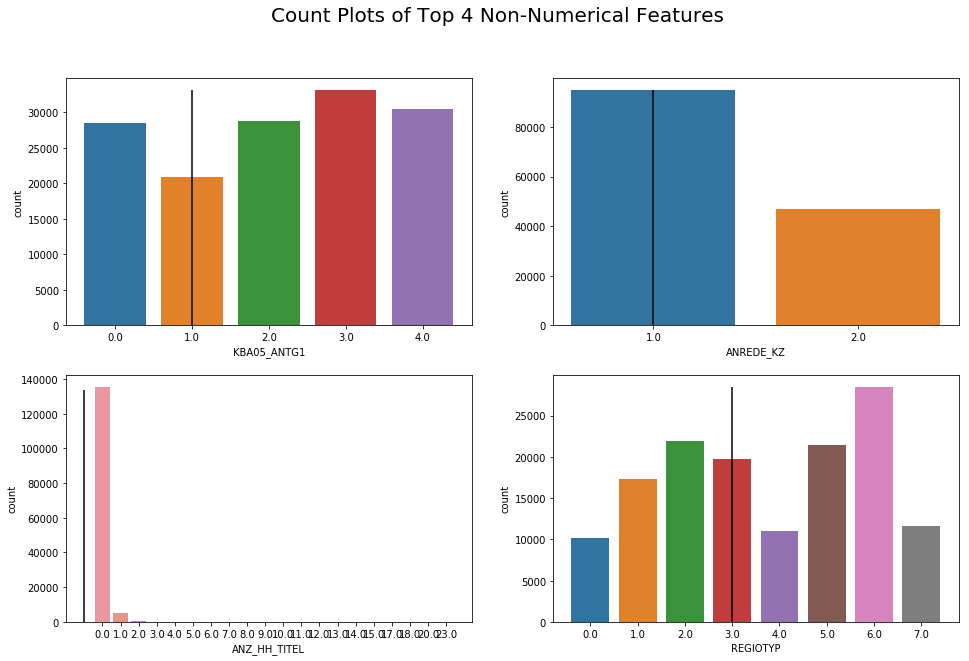

In [180]:
show_cat_plots()

### 3. Imputate or/and Remove NaN values as Assessed
---

#### 3.1 Remove NaNs
---
---

In [181]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
subset = list(remove_nan)

In [182]:
current_rows = customer_clean.shape[0]
customer_clean.dropna(axis=0, how='any', subset=subset, inplace=True)
reduced_rows =  customer_clean.shape[0]
drop_rows = current_rows-reduced_rows
print(f'Customer was reduced by {drop_rows:,}, which is a {drop_rows/current_rows:2.2%} reduction.')

Customer was reduced by 4,297, which is a 3.03% reduction.


#### 3.2 Impute Rounded Medians
---
---

In [183]:
subset = list(frame_nulls_left.query(f"index != {list(remove_nan)}").index)

In [184]:
customer_clean.loc[:, subset].dtypes

HEALTH_TYP             float64
VERS_TYP               float64
ANZ_HAUSHALTE_AKTIV    float64
PLZ8_GBZ               float64
PLZ8_HHZ               float64
PLZ8_BAUMAX            float64
PLZ8_ANTG4             float64
PLZ8_ANTG3             float64
PLZ8_ANTG2             float64
PLZ8_ANTG1             float64
RETOURTYP_BK_S         float64
ONLINE_AFFINITAET      float64
KBA05_ANTG3            float64
MOBI_REGIO             float64
KBA05_ANTG1            float64
KBA05_ANTG4            float64
KBA05_ANTG2            float64
KBA05_GBZ              float64
W_KEIT_KIND_HH         float64
LP_LEBENSPHASE_GROB    float64
LP_LEBENSPHASE_FEIN    float64
REGIOTYP               float64
KKK                    float64
dtype: object

In [185]:
customer_clean.loc[:, subset].shape

(137428, 23)

In [186]:
pd.DataFrame(customer_clean.isna().sum(), columns=['NaNs']).query("NaNs > 0")

,NaNs
HEALTH_TYP,2029
LP_LEBENSPHASE_FEIN,7729
LP_LEBENSPHASE_GROB,7633
RETOURTYP_BK_S,3089
VERS_TYP,2029
W_KEIT_KIND_HH,5643
ANZ_HAUSHALTE_AKTIV,263
KBA05_ANTG1,5103
KBA05_ANTG2,5103
KBA05_ANTG3,5103


In [187]:
customer_clean = redo_imputer(azdias_imputer, customer_clean, subset)

,Imputated Median,Feature
7,2.00,HEALTH_TYP
8,23.00,LP_LEBENSPHASE_FEIN
9,6.00,LP_LEBENSPHASE_GROB
10,4.00,RETOURTYP_BK_S
26,1.00,VERS_TYP
30,5.00,W_KEIT_KIND_HH
32,1.00,ANZ_HAUSHALTE_AKTIV
37,2.00,KBA05_ANTG1
38,1.00,KBA05_ANTG2
39,0.00,KBA05_ANTG3


In [188]:
#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
#customer_clean = pd.DataFrame(imp_median.fit_transform(customer_clean), columns=customer_clean.columns)

> Note: There was no need to round the medians since each imputation matches perfectly with the data dictionary.

In [189]:
print(f'Validating Customer Shape Again: {customer_clean.shape}')

Validating Customer Shape Again: (137428, 368)


In [190]:
print(f'Validating NaNs: {customer_clean.isna().sum().sum()}'+
      f"\n{'Data is ready to scale, pca, kemans' if customer_clean.isna().sum().sum() == 0 else ''}")

Validating NaNs: 0
Data is ready to scale, pca, kemans


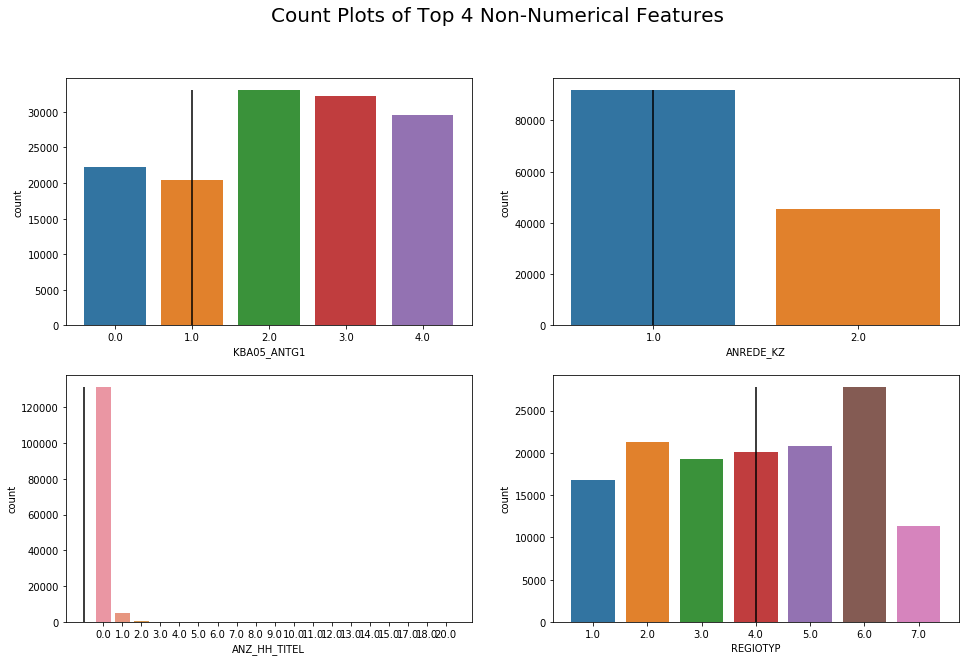

In [191]:
show_cat_plots()

## 3. Scaling
---

In [192]:
redo_standarscaler?

Signature: redo_standarscaler(reused_scaler, dataframe)
Docstring: Returns scaled data only
File:      d:\github\customer_segments\<ipython-input-124-84c14c564fea>
Type:      function


In [193]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
#customer_scaler, X = do_standarscaler(customer_clean)
#n_component = find_n_component(X, customer_clean)
#n_component = 138
X = redo_standarscaler(azdias_scaler, customer_clean)

## 4. Principal Component Analysis
---

In [194]:
redo_pca?

Signature: redo_pca(reused_pca, X_scaled)
Docstring:
Returns
-------
- reused pca model
- pca data
File:      d:\github\customer_segments\<ipython-input-127-a732b42e7d17>
Type:      function


In [195]:
#customer_pca, X_pca = do_pca(208, X)
customer_pca, X_pca = redo_pca(azdias_pca, X)

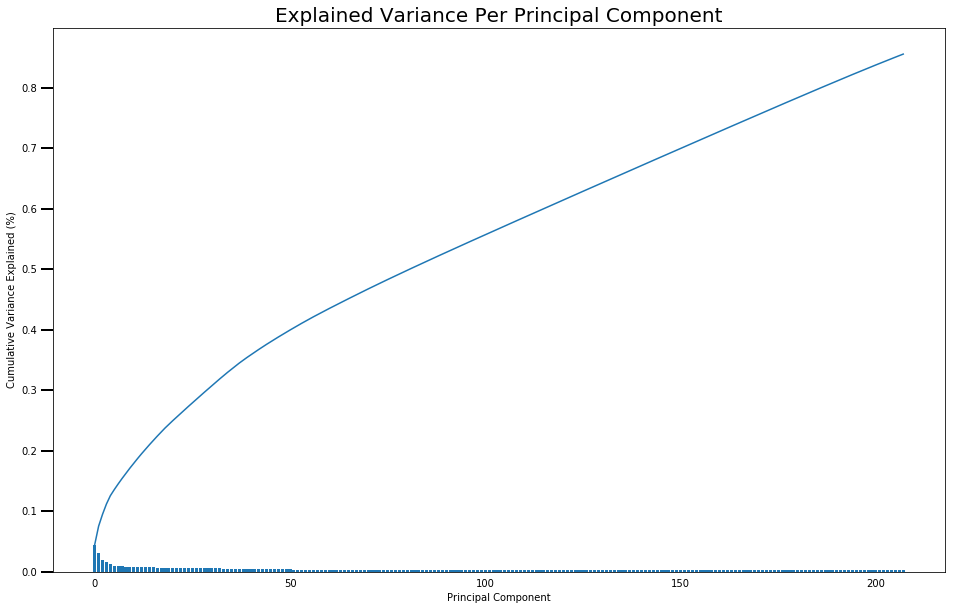

In [196]:
scree_plot(customer_pca)

In [197]:
customer_components = frame_principal_components(customer_clean, customer_pca)

## 5. Kmeans
---

In [198]:
#n_clusters, centers, scores = find_clusters(X_pca)
#plot_clusters(centers, scores)

In [199]:
#customer_kmeans, customer_true_labels, customer_labels, customer_centroids = do_kmean(X_pca, n_clusters)

In [200]:
customer_labels = azdias_kmeans.predict(X_pca)
customer_centroids = azdias_kmeans.cluster_centers_

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [201]:
def get_component_value_key(components, component_name):
    index_clear_map = [f'_{x}' for x in range(100)]
    component = get_principal_component(components, component_name)
    component\
        = component\
            .query("Rank <= 1 or Rank > Rank.max() - 1")\
            .reset_index()\
            .rename(columns={'index':'Features'})
    
    component['Feat_Key']\
        = component\
            .Features\
            .apply(lambda x: x[:x.rfind('_')] if x not in azdias_unencoded.columns.tolist() else x)
    
    try:
        def get_value_key(feature, index):
            
            x=encoder[feature]
            x={i:j for i, j in enumerate(x.classes_[:])}
            print(feature, x.get(int(index)))
            return x.get(int(index))

        component['value_key']\
                = component\
                    .Features\
                    .apply(lambda x: get_value_key(x[:x.rfind('_')], x[x.rfind('_')+1:]))
    except: print('No specific value')
    
    display(component)
    display(data_dict_view\
        .query(f"ColumnName=={list(component.Feat_Key)}")\
        .sort_values(['key', 'ColumnName', 'value_key'])\
        .query("ValueMaps != 'unknown'"))

## 1. Cluster Representation Significance
---

In [202]:
# create cluster dataframes
cluster_customer = pd.DataFrame({'clusters': customer_labels})
cluster_azdias = pd.DataFrame({'clusters': azdias_labels})

In [203]:
# combine and unpivot dataframes for populations
population_clusters = \
    pd.concat([cluster_customer[['clusters']].rename(columns={'clusters':'customer'}), 
               cluster_azdias[['clusters']].rename(columns={'clusters':'azdias'})], 
              axis=1)\
        .melt(value_vars=['customer', 'azdias'], var_name='Population', value_name='Cluster')

In [204]:
# add 1 to clusters to represent clusters from 1 to n
population_clusters.Cluster = population_clusters.Cluster.apply(lambda x: x + 1)

In [205]:
population_clusters = pd.DataFrame(population_clusters.groupby(['Population', 'Cluster']).size(), columns=['Frequency']).reset_index()

In [206]:
bad_set_cluster = population_clusters.Cluster.max()+1
azdias_bad_cluster = pd.DataFrame({'Population': ['azdias'], 
                           'Cluster': bad_set_cluster, 
                           'Frequency':azdias_bad.shape[0]})
customer_bad_cluster = pd.DataFrame({'Population': ['customer'], 
                             'Cluster': bad_set_cluster, 
                             'Frequency': customer_split[1].shape[0]})

In [207]:
population_clusters = pd.concat([population_clusters, 
                                 azdias_bad_cluster, 
                                 customer_bad_cluster], 
                                ignore_index=True)

In [208]:
population_clusters\
    = pd.concat([
        population_clusters\
            .query("Population == 'customer'")\
            .eval("Freq = Frequency/Frequency.sum()"),
        population_clusters\
            .query("Population == 'azdias'")\
            .eval("Freq = Frequency/Frequency.sum()")
])

In [209]:
population_clusters.groupby('Population').sum().reset_index()

,Population,Cluster,Frequency,Freq
0,azdias,190.00,872448,1.00
1,customer,190.00,187355,1.00


In [210]:
# geting population cluster groups and pivoting table to get significances
population_cluster_freqpct = population_clusters\
    .pivot_table(index='Cluster', columns='Population', values='Freq')\
    .reset_index()\
    .rename_axis('', axis=1)

condition = population_cluster_freqpct.azdias < population_cluster_freqpct.customer
population_cluster_freqpct\
    .loc[condition, 'Represented'] = 'Over'
population_cluster_freqpct\
    .loc[~condition, 'Represented'] = 'Under'
population_cluster_freqpct['Significance'] \
    = population_cluster_freqpct.customer/population_cluster_freqpct.azdias-1

# taking care of reduced label
population_cluster_freqpct.loc[population_cluster_freqpct.Cluster==bad_set_cluster, 'Represented'] = 'Reduced'

# adding rank
population_cluster_freqpct.loc[population_cluster_freqpct.Represented == 'Under', 'SigRank'] \
    = population_cluster_freqpct.query("Represented == 'Under'").Significance.rank(method='dense')

population_cluster_freqpct.loc[population_cluster_freqpct.Represented == 'Over', 'SigRank'] \
    = population_cluster_freqpct.query("Represented == 'Over'").Significance.rank(method='dense', ascending=0)
 
#population_cluster_freqpct.SigRank = population_cluster_freqpct.SigRank.astype(int)
#population_cluster_freqpct.Cluster = population_cluster_freqpct.Cluster.astype(int)
display_html('Cluster Representation & Significance DataFrame')
population_cluster_freqpct.sort_values(['Represented', 'SigRank'])

,Cluster,azdias,customer,Represented,Significance,SigRank
1,2.00,0.09,0.21,Over,1.32,1.00
7,8.00,0.02,0.04,Over,0.87,2.00
16,17.00,0.03,0.06,Over,0.77,3.00
4,5.00,0.00,0.01,Over,0.66,4.00
10,11.00,0.06,0.09,Over,0.45,5.00
11,12.00,0.08,0.11,Over,0.36,6.00
17,18.00,0.10,0.11,Over,0.00,7.00
18,19.00,0.11,0.27,Reduced,1.50,nan
6,7.00,0.01,0.00,Under,-0.97,1.00
9,10.00,0.09,0.00,Under,-0.95,2.00


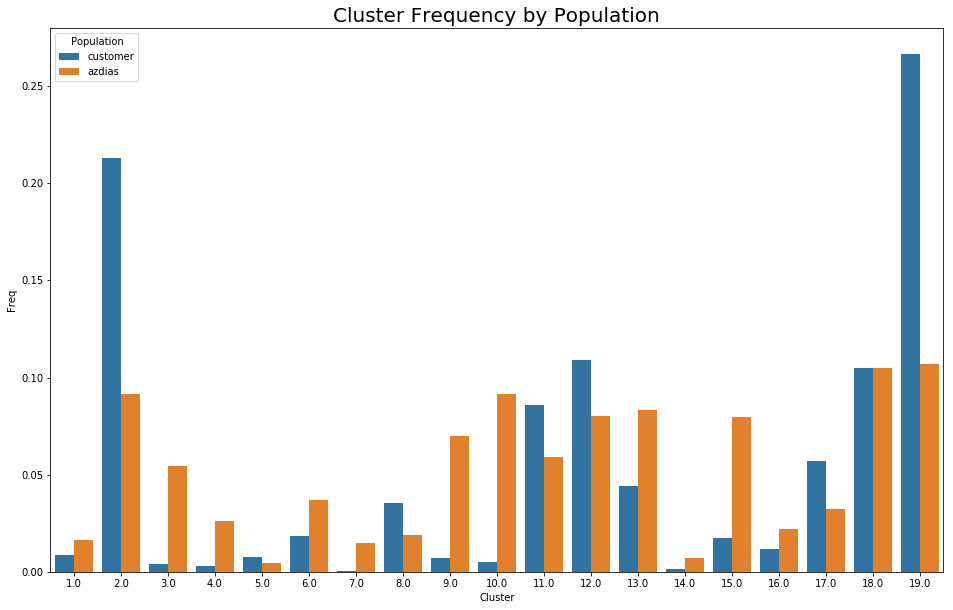

In [211]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population
plt.figure(figsize=(16, 10))
sns.barplot(x='Cluster', y='Freq', hue='Population', data=population_clusters)
plt.title('Cluster Frequency by Population', size=20)
plt.show()

In [212]:
display_html('Cluster Representation Significance Findings:')
xx = population_cluster_freqpct.query("SigRank == 1")[['Cluster', 'Represented']]
xx = list(pd.DataFrame([xx[x].values for x in xx]).T.set_index(0).to_dict().values())[0]

print(f'\t• Cluster {list(xx.keys())[1]} is the most {list(xx.values())[1].lower()}-represented cluster\n\n'+\
      f'\t• Cluster {list(xx.keys())[0]} is the most {list(xx.values())[0].lower()}-represented cluster')
ClusterId = tuple(xx.keys())

	• Cluster 7.0 is the most under-represented cluster

	• Cluster 2.0 is the most over-represented cluster


## 2. Over-represented Cluster Analysis
---

In [213]:
under_over = [int(x) for x in xx.keys()]

In [214]:
over_cluster = ['Cluster_' + str(under_over[1])]
under_cluster =  ['Cluster_' + str(under_over[0])]
naming_range = int(bad_set_cluster)

# over represented
cluster_over = pd.DataFrame(customer_centroids).T\
    .rename(columns={x:'Cluster_' + str(x+1) for x in range(naming_range)})
cluster_over.index = ['PC_'+str(x+1) for x in cluster_over.index]
cluster_over_head = cluster_over[over_cluster]\
    .apply(lambda x: abs(x))\
    .sort_values(over_cluster, ascending=False)\
    .head()

# under represented
cluster_under = pd.DataFrame(customer_centroids).T\
    .rename(columns={x:'Cluster_' + str(x+1) for x in range(naming_range)})
cluster_under.index = ['PC_'+str(x+1) for x in cluster_under.index]
cluster_under_head = cluster_under[under_cluster]\
    .apply(lambda x: abs(x))\
    .sort_values(under_cluster, ascending=False)\
    .head()

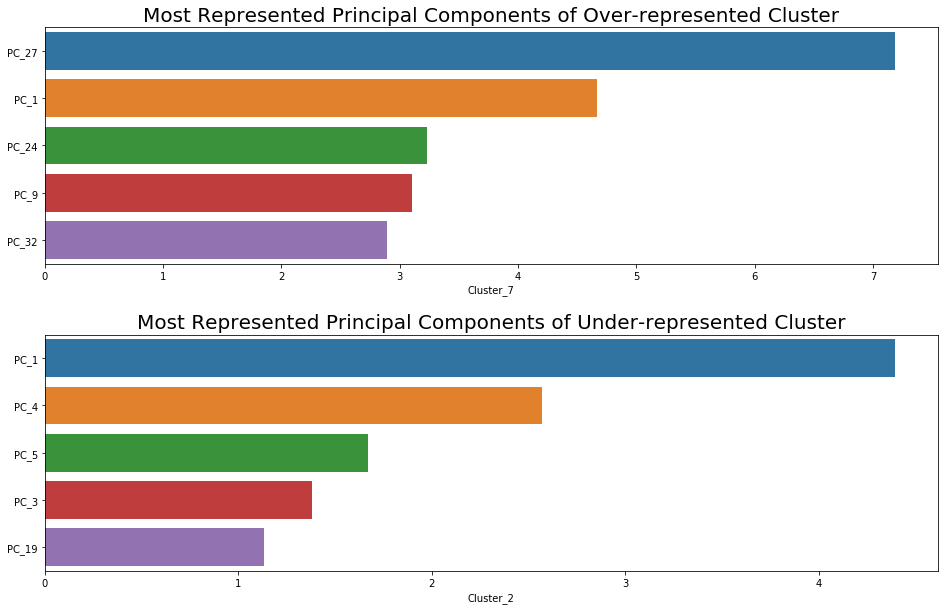

In [215]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 10))
ax[0].set_title('Most Represented Principal Components of Over-represented Cluster', size=20)
sns.barplot(cluster_over_head[over_cluster[0]], cluster_over_head.index, ax=ax[0])
ax[1].set_title('Most Represented Principal Components of Under-represented Cluster', size=20)
sns.barplot(cluster_under_head[under_cluster[0]], cluster_under_head.index, ax=ax[1])
plt.subplots_adjust(hspace=.3)
plt.show()

In [216]:
# primary principal component
over_cluster_pc = cluster_over_head[:1].index.tolist()[0]
over_cluster_pc = int(over_cluster_pc[over_cluster_pc.find('_')+1:])
under_cluster_pc = cluster_under_head[:1].index.tolist()[0]
under_cluster_pc = int(under_cluster_pc[under_cluster_pc.find('_')+1:])

In [217]:
# secondary principal component
over_cluster_pc_sec = cluster_over_head.index[1]
over_cluster_pc_sec = int(over_cluster_pc_sec[over_cluster_pc_sec.find('_')+1:])
under_cluster_pc_sec = cluster_under_head.index[1]
under_cluster_pc_sec = int(under_cluster_pc_sec[under_cluster_pc_sec.find('_')+1:])

In [218]:
display_html('Customer Feature Descriptions')
print(f'This subset ({over_cluster[0]}) is driven mostly by principal component {over_cluster_pc}.\n')
get_component_value_key(customer_components, f'Dimension_{over_cluster_pc}')

This subset (Cluster_7) is driven mostly by principal component 27.

CAMEO_DEU_2015 2B
CAMEO_DEU_2015 3A


,Features,Dimension_27,Rank,Feat_Key,value_key
0,CAMEO_DEU_2015_7,0.46,62,CAMEO_DEU_2015,2B
1,CAMEO_DEU_2015_10,-0.21,1,CAMEO_DEU_2015,3A


,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta


In [219]:
display_html('Customer Feature Descriptions')
print(f'This subset ({over_cluster[0]}) is driven secondarily by principal component {over_cluster_pc_sec}.\n')
get_component_value_key(customer_components, f'Dimension_{over_cluster_pc_sec}')

This subset (Cluster_7) is driven secondarily by principal component 1.

LP_STATUS_GROB 1
No specific value


,Features,Dimension_1,Rank,Feat_Key
0,LP_STATUS_GROB_1,0.19,47,LP_STATUS_GROB
1,MOBI_REGIO,-0.20,1,MOBI_REGIO


,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
165,1.16,1,low-income earners (maps to 1-2 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
166,1.16,2,average earners (maps to 3-5 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
167,1.16,3,independents (maps to 6-7 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
168,1.16,4,houseowners (maps to 8-9 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
169,1.16,5,top earners (maps to 10 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
539,7.3,1,very high movement,MOBI_REGIO,REGIO,Movement patterns,NaN
540,7.3,2,high movement,MOBI_REGIO,REGIO,Movement patterns,NaN
541,7.3,3,middle movement,MOBI_REGIO,REGIO,Movement patterns,NaN
542,7.3,4,low movement,MOBI_REGIO,REGIO,Movement patterns,NaN
543,7.3,5,very low movement,MOBI_REGIO,REGIO,Movement patterns,NaN


### Over-rerpesented findings:
 - The primary over-represented people in cluster 15 are the temporary workers in urban working class.
 - The secondary over-represented people in cluster 15 are the low-income earners and their movement patterns.

## 3. Under-represented Cluster Analysis
---

In [220]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [221]:
display_html('Customer Feature Descriptions')
print(f'This subset (cluster {under_cluster[0]}) is driven mostly by principal component {under_cluster_pc}.\n')
get_component_value_key(customer_components, f'Dimension_{under_cluster_pc}')

This subset (cluster Cluster_2) is driven mostly by principal component 1.

LP_STATUS_GROB 1
No specific value


,Features,Dimension_1,Rank,Feat_Key
0,LP_STATUS_GROB_1,0.19,47,LP_STATUS_GROB
1,MOBI_REGIO,-0.20,1,MOBI_REGIO


,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
165,1.16,1,low-income earners (maps to 1-2 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
166,1.16,2,average earners (maps to 3-5 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
167,1.16,3,independents (maps to 6-7 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
168,1.16,4,houseowners (maps to 8-9 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
169,1.16,5,top earners (maps to 10 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
539,7.3,1,very high movement,MOBI_REGIO,REGIO,Movement patterns,NaN
540,7.3,2,high movement,MOBI_REGIO,REGIO,Movement patterns,NaN
541,7.3,3,middle movement,MOBI_REGIO,REGIO,Movement patterns,NaN
542,7.3,4,low movement,MOBI_REGIO,REGIO,Movement patterns,NaN
543,7.3,5,very low movement,MOBI_REGIO,REGIO,Movement patterns,NaN


In [222]:
display_html('Customer Feature Descriptions')
print(f'This subset (cluster {under_cluster[0]}) is driven secondarily by principal component {under_cluster_pc_sec}.\n')
get_component_value_key(customer_components, f'Dimension_{under_cluster_pc_sec}')

This subset (cluster Cluster_2) is driven secondarily by principal component 4.

No specific value


,Features,Dimension_4,Rank,Feat_Key
0,LP_LEBENSPHASE_GROB,0.23,44,LP_LEBENSPHASE_GROB
1,LP_FAMILIE_FEIN_2,-0.22,1,LP_FAMILIE_FEIN
2,LP_FAMILIE_GROB_1,-0.22,1,LP_FAMILIE_GROB


,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
125,1.12,1,single low-income and average earners of young...,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN
126,1.12,2,single low-income and average earners of highe...,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN
127,1.12,3,single high-income earners,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN
128,1.12,4,single low-income and average-earner couples,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN
129,1.12,5,single high-income earner couples,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN
130,1.12,6,single parents,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN
131,1.12,7,single low-income and average earner families,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN
132,1.12,8,high-income earner families,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN
133,1.12,9,average earners of younger age from multiperso...,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN
134,1.12,10,low-income and average earners of higher age f...,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,NaN


In [223]:
data_dict_view.query("ColumnShortName=='HAUSBAUER'")

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
28,1.5,-1,unknown,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
34,1.5,1,very high,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
40,1.5,2,high,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
46,1.5,3,average,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
52,1.5,4,low,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
58,1.5,5,very low,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership


### Under-rerpesented findings:
 - The primary under-represented people in cluster 14 are the Noble Jogger and the people focusing in ther career and family.
 - The secondary under-represented people in cluster 14 are the people in confortable households with shool age children who have high home ownership and the wealthy households with young couples with children with high home ownership.

In [224]:
population_cluster_freqpct.sort_values(['Represented', 'SigRank'])

,Cluster,azdias,customer,Represented,Significance,SigRank
1,2.00,0.09,0.21,Over,1.32,1.00
7,8.00,0.02,0.04,Over,0.87,2.00
16,17.00,0.03,0.06,Over,0.77,3.00
4,5.00,0.00,0.01,Over,0.66,4.00
10,11.00,0.06,0.09,Over,0.45,5.00
11,12.00,0.08,0.11,Over,0.36,6.00
17,18.00,0.10,0.11,Over,0.00,7.00
18,19.00,0.11,0.27,Reduced,1.50,nan
6,7.00,0.01,0.00,Under,-0.97,1.00
9,10.00,0.09,0.00,Under,-0.95,2.00


### Discussion 3.3: Compare Customer Data to Demographics Data

### Over-rerpesented findings:
 - The primary over-represented people in cluster 15 are the temporary workers in urban working class.
 - The secondary over-represented people in cluster 15 are the low-income earners and their movement patterns.
 
### Under-rerpesented findings:
 - The primary under-represented people in cluster 14 are the Noble Jogger and the people focusing in ther career and family.
 - The secondary under-represented people in cluster 14 are the people in confortable households with shool age children who have high home ownership and the wealthy households with young couples with children with high home ownership.

We can determine that the one of the most relatively popular segments is cluster 15; and one of the most relatively unpopular is cluster 14. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.